In [1]:
import sys
print(sys.version)

!python --version

3.9.7 (tags/v3.9.7:1016ef3, Aug 30 2021, 20:19:38) [MSC v.1929 64 bit (AMD64)]
Python 3.9.7


In [ ]:
# GRU model code reference - https://www.kaggle.com/code/dpamgautam/stock-price-prediction-lstm-gru-rnn
# LSTM model code refernce - https://github.com/vivekgohel56/stock-price-prediction-of-netflix-stocks-using-lstm/tree/master
# arima model code reference - https://www.kaggle.com/code/sriharshaeedala/amazon-stock-price-prediction-with-arima-98
# hmm model code reference - https://github.com/IanQuan/Hidden-Markov-Model-on-Stock-Price-Prediction/blob/main/stock_prediction_hmm.ipynb
# arima model update code reference - https://github.com/kevinkurniasantosa/Stock-Market-Prediction-Using-Machine-Learning/blob/master/scripts/algorithms/arima.py
# xgboost model code reference - https://www.kaggle.com/code/mtszkw/xgboost-for-stock-trend-prices-prediction


You should consider upgrading via the 'C:\Users\SHEPHERD\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\SHEPHERD\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\SHEPHERD\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.



Loading data...

Starting predictions...

Processing AAMRANET...

Training LSTM model...
Epoch 1/100
17/17 [==============================] - 6s 34ms/step - loss: 0.0439
Epoch 2/100
17/17 [==============================] - 1s 33ms/step - loss: 0.0117
Epoch 3/100
17/17 [==============================] - 1s 34ms/step - loss: 0.0094
Epoch 4/100
17/17 [==============================] - 1s 33ms/step - loss: 0.0086
Epoch 5/100
17/17 [==============================] - 1s 33ms/step - loss: 0.0086
Epoch 6/100
17/17 [==============================] - 1s 33ms/step - loss: 0.0078
Epoch 7/100
17/17 [==============================] - 1s 33ms/step - loss: 0.0077
Epoch 8/100
17/17 [==============================] - 1s 33ms/step - loss: 0.0084
Epoch 9/100
17/17 [==============================] - 1s 40ms/step - loss: 0.0073
Epoch 10/100
17/17 [==============================] - 1s 34ms/step - loss: 0.0063
Epoch 11/100
17/17 [==============================] - 1s 34ms/step - loss: 0.0063
Epoch 12/100
17/1

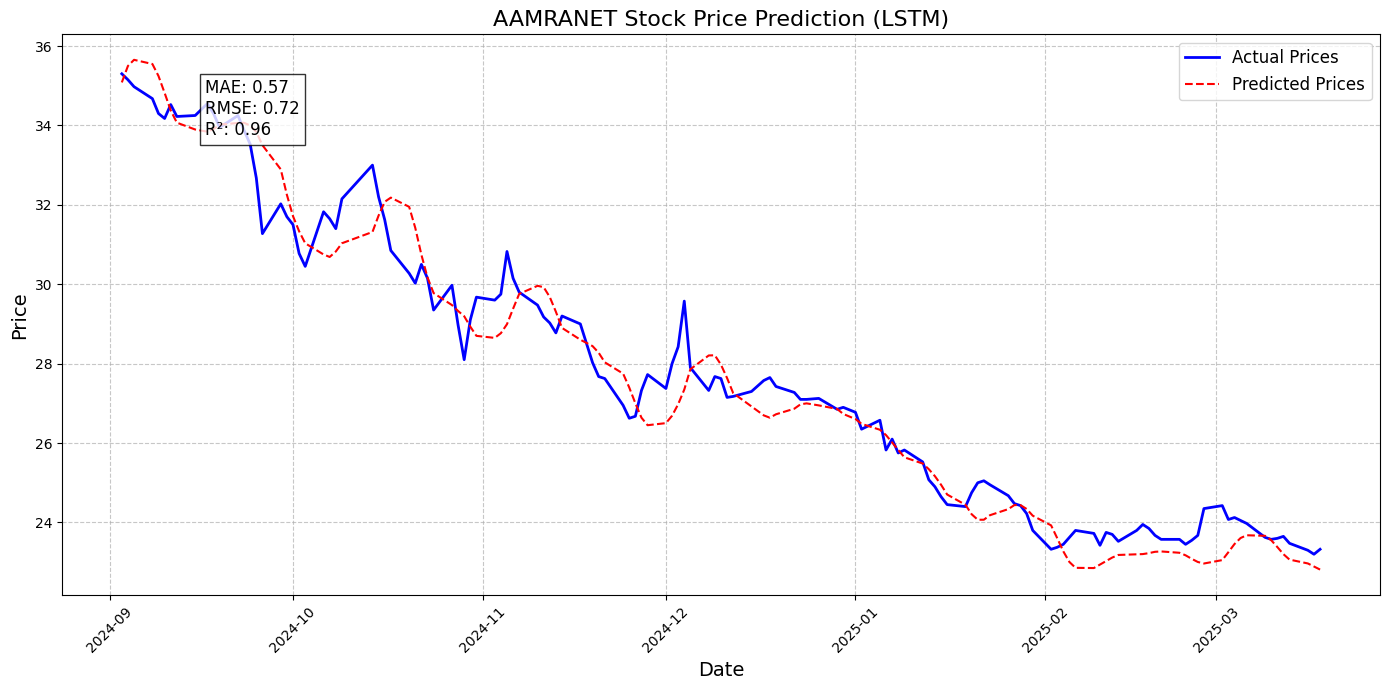


Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            16896     
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)  

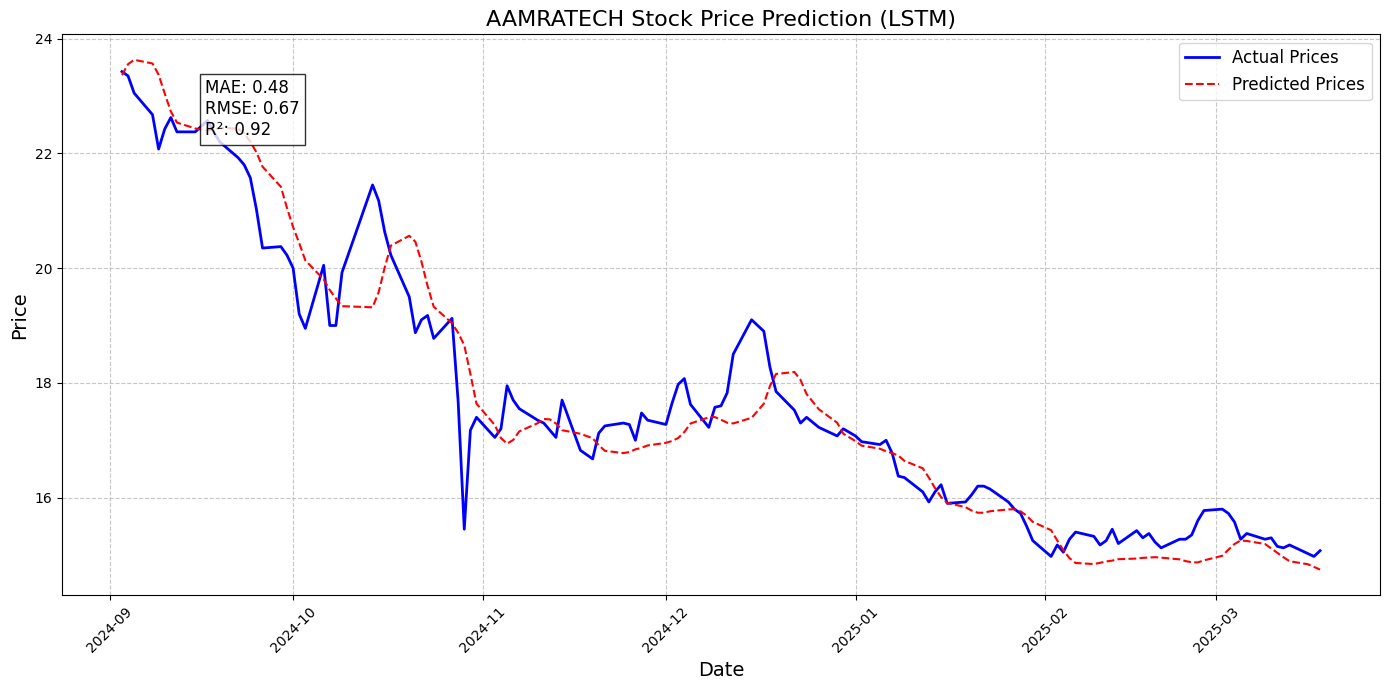


Model Summary:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 64)            16896     
                                                                 
 dropout_3 (Dropout)         (None, 30, 64)            0         
                                                                 
 lstm_4 (LSTM)               (None, 30, 64)            33024     
                                                                 
 dropout_4 (Dropout)         (None, 30, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)

In [2]:
# correct code for lstm
# --- Install Required Libraries with Specific Versions ---
!pip install -q numpy==1.23.5 pandas==1.5.3 matplotlib==3.7.1 scikit-learn==1.2.2 
!pip install -q statsmodels==0.14.0 pmdarima==2.0.3 xgboost==1.7.5 
!pip install -q tensorflow==2.12.0 keras==2.12.0

# --- Import Libraries ---
import numpy as np                # v1.23.5
import pandas as pd               # v1.5.3
import matplotlib.pyplot as plt   # v3.7.1
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler  # v1.2.2
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential  # v2.12.0
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

# --- Data Loading and Preparation ---
def load_data(filepath):
    """Load and preprocess the stock data"""
    df = pd.read_csv(filepath, parse_dates=['Date'], dayfirst=True)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])
    df = df.sort_values(['Company', 'Date'])
    
    # Ensure numeric columns
    numeric_cols = ['Open', 'Close', 'High', 'Low', 'Volume']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    df = df.dropna(subset=numeric_cols)
    
    return df

def prepare_company_data(company_data, look_back=30):
    """Prepare data for a single company"""
    # Create OHLC average feature
    company_data['ohlc_avg'] = company_data[['Open', 'High', 'Low', 'Close']].mean(axis=1)
    
    # Normalize data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(company_data[['ohlc_avg']])
    
    # Create sequences
    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i, 0])
        y.append(scaled_data[i, 0])
    
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    return X, y, scaler, company_data

# --- Enhanced Model Definitions ---
def train_lstm(X_train, y_train, epochs=100, batch_size=32):
    """Enhanced LSTM implementation"""
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.3),
        LSTM(64, return_sequences=True),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.3),
        Dense(1, activation='linear')
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
              callbacks=[early_stopping], verbose=1)
    return model

def train_bilstm(X_train, y_train, epochs=100, batch_size=32):
    """Enhanced Bi-LSTM implementation"""
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.3),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(64)),
        Dropout(0.3),
        Dense(1, activation='linear')
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              callbacks=[early_stopping], verbose=1)
    return model

# --- Main Prediction Function ---
def predict_stock_prices(df, model_type='lstm', look_back=30):
    """Predict stock prices for all companies in the dataframe"""
    companies = df['Company'].unique()
    results = {}
    
    for company in companies:
        try:
            print(f"\n{'='*50}\nProcessing {company}...\n{'='*50}")
            company_data = df[df['Company'] == company].copy()
            
            if len(company_data) < look_back * 2:
                print(f"Skipping {company} - insufficient data ({len(company_data)} records)")
                continue
                
            # Prepare data
            X, y, scaler, company_data = prepare_company_data(company_data, look_back)
            
            # Train-test split (80-20)
            split = int(0.8 * len(X))
            X_train, X_test = X[:split], X[split:]
            y_train, y_test = y[:split], y[split:]
            
            # Train model
            if model_type.lower() == 'bilstm':
                print("\nTraining Bi-LSTM model...")
                model = train_bilstm(X_train, y_train)
            else:
                print("\nTraining LSTM model...")
                model = train_lstm(X_train, y_train)
            
            # Make predictions
            predicted = model.predict(X_test)
            predicted_prices = scaler.inverse_transform(predicted)
            actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
            
            # Get dates for plotting
            test_dates = company_data['Date'].iloc[split+look_back:].values
            
            # Calculate metrics
            mae = mean_absolute_error(actual_prices, predicted_prices)
            rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
            r2 = r2_score(actual_prices, predicted_prices)
            
            # Store results
            results[company] = {
                'dates': test_dates,
                'actual': actual_prices.flatten(),
                'predicted': predicted_prices.flatten(),
                'metrics': {
                    'MAE': mae,
                    'RMSE': rmse,
                    'R2': r2
                },
                'model_summary': model.summary()
            }
            
            # Plot results
            plt.figure(figsize=(14, 7))
            plt.plot(test_dates, actual_prices, label='Actual Prices', color='blue', linewidth=2)
            plt.plot(test_dates, predicted_prices, label='Predicted Prices', color='red', linestyle='--')
            plt.title(f'{company} Stock Price Prediction ({model_type.upper()})', fontsize=16)
            plt.xlabel('Date', fontsize=14)
            plt.ylabel('Price', fontsize=14)
            plt.legend(fontsize=12)
            plt.grid(True, linestyle='--', alpha=0.7)
            
            # Format x-axis
            plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
            plt.xticks(rotation=45)
            
            # Add metrics to plot
            plt.figtext(0.15, 0.8, 
                       f"MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.2f}", 
                       bbox=dict(facecolor='white', alpha=0.8),
                       fontsize=12)
            
            plt.tight_layout()
            plt.show()
            
            # Print model summary
            print("\nModel Summary:")
            model.summary()
            
            print(f"\nMetrics for {company}:")
            print(f"MAE: {mae:.4f}")
            print(f"RMSE: {rmse:.4f}")
            print(f"R2 Score: {r2:.4f}")
            
        except Exception as e:
            print(f"\nError processing {company}: {str(e)}")
    
    return results

# --- Main Execution ---
if __name__ == "__main__":
    # Load data
    file_path = "combined_stock_data_test.csv"
    print("\nLoading data...")
    stock_data = load_data(file_path)
    
    # Run predictions (change to 'bilstm' for Bi-LSTM model)
    print("\nStarting predictions...")
    prediction_results = predict_stock_prices(stock_data, model_type='lstm')
    
    # Save results to CSV
    results_df = pd.DataFrame.from_dict({
        company: results['metrics'] 
        for company, results in prediction_results.items()
    }, orient='index')
    
    results_df.to_csv('stock_prediction_results.csv')
    print("\nPrediction results saved to 'stock_prediction_results.csv'")
    
    # Save full results with predictions
    full_results = []
    for company, data in prediction_results.items():
        temp_df = pd.DataFrame({
            'Company': company,
            'Date': data['dates'],
            'Actual_Price': data['actual'],
            'Predicted_Price': data['predicted']
        })
        full_results.append(temp_df)
    
    pd.concat(full_results).to_csv('full_predictions.csv', index=False)
    print("Detailed predictions saved to 'full_predictions.csv'")

In [3]:
# --- Install Required Libraries with Specific Versions ---
# base code do not change on it uder any circumstances
!pip install -q numpy==1.23.5 pandas==1.5.3 matplotlib==3.7.1 scikit-learn==1.2.2 
!pip install -q statsmodels==0.14.0 pmdarima==2.0.3 xgboost==1.7.5 
!pip install -q tensorflow==2.12.0 keras==2.12.0

# --- Import Libraries ---
import numpy as np                # v1.23.5
import pandas as pd               # v1.5.3
import matplotlib.pyplot as plt   # v3.7.1
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler  # v1.2.2
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential  # v2.12.0
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from xgboost import XGBRegressor
from sklearn.svm import SVR
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

# --- Data Loading and Preparation ---
def load_data(filepath):
    """Load and preprocess the stock data"""
    df = pd.read_csv(filepath, parse_dates=['Date'], dayfirst=True)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])
    df = df.sort_values(['Company', 'Date'])
    
    # Ensure numeric columns
    numeric_cols = ['Open', 'Close', 'High', 'Low', 'Volume']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    df = df.dropna(subset=numeric_cols)
    
    return df

def prepare_sequence_data(company_data, look_back=30):
    """Prepare data for sequence models (LSTM, Bi-LSTM)"""
    # Create OHLC average feature
    company_data['ohlc_avg'] = company_data[['Open', 'High', 'Low', 'Close']].mean(axis=1)
    
    # Normalize data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(company_data[['ohlc_avg']])
    
    # Create sequences
    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i, 0])
        y.append(scaled_data[i, 0])
    
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    return X, y, scaler, company_data

def prepare_tabular_data(company_data, look_back=30):
    """Prepare data for non-sequence models (XGBoost, SVR)"""
    # Create OHLC average feature
    company_data['ohlc_avg'] = company_data[['Open', 'High', 'Low', 'Close']].mean(axis=1)
    
    # Normalize data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(company_data[['ohlc_avg']])
    
    # Create sequences
    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i, 0])
        y.append(scaled_data[i, 0])
    
    return np.array(X), np.array(y), scaler, company_data

def find_integration_order(series):
    """Determine order of integration (d) using ADF test"""
    d = 0
    while True:
        result = adfuller(series, autolag='AIC')
        if result[1] <= 0.05:
            return d
        series = series.diff().dropna()
        d += 1
        if d >= 2:
            return d

def select_arima_order(train, d):
    """Select best ARIMA (p,d,q) parameters using AIC"""
    ps = range(0, 6)
    qs = range(0, 6)
    best_aic = np.inf
    best_order = (0, d, 0)
    
    for p, q in product(ps, qs):
        if (p==0) and (q==0):
            continue
        try:
            model = ARIMA(train, order=(p, d, q))
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, d, q)
        except:
            continue
    return best_order

# --- Enhanced Model Definitions ---
def train_lstm(X_train, y_train, epochs=100, batch_size=32):
    """Enhanced LSTM implementation"""
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.3),
        LSTM(64, return_sequences=True),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.3),
        Dense(1, activation='linear')
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
              callbacks=[early_stopping], verbose=1)
    return model

def train_bilstm(X_train, y_train, epochs=100, batch_size=32):
    """Enhanced Bi-LSTM implementation"""
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.3),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(64)),
        Dropout(0.3),
        Dense(1, activation='linear')
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              callbacks=[early_stopping], verbose=1)
    return model

def train_arima(train_data):
    """ARIMA implementation"""
    series = train_data['ohlc_avg'] if isinstance(train_data, pd.DataFrame) else train_data
    d = find_integration_order(series)
    p, _, q = select_arima_order(series, d)
    model = ARIMA(series, order=(p, d, q))
    return model.fit()

def train_xgboost(X_train, y_train):
    """XGBoost implementation"""
    model = XGBRegressor(n_estimators=100, learning_rate=0.1)
    model.fit(X_train, y_train)
    return model

def train_svr(X_train, y_train):
    """SVR implementation"""
    model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
    model.fit(X_train, y_train)
    return model

# --- Main Prediction Function ---
def predict_stock_prices(df, look_back=30):
    """Predict stock prices for all companies in the dataframe"""
    companies = df['Company'].unique()
    results = {}
    
    for company in companies:
        try:
            print(f"\n{'='*50}\nProcessing {company}...\n{'='*50}")
            company_data = df[df['Company'] == company].copy()
            
            if len(company_data) < look_back * 2:
                print(f"Skipping {company} - insufficient data ({len(company_data)} records)")
                continue
                
            # Prepare data for sequence models
            X_seq, y_seq, seq_scaler, company_data_seq = prepare_sequence_data(company_data, look_back)
            
            # Prepare data for tabular models
            X_tab, y_tab, tab_scaler, company_data_tab = prepare_tabular_data(company_data, look_back)
            
            # Train-test split (80-20)
            split = int(0.8 * len(X_seq))
            
            # For sequence models
            X_seq_train, X_seq_test = X_seq[:split], X_seq[split:]
            y_seq_train, y_seq_test = y_seq[:split], y_seq[split:]
            
            # For tabular models
            X_tab_train, X_tab_test = X_tab[:split], X_tab[split:]
            y_tab_train, y_tab_test = y_tab[:split], y_tab[split:]
            
            # For ARIMA
            train_data = company_data.iloc[:split + look_back]
            
            # Get dates for plotting
            test_dates = company_data['Date'].iloc[split+look_back:].values
            
            # Train all models
            models = {
                'LSTM': train_lstm(X_seq_train, y_seq_train),
                'Bi-LSTM': train_bilstm(X_seq_train, y_seq_train),
                'ARIMA': train_arima(train_data),
                'XGBoost': train_xgboost(X_tab_train, y_tab_train),
                'SVR': train_svr(X_tab_train, y_tab_train)
            }
            
            # Store results for this company
            company_results = {}
            
            # Make predictions and plot for each model
            for model_name, model in models.items():
                try:
                    print(f"\nTraining {model_name} model...")
                    
                    if model_name in ['LSTM', 'Bi-LSTM']:
                        predicted = model.predict(X_seq_test)
                        predicted_prices = seq_scaler.inverse_transform(predicted)
                        actual_prices = seq_scaler.inverse_transform(y_seq_test.reshape(-1, 1))
                    elif model_name == 'ARIMA':
                        forecast = model.get_forecast(steps=len(X_seq_test))
                        predicted_prices = forecast.predicted_mean.values.reshape(-1, 1)
                        actual_prices = seq_scaler.inverse_transform(y_seq_test.reshape(-1, 1))
                    else:  # XGBoost, SVR
                        predicted = model.predict(X_tab_test)
                        predicted_prices = tab_scaler.inverse_transform(predicted.reshape(-1, 1))
                        actual_prices = tab_scaler.inverse_transform(y_tab_test.reshape(-1, 1))
                    
                    # Calculate metrics
                    mae = mean_absolute_error(actual_prices, predicted_prices)
                    rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
                    r2 = r2_score(actual_prices, predicted_prices)
                    
                    # Store results
                    company_results[model_name] = {
                        'predicted': predicted_prices.flatten(),
                        'metrics': {
                            'MAE': mae,
                            'RMSE': rmse,
                            'R2': r2
                        }
                    }
                    
                    # Plot results for this model
                    plt.figure(figsize=(14, 7))
                    plt.plot(test_dates, actual_prices, label='Actual Prices', color='blue', linewidth=2)
                    plt.plot(test_dates, predicted_prices, label=f'Predicted Prices ({model_name})', 
                            color='red', linestyle='--')
                    plt.title(f'{company} Stock Price Prediction ({model_name})', fontsize=16)
                    plt.xlabel('Date', fontsize=14)
                    plt.ylabel('Price', fontsize=14)
                    plt.legend(fontsize=12)
                    plt.grid(True, linestyle='--', alpha=0.7)
                    
                    # Format x-axis
                    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
                    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
                    plt.xticks(rotation=45)
                    
                    # Add metrics to plot
                    plt.figtext(0.15, 0.8, 
                               f"MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.2f}", 
                               bbox=dict(facecolor='white', alpha=0.8),
                               fontsize=12)
                    
                    plt.tight_layout()
                    plt.show()
                    
                    print(f"\nMetrics for {model_name}:")
                    print(f"MAE: {mae:.4f}")
                    print(f"RMSE: {rmse:.4f}")
                    print(f"R2 Score: {r2:.4f}")
                    
                except Exception as e:
                    print(f"\nError processing {model_name} for {company}: {str(e)}")
                    company_results[model_name] = None
            
            # Store all results for this company
            results[company] = {
                'dates': test_dates,
                'actual': actual_prices.flatten(),
                'models': company_results
            }
            
        except Exception as e:
            print(f"\nError processing {company}: {str(e)}")
    
    return results

# --- Main Execution ---
if __name__ == "__main__":
    # Load data
    file_path = "combined_stock_data_test.csv"
    print("\nLoading data...")
    stock_data = load_data(file_path)
    
    # Run predictions
    print("\nStarting predictions...")
    prediction_results = predict_stock_prices(stock_data)
    
    # Save results to CSV
    results_df = pd.DataFrame()
    for company, data in prediction_results.items():
        for model_name, model_data in data['models'].items():
            if model_data is not None:
                temp_df = pd.DataFrame({
                    'Company': company,
                    'Model': model_name,
                    **model_data['metrics']
                }, index=[0])
                results_df = pd.concat([results_df, temp_df], ignore_index=True)
    
    results_df.to_csv('stock_prediction_results_all_models.csv', index=False)
    print("\nPrediction results saved to 'stock_prediction_results_all_models.csv'")
    
    # Save full results with predictions
    full_results = []
    for company, data in prediction_results.items():
        temp_df = pd.DataFrame({
            'Company': company,
            'Date': data['dates'],
            'Actual_Price': data['actual']
        })
        
        for model_name, model_data in data['models'].items():
            if model_data is not None:
                temp_df[f'{model_name}_Predicted'] = model_data['predicted']
        
        full_results.append(temp_df)
    
    pd.concat(full_results).to_csv('full_predictions_all_models.csv', index=False)
    print("Detailed predictions saved to 'full_predictions_all_models.csv'")

You should consider upgrading via the 'C:\Users\SHEPHERD\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\SHEPHERD\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\SHEPHERD\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.



Loading data...

Starting predictions...

Processing AAMRANET...
Epoch 1/100
17/17 [==============================] - 6s 35ms/step - loss: 0.0671
Epoch 2/100
17/17 [==============================] - 1s 36ms/step - loss: 0.0140
Epoch 3/100
17/17 [==============================] - 1s 36ms/step - loss: 0.0093
Epoch 4/100
17/17 [==============================] - 1s 37ms/step - loss: 0.0079
Epoch 5/100
17/17 [==============================] - 1s 36ms/step - loss: 0.0080
Epoch 6/100
17/17 [==============================] - 1s 36ms/step - loss: 0.0062
Epoch 7/100
17/17 [==============================] - 1s 37ms/step - loss: 0.0072
Epoch 8/100
17/17 [==============================] - 1s 37ms/step - loss: 0.0070
Epoch 9/100
17/17 [==============================] - 1s 40ms/step - loss: 0.0069
Epoch 10/100
17/17 [==============================] - 1s 36ms/step - loss: 0.0063
Epoch 11/100
17/17 [==============================] - 1s 36ms/step - loss: 0.0062
Epoch 12/100
17/17 [=====================

ValueError: No objects to concatenate


Metrics for SVR:
MAE: 6.4419
RMSE: 6.7382
R2 Score: -7.5303

Prediction results saved to 'stock_prediction_results_all_models.csv'
Detailed predictions saved to 'full_predictions_all_models.csv'


You should consider upgrading via the 'C:\Users\SHEPHERD\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\SHEPHERD\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\SHEPHERD\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.



Loading data...

Starting predictions...

Processing AAMRANET...
Epoch 1/100
17/17 [==============================] - 6s 33ms/step - loss: 0.0578
Epoch 2/100
17/17 [==============================] - 1s 31ms/step - loss: 0.0136
Epoch 3/100
17/17 [==============================] - 1s 32ms/step - loss: 0.0097
Epoch 4/100
17/17 [==============================] - 1s 35ms/step - loss: 0.0093
Epoch 5/100
17/17 [==============================] - 1s 33ms/step - loss: 0.0079
Epoch 6/100
17/17 [==============================] - 1s 31ms/step - loss: 0.0073
Epoch 7/100
17/17 [==============================] - 1s 32ms/step - loss: 0.0075
Epoch 8/100
17/17 [==============================] - 1s 33ms/step - loss: 0.0075
Epoch 9/100
17/17 [==============================] - 1s 39ms/step - loss: 0.0071
Epoch 10/100
17/17 [==============================] - 1s 34ms/step - loss: 0.0069
Epoch 11/100
17/17 [==============================] - 1s 36ms/step - loss: 0.0064
Epoch 12/100
17/17 [=====================

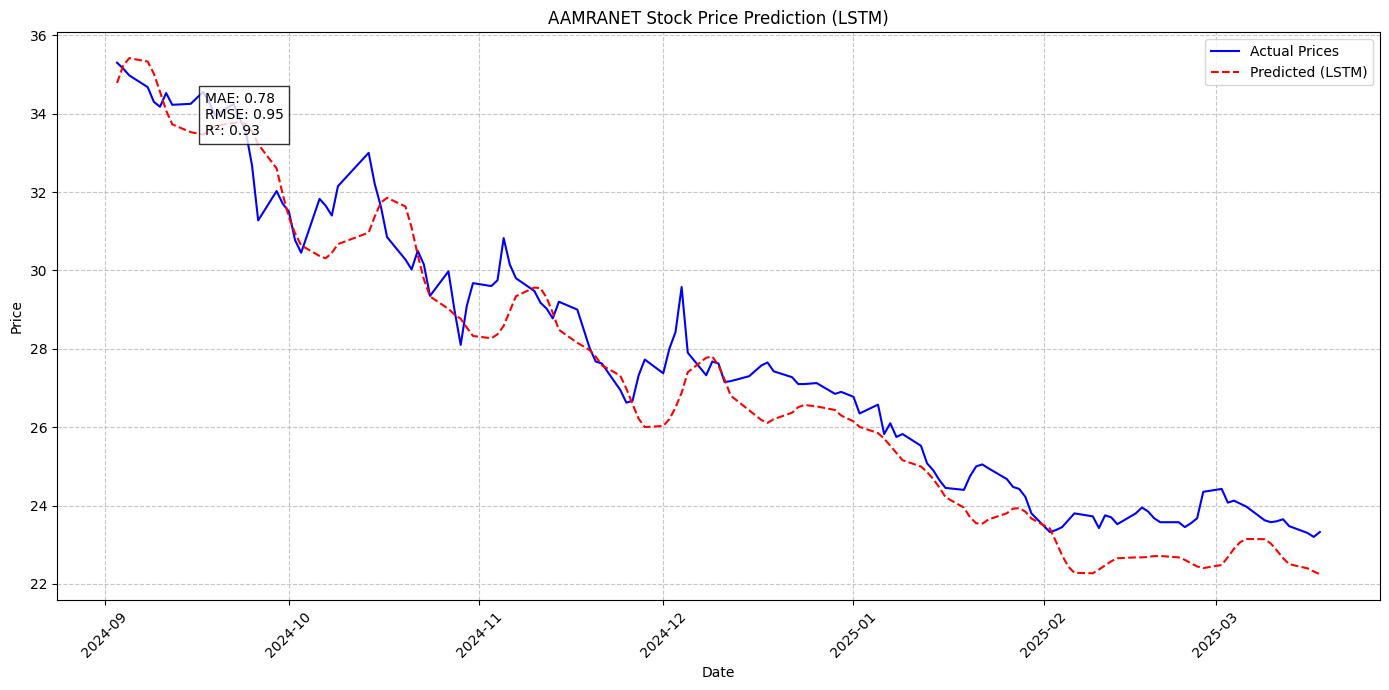


Metrics for LSTM:
MAE: 0.7840
RMSE: 0.9536
R2 Score: 0.9285

Training Bi-LSTM model...
5/5 [==============================] - 2s 18ms/step


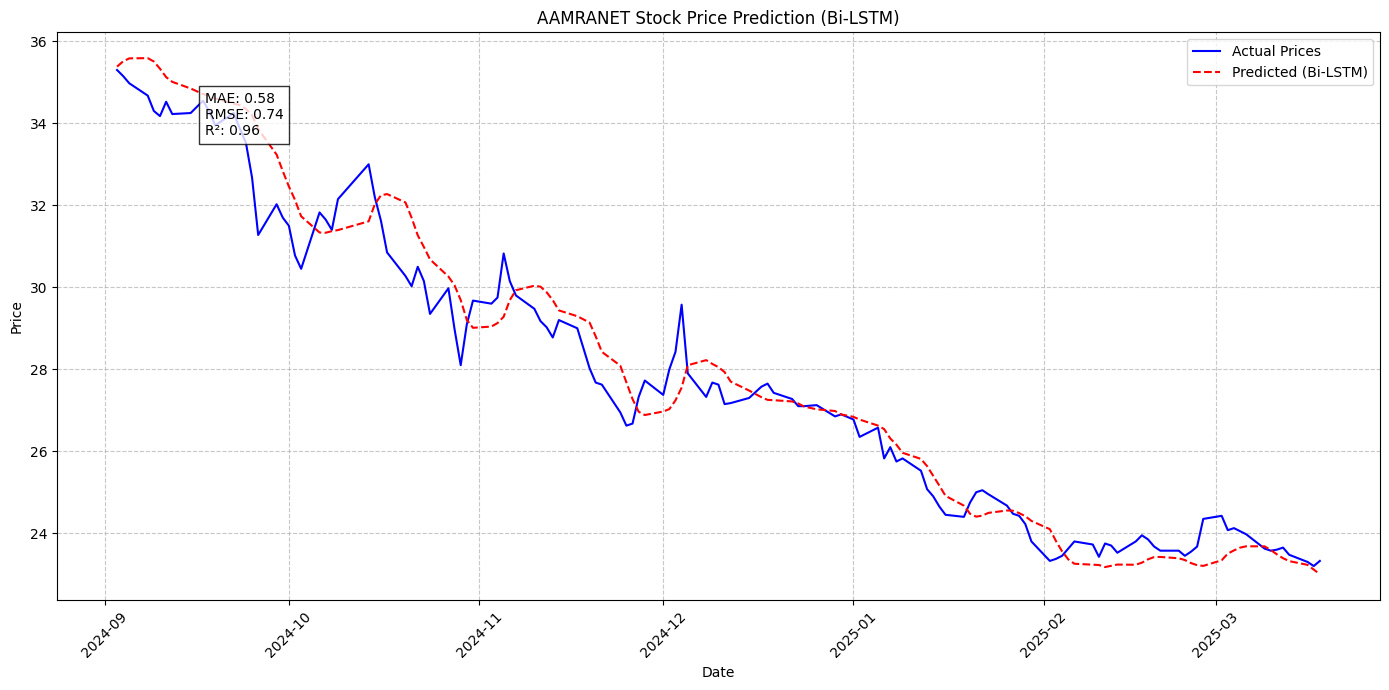


Metrics for Bi-LSTM:
MAE: 0.5801
RMSE: 0.7442
R2 Score: 0.9564

Training GRU model...
5/5 [==============================] - 1s 11ms/step


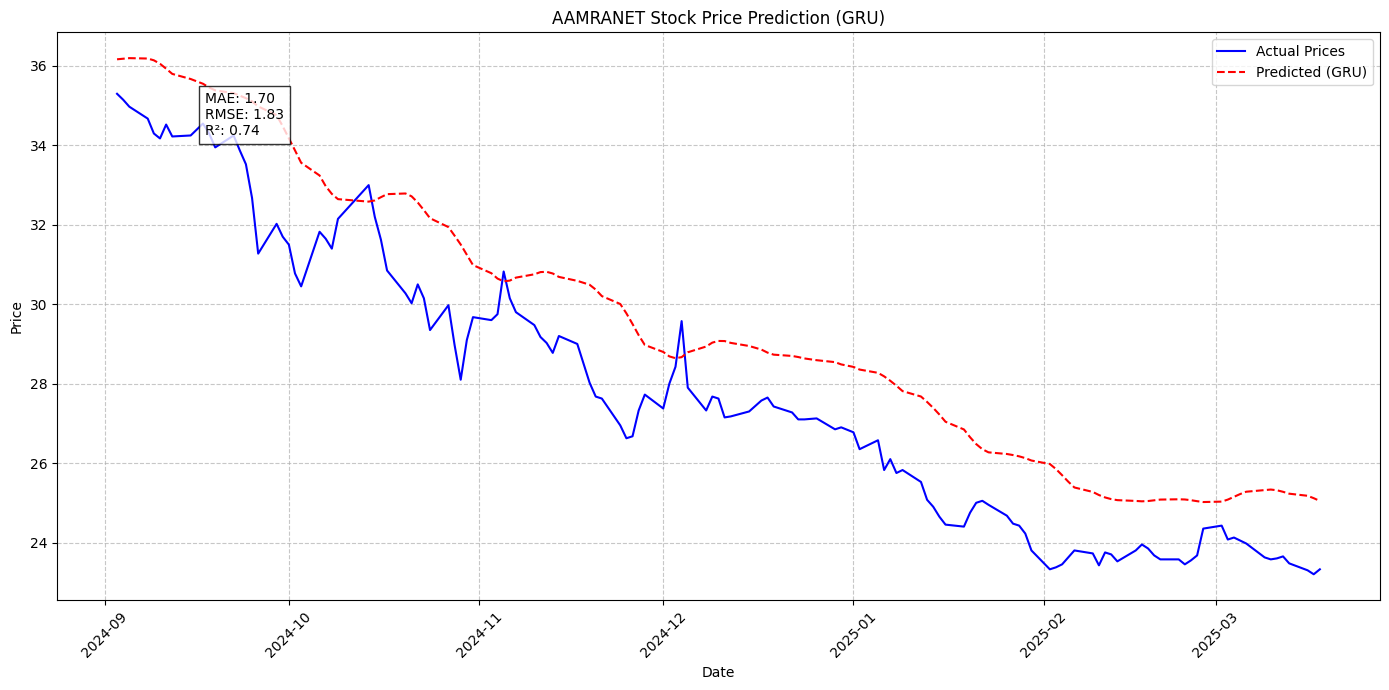


Metrics for GRU:
MAE: 1.7030
RMSE: 1.8283
R2 Score: 0.7370

Training ARIMA model...


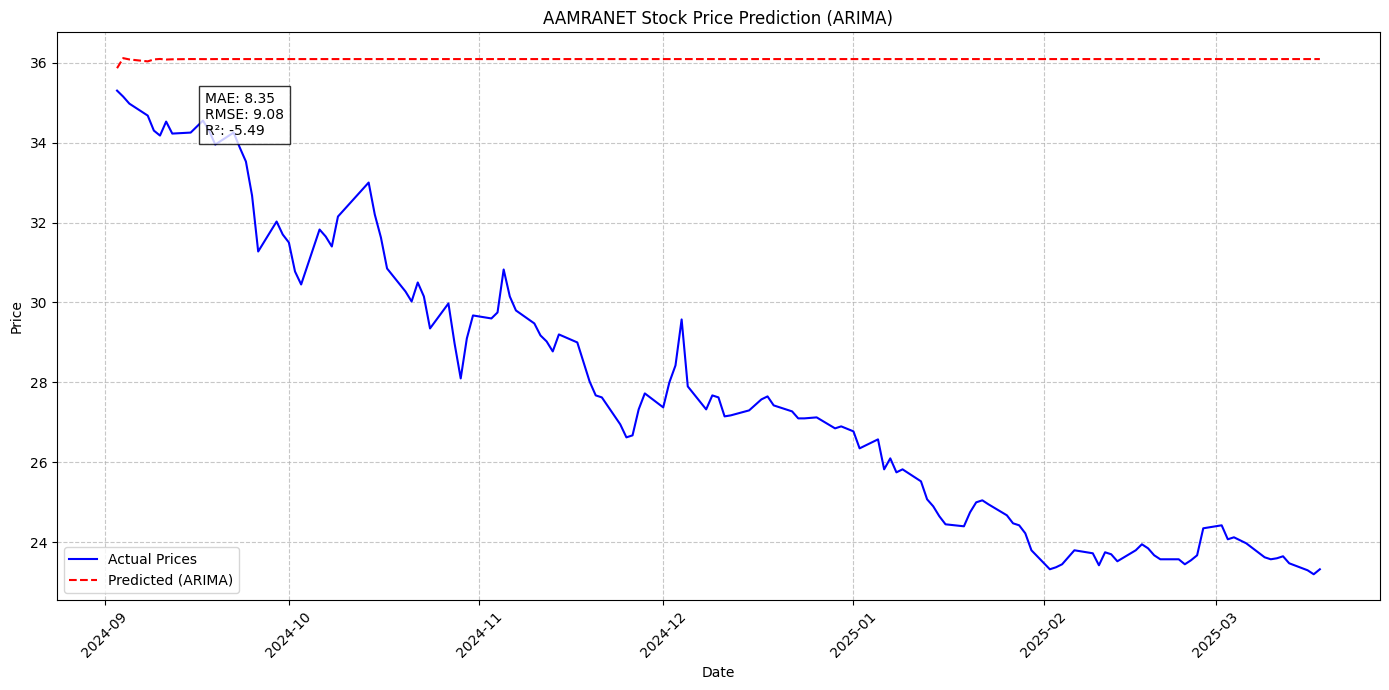


Metrics for ARIMA:
MAE: 8.3533
RMSE: 9.0842
R2 Score: -5.4913

Training XGBoost model...


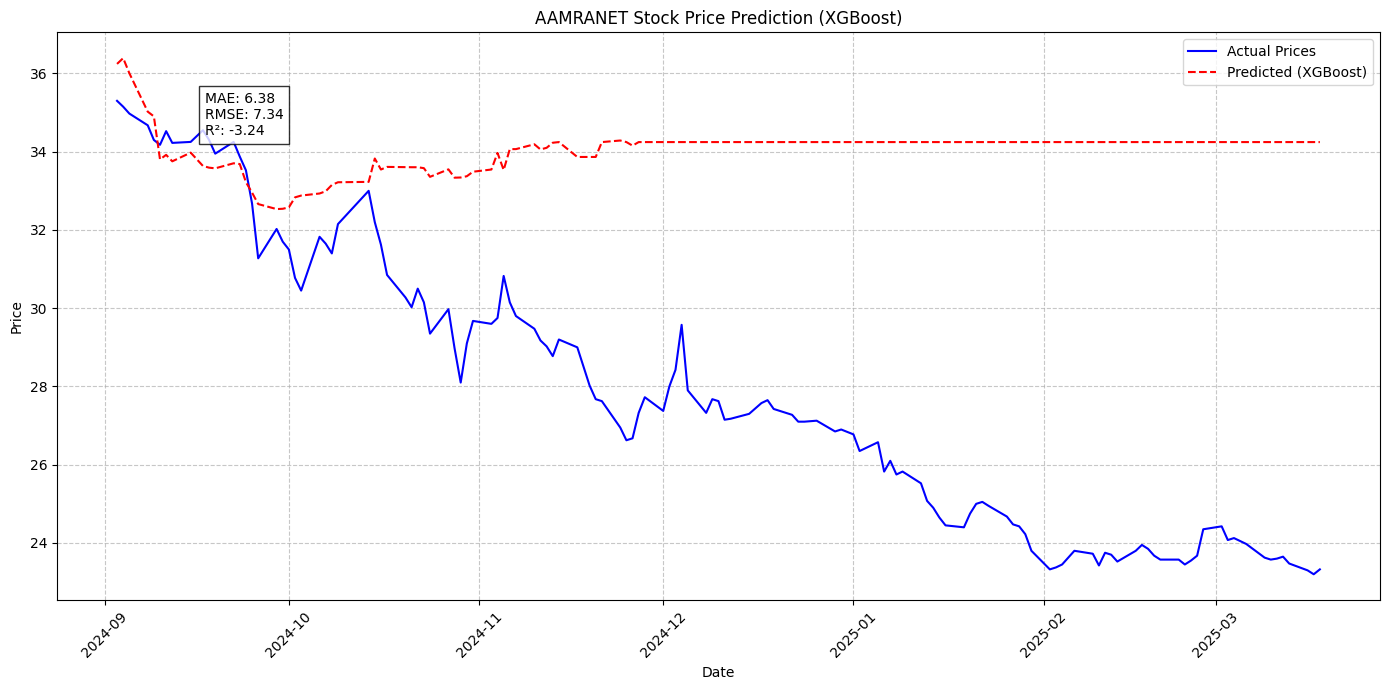


Metrics for XGBoost:
MAE: 6.3764
RMSE: 7.3399
R2 Score: -3.2378

Training SVR model...


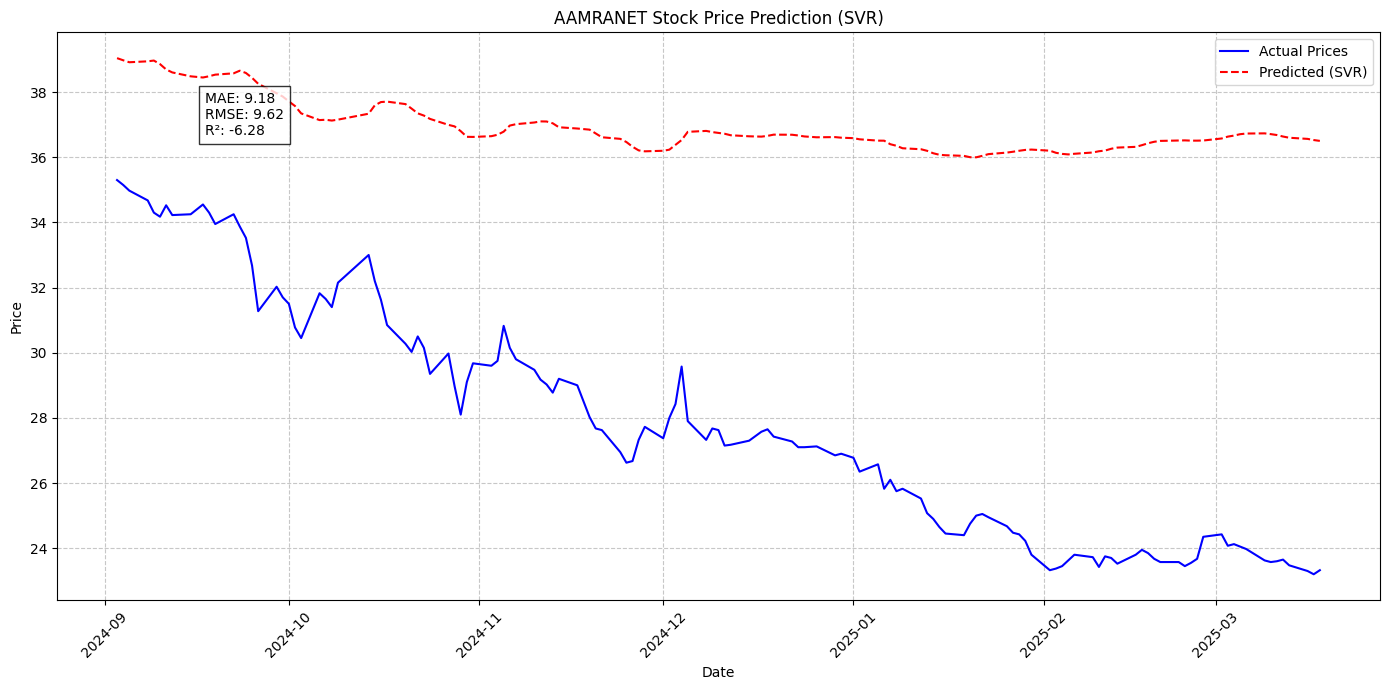


Metrics for SVR:
MAE: 9.1761
RMSE: 9.6205
R2 Score: -6.2803

Processing AAMRATECH...
Epoch 1/100
17/17 [==============================] - 6s 38ms/step - loss: 0.0439
Epoch 2/100
17/17 [==============================] - 1s 40ms/step - loss: 0.0096
Epoch 3/100
17/17 [==============================] - 1s 38ms/step - loss: 0.0075
Epoch 4/100
17/17 [==============================] - 1s 41ms/step - loss: 0.0060
Epoch 5/100
17/17 [==============================] - 1s 41ms/step - loss: 0.0067
Epoch 6/100
17/17 [==============================] - 1s 40ms/step - loss: 0.0064
Epoch 7/100
17/17 [==============================] - 1s 35ms/step - loss: 0.0069
Epoch 8/100
17/17 [==============================] - 1s 39ms/step - loss: 0.0064
Epoch 9/100
17/17 [==============================] - 1s 41ms/step - loss: 0.0062
Epoch 10/100
17/17 [==============================] - 1s 40ms/step - loss: 0.0065
Epoch 11/100
17/17 [==============================] - 1s 40ms/step - loss: 0.0058
Epoch 12/100
17/17 [=

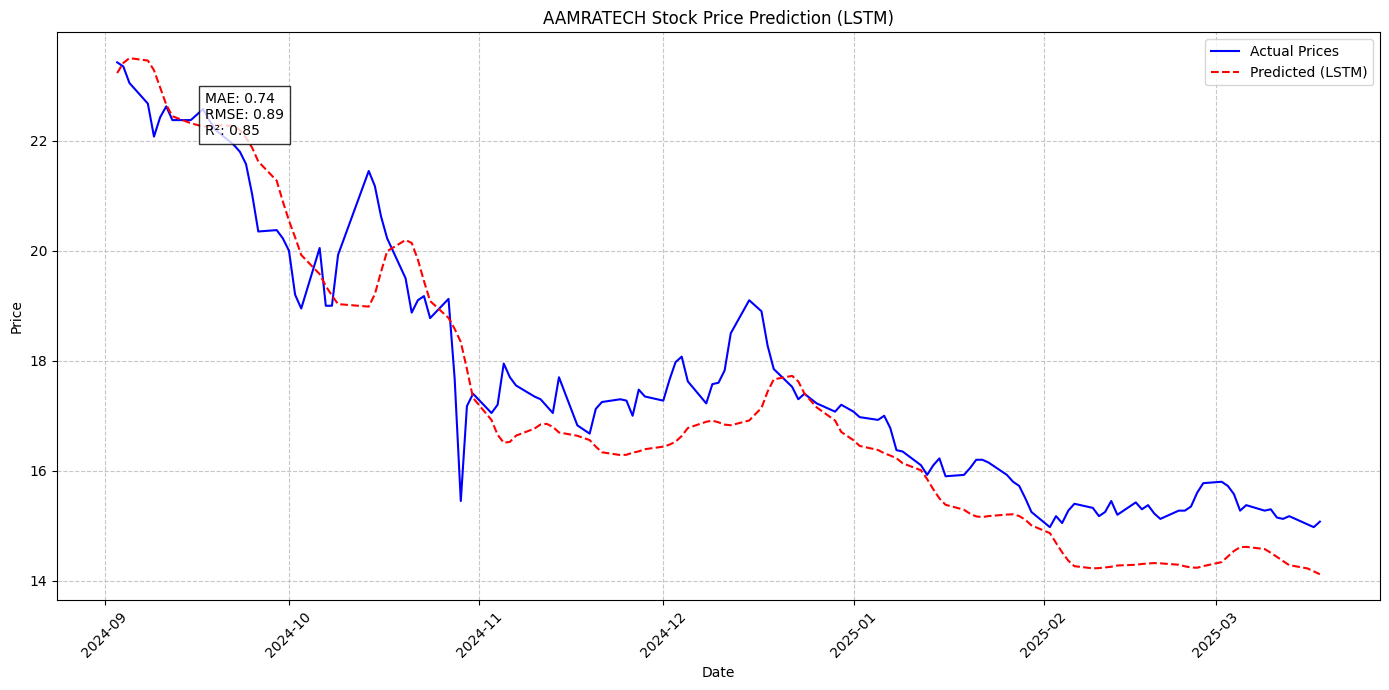


Metrics for LSTM:
MAE: 0.7448
RMSE: 0.8920
R2 Score: 0.8505

Training Bi-LSTM model...
5/5 [==============================] - 2s 16ms/step


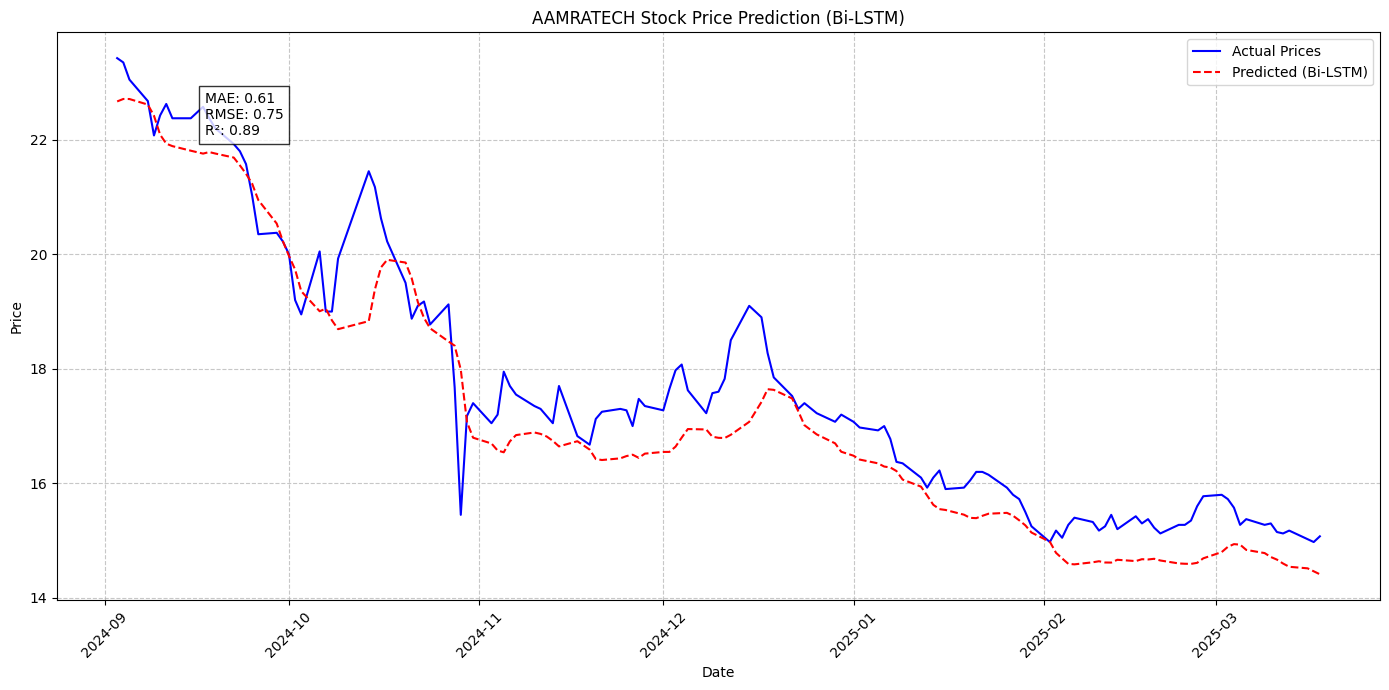


Metrics for Bi-LSTM:
MAE: 0.6100
RMSE: 0.7478
R2 Score: 0.8949

Training GRU model...
5/5 [==============================] - 2s 25ms/step


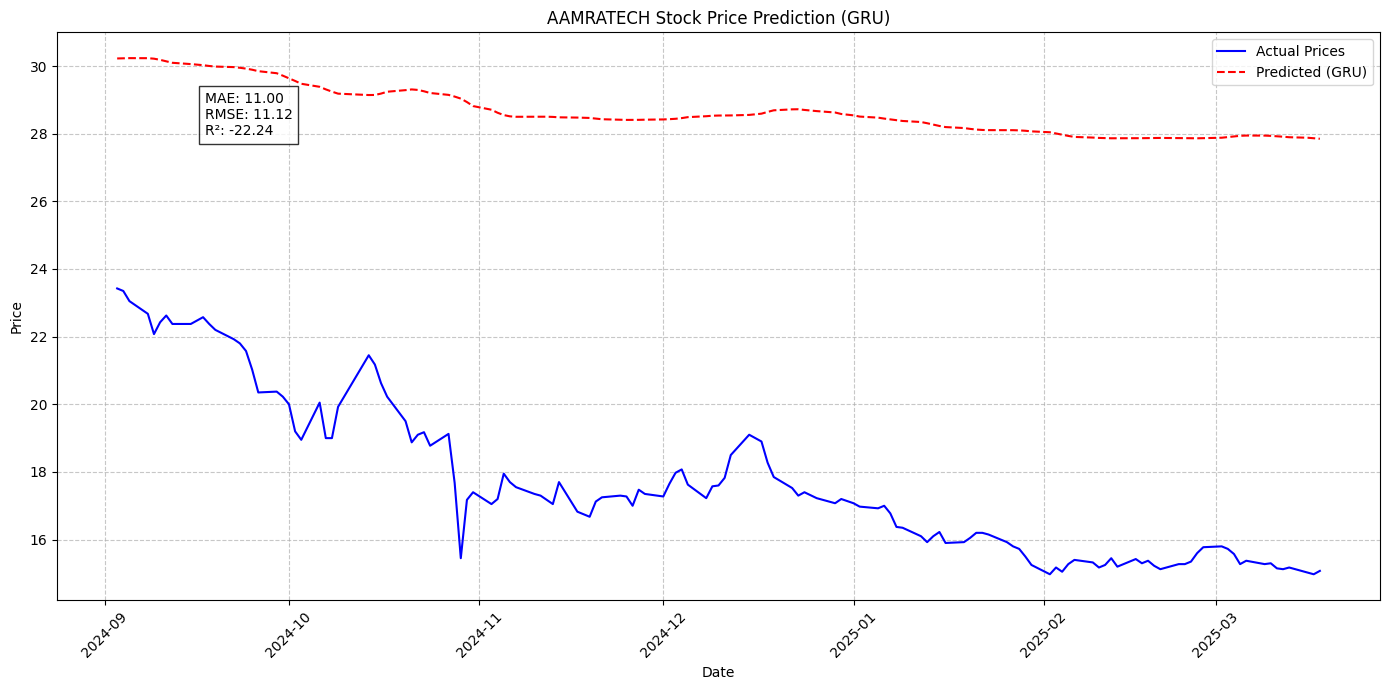


Metrics for GRU:
MAE: 11.0010
RMSE: 11.1219
R2 Score: -22.2402

Training ARIMA model...


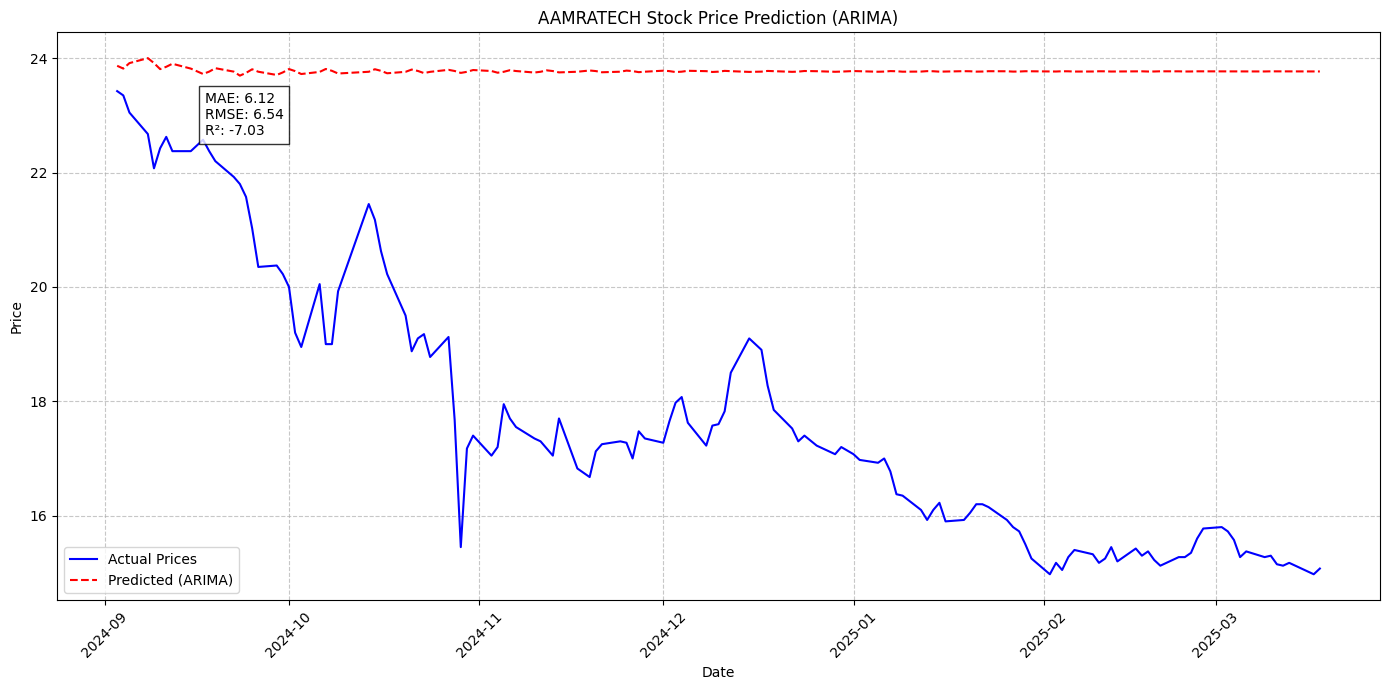


Metrics for ARIMA:
MAE: 6.1239
RMSE: 6.5390
R2 Score: -7.0334

Training XGBoost model...


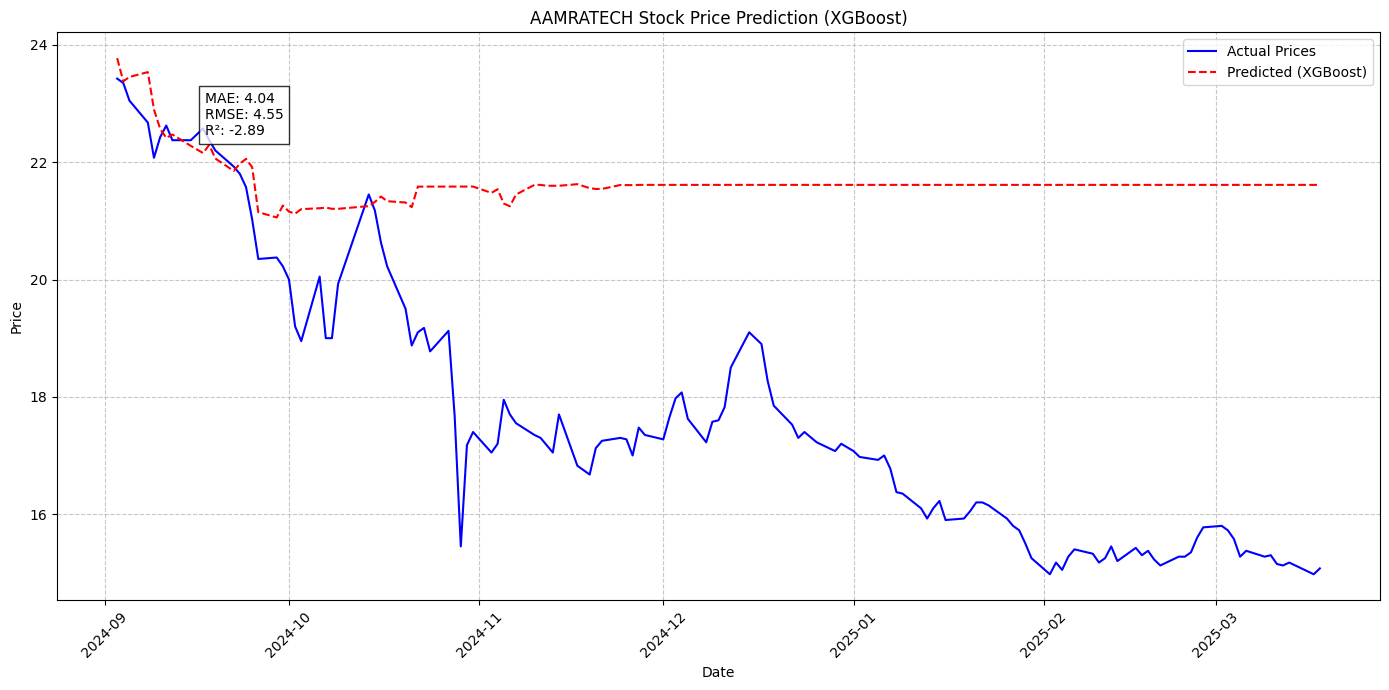


Metrics for XGBoost:
MAE: 4.0357
RMSE: 4.5490
R2 Score: -2.8879

Training SVR model...


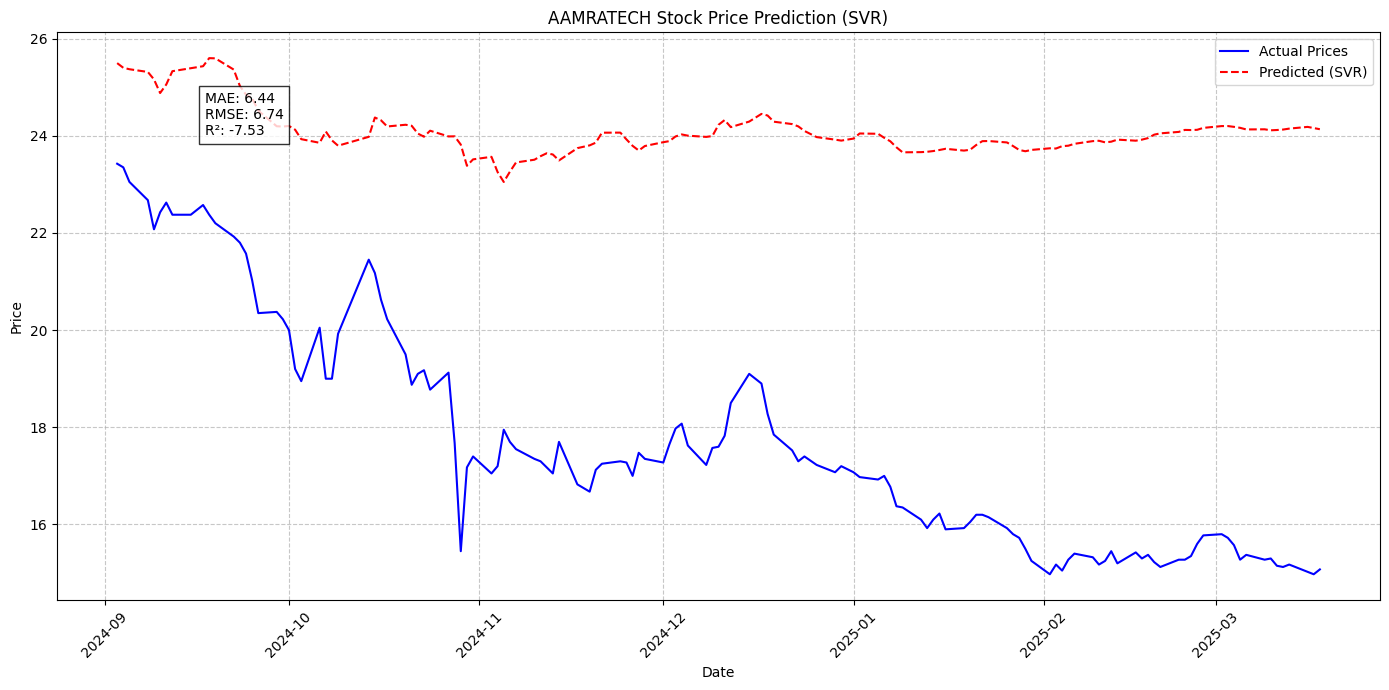


Metrics for SVR:
MAE: 6.4419
RMSE: 6.7382
R2 Score: -7.5303

Prediction results saved to 'stock_prediction_results_all_models.csv'
Detailed predictions saved to 'full_predictions_all_models.csv'


In [1]:
# iteration 2 debugged and GRU updated

# --- Install Required Libraries with Specific Versions ---
!pip install -q numpy==1.23.5 pandas==1.5.3 matplotlib==3.7.1 scikit-learn==1.2.2 
!pip install -q statsmodels==0.14.0 pmdarima==2.0.3 xgboost==1.7.5 
!pip install -q tensorflow==2.12.0 keras==2.12.0

# --- Import Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from xgboost import XGBRegressor
from sklearn.svm import SVR
from statsmodels.tsa.stattools import adfuller
from itertools import product
import warnings
import math
warnings.filterwarnings("ignore")

# --- Data Loading and Preparation ---
def load_data(filepath):
    """Load and preprocess the stock data"""
    df = pd.read_csv(filepath, parse_dates=['Date'], dayfirst=True)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])
    df = df.sort_values(['Company', 'Date'])
    
    numeric_cols = ['Open', 'Close', 'High', 'Low', 'Volume']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    df = df.dropna(subset=numeric_cols)
    
    return df

def prepare_sequence_data(company_data, look_back=30):
    """Prepare data for sequence models (LSTM, Bi-LSTM, GRU)"""
    company_data['ohlc_avg'] = company_data[['Open', 'High', 'Low', 'Close']].mean(axis=1)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(company_data[['ohlc_avg']])
    
    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i, 0])
        y.append(scaled_data[i, 0])
    
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    return X, y, scaler, company_data

def prepare_tabular_data(company_data, look_back=30):
    """Prepare data for non-sequence models (XGBoost, SVR)"""
    company_data['ohlc_avg'] = company_data[['Open', 'High', 'Low', 'Close']].mean(axis=1)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(company_data[['ohlc_avg']])
    
    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i, 0])
        y.append(scaled_data[i, 0])
    
    return np.array(X), np.array(y), scaler, company_data

# --- Learning Rate Schedule for GRU ---
def lr_schedule(epoch, lr):
    """Learning rate schedule with decay"""
    if epoch < 10:
        return lr
    else:
        return lr * math.exp(-0.1)

# --- Enhanced Model Definitions ---
def train_gru(X_train, y_train, epochs=100, batch_size=150):
    """Enhanced GRU implementation with updated optimizer"""
    model = Sequential([
        GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'),
        Dropout(0.2),
        GRU(units=50, return_sequences=True, activation='tanh'),
        Dropout(0.2),
        GRU(units=50, return_sequences=True, activation='tanh'),
        Dropout(0.2),
        GRU(units=50, activation='tanh'),
        Dropout(0.2),
        Dense(units=1)
    ])
    
    # Updated optimizer without deprecated decay parameter
    optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=False)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    callbacks = [
        EarlyStopping(monitor='loss', patience=15, restore_best_weights=True),
        LearningRateScheduler(lr_schedule)
    ]
    
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              callbacks=callbacks, verbose=1)
    return model

def train_lstm(X_train, y_train, epochs=100, batch_size=32):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.3),
        LSTM(64, return_sequences=True),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.3),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              callbacks=[early_stopping], verbose=1)
    return model

def train_bilstm(X_train, y_train, epochs=100, batch_size=32):
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.3),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(64)),
        Dropout(0.3),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              callbacks=[early_stopping], verbose=1)
    return model

def train_arima(train_data):
    series = train_data['ohlc_avg'] if isinstance(train_data, pd.DataFrame) else train_data
    d = find_integration_order(series)
    p, _, q = select_arima_order(series, d)
    model = ARIMA(series, order=(p, d, q))
    return model.fit()

def train_xgboost(X_train, y_train):
    model = XGBRegressor(n_estimators=100, learning_rate=0.1)
    model.fit(X_train, y_train)
    return model

def train_svr(X_train, y_train):
    model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
    model.fit(X_train, y_train)
    return model

# --- Main Prediction Function ---
def predict_stock_prices(df, look_back=30):
    companies = df['Company'].unique()
    results = {}
    
    for company in companies:
        try:
            print(f"\n{'='*50}\nProcessing {company}...\n{'='*50}")
            company_data = df[df['Company'] == company].copy()
            
            if len(company_data) < look_back * 2:
                print(f"Skipping {company} - insufficient data ({len(company_data)} records)")
                continue
                
            X_seq, y_seq, seq_scaler, _ = prepare_sequence_data(company_data, look_back)
            X_tab, y_tab, tab_scaler, _ = prepare_tabular_data(company_data, look_back)
            
            split = int(0.8 * len(X_seq))
            X_seq_train, X_seq_test = X_seq[:split], X_seq[split:]
            y_seq_train, y_seq_test = y_seq[:split], y_seq[split:]
            X_tab_train, X_tab_test = X_tab[:split], X_tab[split:]
            y_tab_train, y_tab_test = y_tab[:split], y_tab[split:]
            
            test_dates = company_data['Date'].iloc[split+look_back:].values
            
            models = {
                'LSTM': train_lstm(X_seq_train, y_seq_train),
                'Bi-LSTM': train_bilstm(X_seq_train, y_seq_train),
                'GRU': train_gru(X_seq_train, y_seq_train),
                'ARIMA': train_arima(company_data.iloc[:split + look_back]),
                'XGBoost': train_xgboost(X_tab_train, y_tab_train),
                'SVR': train_svr(X_tab_train, y_tab_train)
            }
            
            company_results = {}
            
            for model_name, model in models.items():
                try:
                    print(f"\nTraining {model_name} model...")
                    
                    if model_name in ['LSTM', 'Bi-LSTM', 'GRU']:
                        predicted = model.predict(X_seq_test)
                        predicted_prices = seq_scaler.inverse_transform(predicted)
                        actual_prices = seq_scaler.inverse_transform(y_seq_test.reshape(-1, 1))
                    elif model_name == 'ARIMA':
                        forecast = model.get_forecast(steps=len(X_seq_test))
                        predicted_prices = forecast.predicted_mean.values.reshape(-1, 1)
                        actual_prices = seq_scaler.inverse_transform(y_seq_test.reshape(-1, 1))
                    else:
                        predicted = model.predict(X_tab_test)
                        predicted_prices = tab_scaler.inverse_transform(predicted.reshape(-1, 1))
                        actual_prices = tab_scaler.inverse_transform(y_tab_test.reshape(-1, 1))
                    
                    mae = mean_absolute_error(actual_prices, predicted_prices)
                    rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
                    r2 = r2_score(actual_prices, predicted_prices)
                    
                    company_results[model_name] = {
                        'predicted': predicted_prices.flatten(),
                        'metrics': {'MAE': mae, 'RMSE': rmse, 'R2': r2}
                    }
                    
                    plt.figure(figsize=(14, 7))
                    plt.plot(test_dates, actual_prices, label='Actual Prices', color='blue')
                    plt.plot(test_dates, predicted_prices, label=f'Predicted ({model_name})', color='red', linestyle='--')
                    plt.title(f'{company} Stock Price Prediction ({model_name})')
                    plt.xlabel('Date')
                    plt.ylabel('Price')
                    plt.legend()
                    plt.grid(True, linestyle='--', alpha=0.7)
                    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
                    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
                    plt.xticks(rotation=45)
                    plt.figtext(0.15, 0.8, f"MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.2f}", 
                               bbox=dict(facecolor='white', alpha=0.8))
                    plt.tight_layout()
                    plt.show()
                    
                    print(f"\nMetrics for {model_name}:")
                    print(f"MAE: {mae:.4f}\nRMSE: {rmse:.4f}\nR2 Score: {r2:.4f}")
                    
                except Exception as e:
                    print(f"\nError processing {model_name} for {company}: {str(e)}")
                    company_results[model_name] = None
            
            results[company] = {
                'dates': test_dates,
                'actual': actual_prices.flatten(),
                'models': company_results
            }
            
        except Exception as e:
            print(f"\nError processing {company}: {str(e)}")
    
    return results

# --- Helper Functions for ARIMA ---
def find_integration_order(series):
    """Determine order of integration (d) using ADF test"""
    d = 0
    while True:
        result = adfuller(series, autolag='AIC')
        if result[1] <= 0.05:
            return d
        series = series.diff().dropna()
        d += 1
        if d >= 2:
            return d

def select_arima_order(train, d):
    """Select best ARIMA (p,d,q) parameters using AIC"""
    ps = range(0, 6)
    qs = range(0, 6)
    best_aic = np.inf
    best_order = (0, d, 0)
    
    for p, q in product(ps, qs):
        if (p==0) and (q==0):
            continue
        try:
            model = ARIMA(train, order=(p, d, q))
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, d, q)
        except:
            continue
    return best_order

# --- Main Execution ---
if __name__ == "__main__":
    file_path = "combined_stock_data_test.csv"
    print("\nLoading data...")
    stock_data = load_data(file_path)
    
    print("\nStarting predictions...")
    prediction_results = predict_stock_prices(stock_data)
    
    results_df = pd.DataFrame()
    full_results = []
    
    for company, data in prediction_results.items():
        for model_name, model_data in data['models'].items():
            if model_data is not None:
                temp_df = pd.DataFrame({
                    'Company': company,
                    'Model': model_name,
                    **model_data['metrics']
                }, index=[0])
                results_df = pd.concat([results_df, temp_df], ignore_index=True)
        
        if any(model_data is not None for model_data in data['models'].values()):
            temp_df = pd.DataFrame({
                'Company': company,
                'Date': data['dates'],
                'Actual_Price': data['actual']
            })
            
            for model_name, model_data in data['models'].items():
                if model_data is not None:
                    temp_df[f'{model_name}_Predicted'] = model_data['predicted']
            
            full_results.append(temp_df)
    
    if len(results_df) > 0:
        results_df.to_csv('stock_prediction_results_all_models.csv', index=False)
        print("\nPrediction results saved to 'stock_prediction_results_all_models.csv'")
    else:
        print("\nNo prediction results to save - all models failed")
    
    if len(full_results) > 0:
        pd.concat(full_results).to_csv('full_predictions_all_models.csv', index=False)
        print("Detailed predictions saved to 'full_predictions_all_models.csv'")
    else:
        print("No detailed predictions to save - all models failed")

You should consider upgrading via the 'C:\Users\SHEPHERD\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\SHEPHERD\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\SHEPHERD\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.



Loading data...

Starting predictions...

Processing AAMRANET...


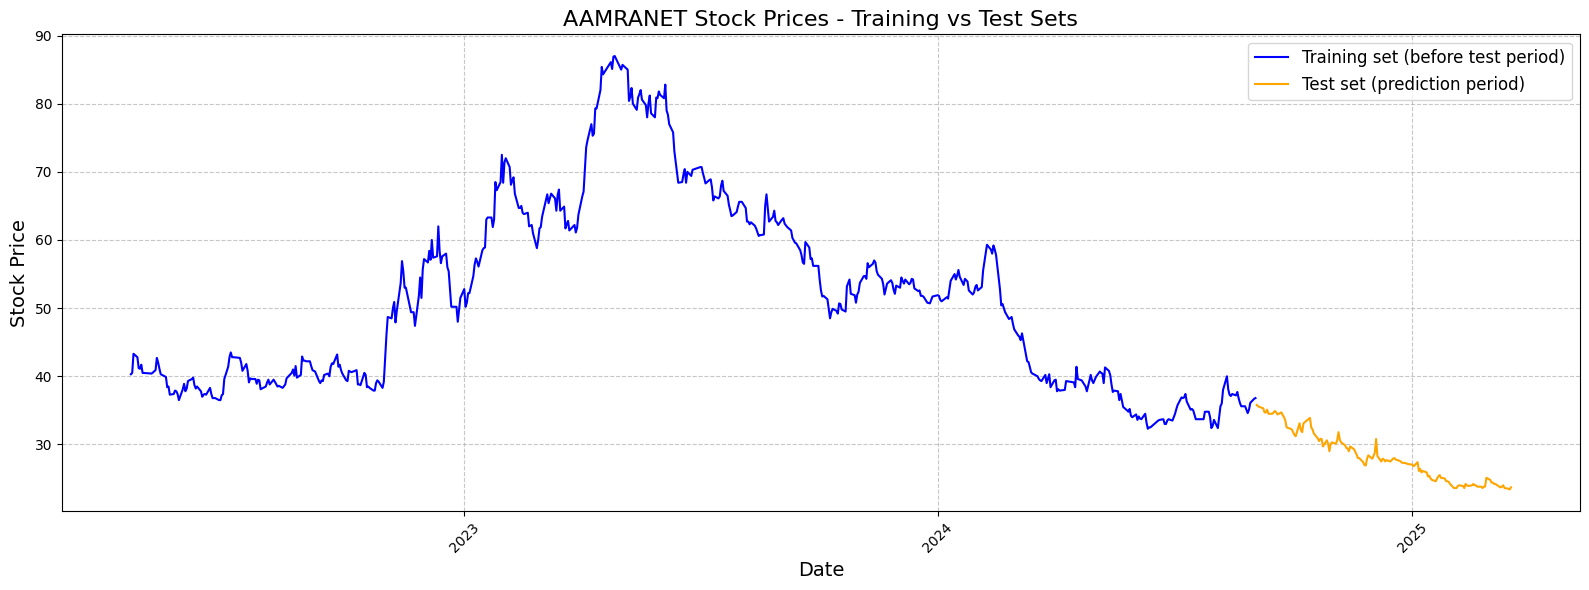

Epoch 1/100
17/17 [==============================] - 7s 51ms/step - loss: 0.0702
Epoch 2/100
17/17 [==============================] - 1s 49ms/step - loss: 0.0135
Epoch 3/100
17/17 [==============================] - 1s 50ms/step - loss: 0.0098
Epoch 4/100
17/17 [==============================] - 1s 48ms/step - loss: 0.0083
Epoch 5/100
17/17 [==============================] - 1s 47ms/step - loss: 0.0085
Epoch 6/100
17/17 [==============================] - 1s 47ms/step - loss: 0.0078
Epoch 7/100
17/17 [==============================] - 1s 50ms/step - loss: 0.0069
Epoch 8/100
17/17 [==============================] - 1s 50ms/step - loss: 0.0075
Epoch 9/100
17/17 [==============================] - 1s 49ms/step - loss: 0.0076
Epoch 10/100
17/17 [==============================] - 1s 54ms/step - loss: 0.0062
Epoch 11/100
17/17 [==============================] - 1s 49ms/step - loss: 0.0060
Epoch 12/100
17/17 [==============================] - 1s 48ms/step - loss: 0.0068
Epoch 13/100
17/17 [=====

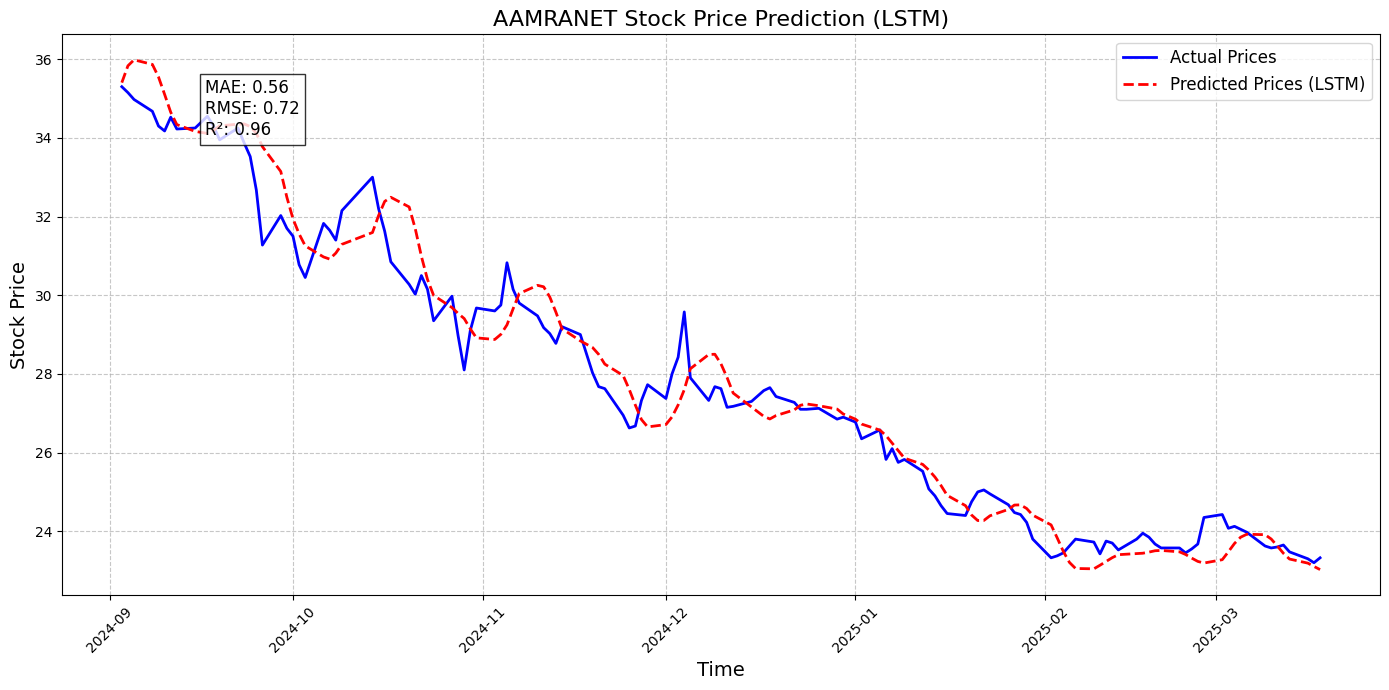


Metrics for LSTM:
MAE: 0.5632
RMSE: 0.7244
R2 Score: 0.9587

Training Bi-LSTM model...
5/5 [==============================] - 3s 80ms/step


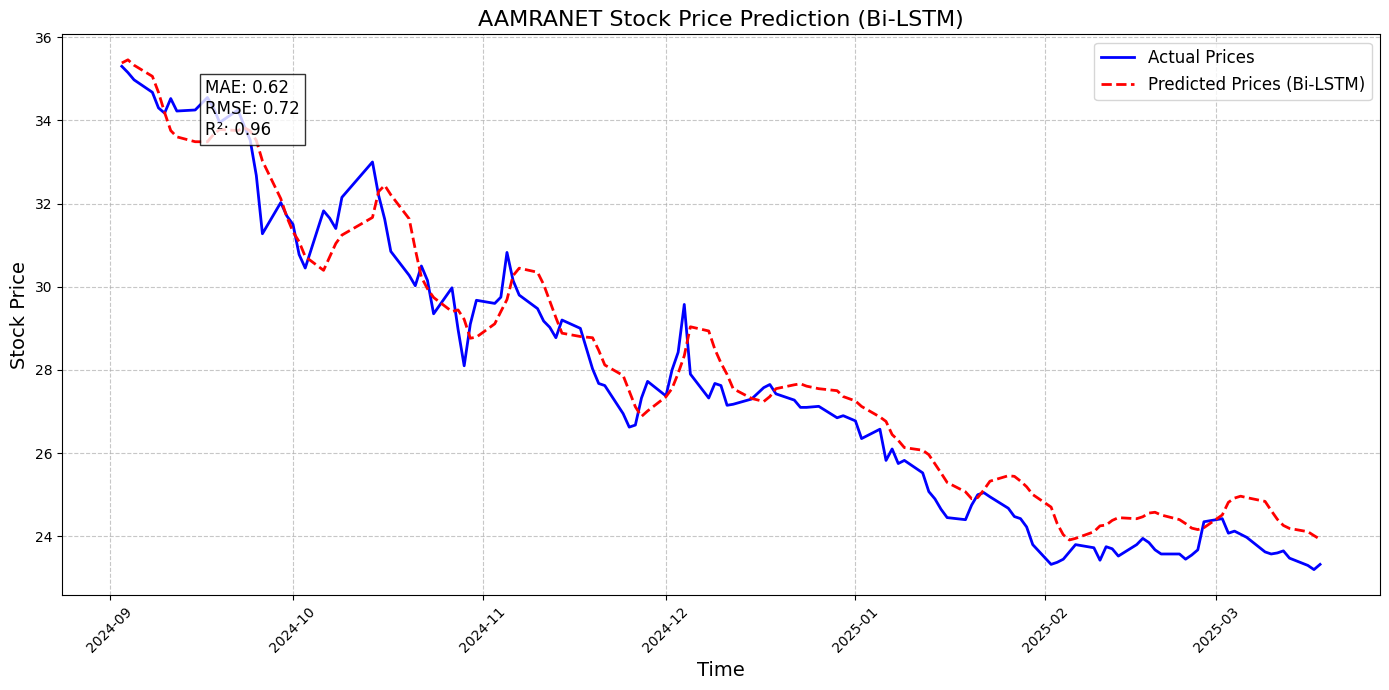


Metrics for Bi-LSTM:
MAE: 0.6229
RMSE: 0.7203
R2 Score: 0.9592

Training GRU model...
5/5 [==============================] - 2s 35ms/step


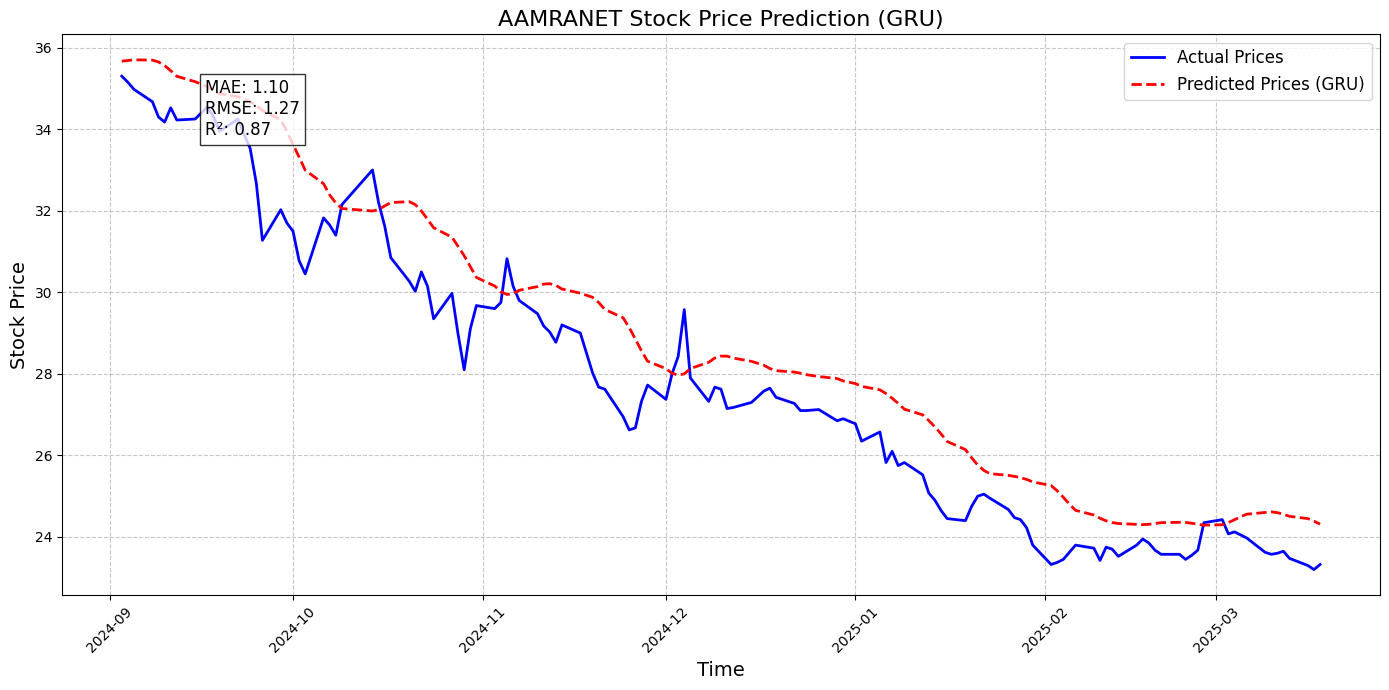


Metrics for GRU:
MAE: 1.1043
RMSE: 1.2694
R2 Score: 0.8732

Training ARIMA model...


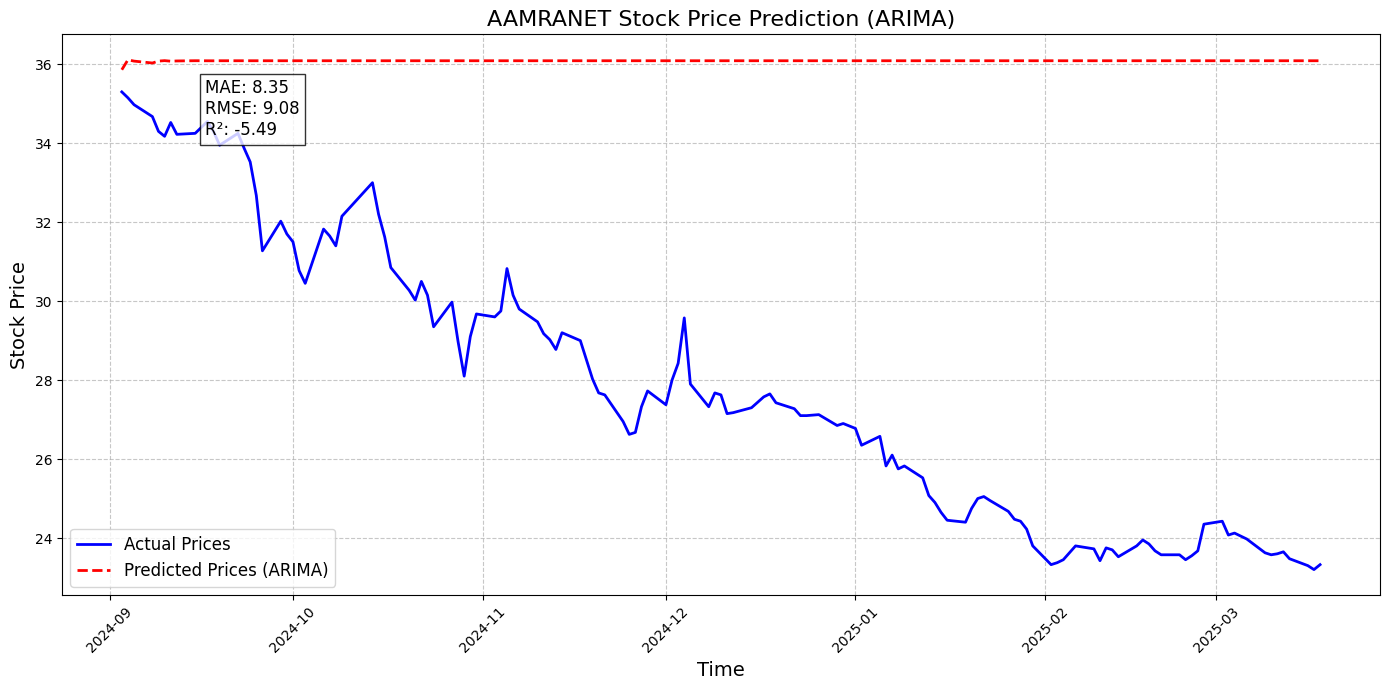


Metrics for ARIMA:
MAE: 8.3533
RMSE: 9.0842
R2 Score: -5.4913

Training XGBoost model...


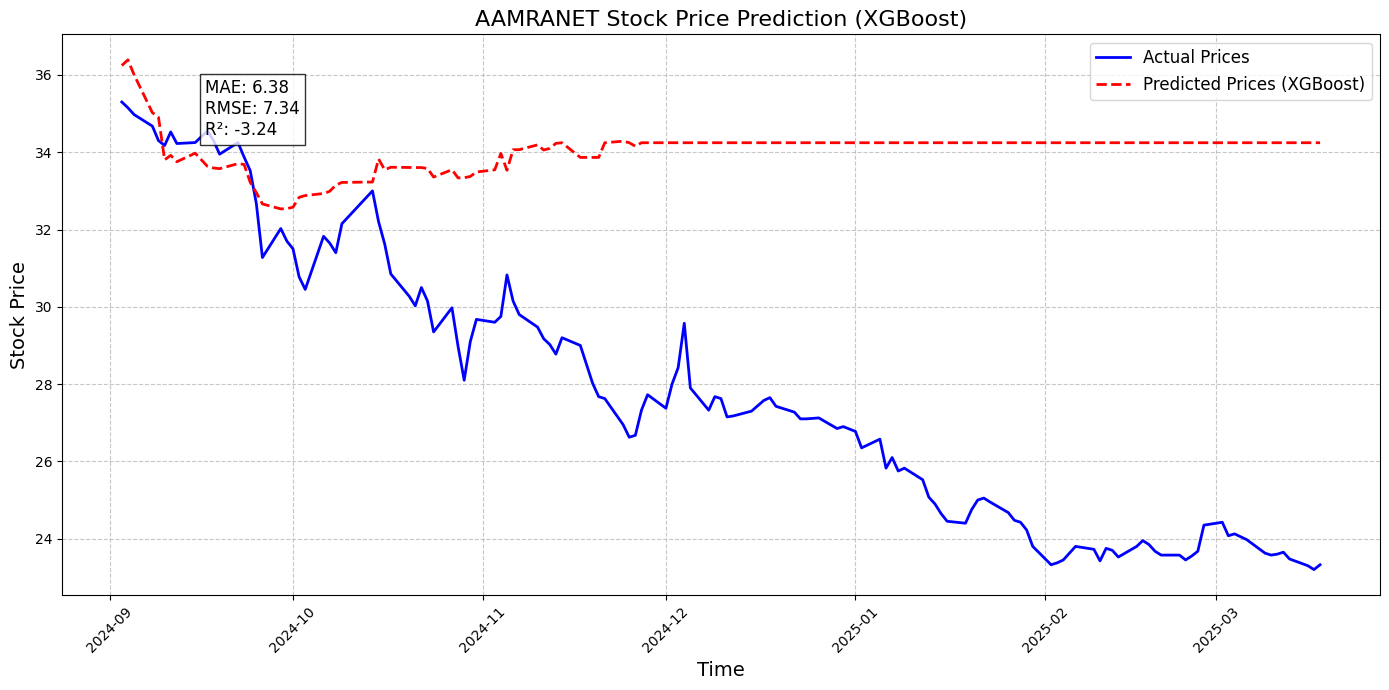


Metrics for XGBoost:
MAE: 6.3764
RMSE: 7.3399
R2 Score: -3.2378

Training SVR model...


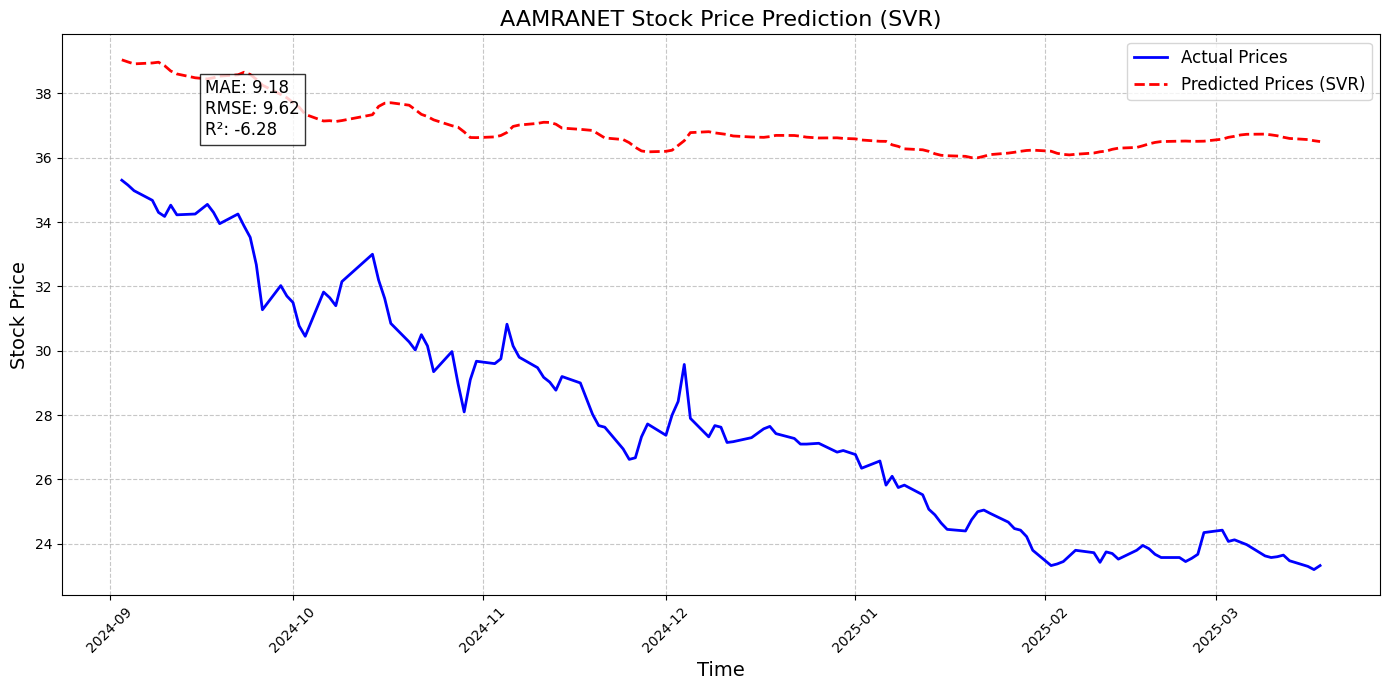


Metrics for SVR:
MAE: 9.1761
RMSE: 9.6205
R2 Score: -6.2803

Processing AAMRATECH...


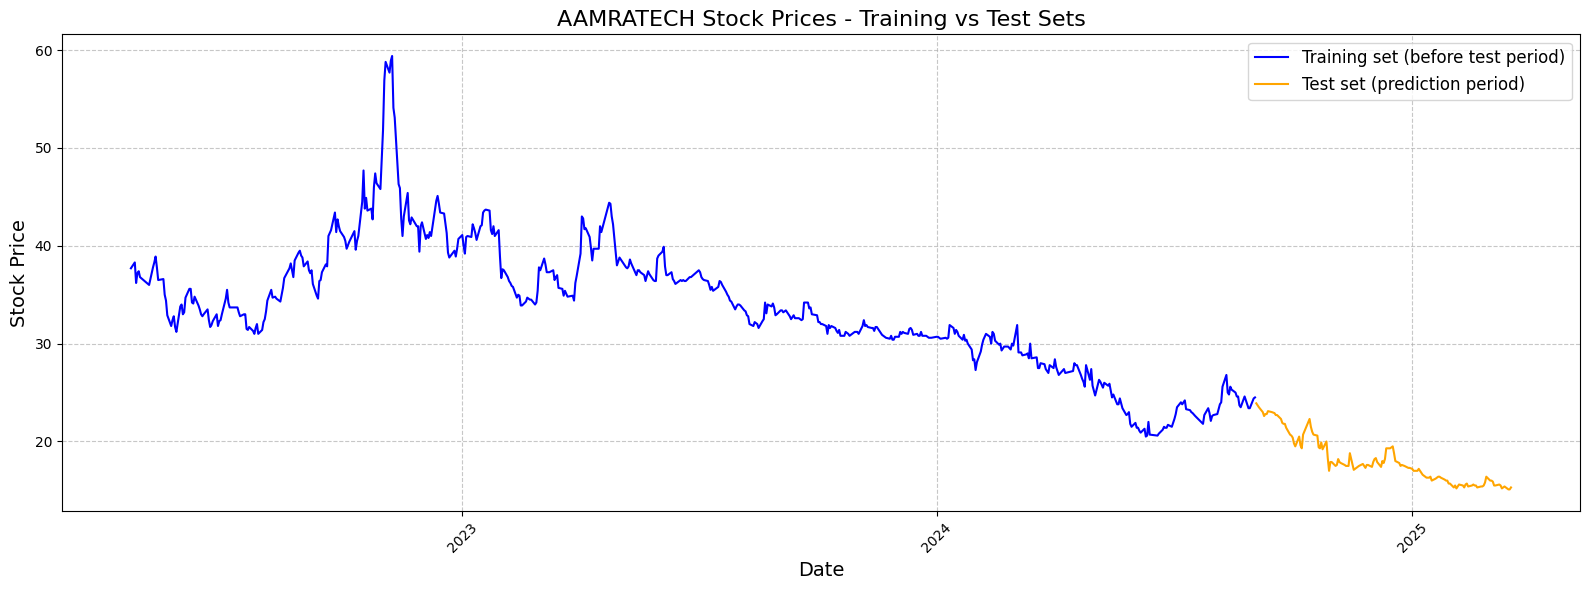

Epoch 1/100
17/17 [==============================] - 8s 89ms/step - loss: 0.0442
Epoch 2/100
17/17 [==============================] - 2s 91ms/step - loss: 0.0115
Epoch 3/100
17/17 [==============================] - 2s 90ms/step - loss: 0.0078
Epoch 4/100
17/17 [==============================] - 2s 89ms/step - loss: 0.0077
Epoch 5/100
17/17 [==============================] - 1s 87ms/step - loss: 0.0066
Epoch 6/100
17/17 [==============================] - 2s 99ms/step - loss: 0.0056
Epoch 7/100
17/17 [==============================] - 2s 96ms/step - loss: 0.0062
Epoch 8/100
17/17 [==============================] - 1s 84ms/step - loss: 0.0059
Epoch 9/100
17/17 [==============================] - 2s 90ms/step - loss: 0.0070
Epoch 10/100
17/17 [==============================] - 1s 78ms/step - loss: 0.0076
Epoch 11/100
17/17 [==============================] - 1s 87ms/step - loss: 0.0058
Epoch 12/100
17/17 [==============================] - 1s 81ms/step - loss: 0.0056
Epoch 13/100
17/17 [=====

In [ ]:
# iteration 3 - 2 more plots added
# -*- coding: utf-8 -*-
"""Stock Price Prediction with LSTM, GRU, RNN and Traditional Models"""

# --- Install Required Libraries ---
!pip install -q numpy==1.23.5 pandas==1.5.3 matplotlib==3.7.1 scikit-learn==1.2.2 
!pip install -q statsmodels==0.14.0 pmdarima==2.0.3 xgboost==1.7.5 
!pip install -q tensorflow==2.12.0 keras==2.12.0

# --- Import Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from xgboost import XGBRegressor
from sklearn.svm import SVR
from statsmodels.tsa.stattools import adfuller
from itertools import product
import warnings
import math
warnings.filterwarnings("ignore")

# --- Helper Functions ---
def lr_schedule(epoch, lr):
    """Learning rate schedule with decay"""
    if epoch < 10:
        return lr
    else:
        return lr * math.exp(-0.1)

def find_integration_order(series):
    """Determine order of integration (d) using ADF test"""
    d = 0
    while True:
        result = adfuller(series, autolag='AIC')
        if result[1] <= 0.05:
            return d
        series = series.diff().dropna()
        d += 1
        if d >= 2:
            return d

def select_arima_order(train, d):
    """Select best ARIMA (p,d,q) parameters using AIC"""
    ps = range(0, 6)
    qs = range(0, 6)
    best_aic = np.inf
    best_order = (0, d, 0)
    
    for p, q in product(ps, qs):
        if (p==0) and (q==0):
            continue
        try:
            model = ARIMA(train, order=(p, d, q))
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, d, q)
        except:
            continue
    return best_order

# --- Data Loading and Preparation ---
def load_data(filepath):
    """Load and preprocess the stock data"""
    df = pd.read_csv(filepath, parse_dates=['Date'], dayfirst=True)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])
    df = df.sort_values(['Company', 'Date'])
    
    numeric_cols = ['Open', 'Close', 'High', 'Low', 'Volume']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    df = df.dropna(subset=numeric_cols)
    
    return df

def prepare_sequence_data(company_data, look_back=30):
    """Prepare data for sequence models (LSTM, Bi-LSTM, GRU)"""
    company_data['ohlc_avg'] = company_data[['Open', 'High', 'Low', 'Close']].mean(axis=1)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(company_data[['ohlc_avg']])
    
    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i, 0])
        y.append(scaled_data[i, 0])
    
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    return X, y, scaler, company_data

def prepare_tabular_data(company_data, look_back=30):
    """Prepare data for non-sequence models (XGBoost, SVR)"""
    company_data['ohlc_avg'] = company_data[['Open', 'High', 'Low', 'Close']].mean(axis=1)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(company_data[['ohlc_avg']])
    
    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i, 0])
        y.append(scaled_data[i, 0])
    
    return np.array(X), np.array(y), scaler, company_data

# --- Model Definitions ---
def train_gru(X_train, y_train, epochs=100, batch_size=150):
    """GRU implementation with learning rate scheduling"""
    model = Sequential([
        GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'),
        Dropout(0.2),
        GRU(units=50, return_sequences=True, activation='tanh'),
        Dropout(0.2),
        GRU(units=50, return_sequences=True, activation='tanh'),
        Dropout(0.2),
        GRU(units=50, activation='tanh'),
        Dropout(0.2),
        Dense(units=1)
    ])
    
    optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=False)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    callbacks = [
        EarlyStopping(monitor='loss', patience=15, restore_best_weights=True),
        LearningRateScheduler(lr_schedule)
    ]
    
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              callbacks=callbacks, verbose=1)
    return model

def train_lstm(X_train, y_train, epochs=100, batch_size=32):
    """LSTM implementation"""
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.3),
        LSTM(64, return_sequences=True),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.3),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              callbacks=[early_stopping], verbose=1)
    return model

def train_bilstm(X_train, y_train, epochs=100, batch_size=32):
    """Bidirectional LSTM implementation"""
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.3),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(64)),
        Dropout(0.3),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              callbacks=[early_stopping], verbose=1)
    return model

def train_arima(train_data):
    """ARIMA implementation"""
    series = train_data['ohlc_avg'] if isinstance(train_data, pd.DataFrame) else train_data
    d = find_integration_order(series)
    p, _, q = select_arima_order(series, d)
    model = ARIMA(series, order=(p, d, q))
    return model.fit()

def train_xgboost(X_train, y_train):
    """XGBoost implementation"""
    model = XGBRegressor(n_estimators=100, learning_rate=0.1)
    model.fit(X_train, y_train)
    return model

def train_svr(X_train, y_train):
    """SVR implementation"""
    model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
    model.fit(X_train, y_train)
    return model

# --- Visualization Functions ---
def plot_training_test_split(company, train_dates, train_prices, test_dates, test_prices):
    """Plot training vs test set split"""
    plt.figure(figsize=(16, 6))
    plt.plot(train_dates, train_prices, label='Training set (before test period)', color='blue')
    plt.plot(test_dates, test_prices, label='Test set (prediction period)', color='orange')
    plt.title(f'{company} Stock Prices - Training vs Test Sets', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Stock Price', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Format x-axis
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_predictions(company, model_name, dates, actual, predicted, metrics):
    """Plot actual vs predicted prices"""
    plt.figure(figsize=(14, 7))
    plt.plot(dates, actual, label='Actual Prices', color='blue', linewidth=2)
    plt.plot(dates, predicted, label=f'Predicted Prices ({model_name})', 
            color='red', linestyle='--', linewidth=2)
    plt.title(f'{company} Stock Price Prediction ({model_name})', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Stock Price', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Format x-axis
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    
    # Add metrics to plot
    plt.figtext(0.15, 0.8, 
               f"MAE: {metrics['MAE']:.2f}\nRMSE: {metrics['RMSE']:.2f}\nR²: {metrics['R2']:.2f}", 
               bbox=dict(facecolor='white', alpha=0.8),
               fontsize=12)
    
    plt.tight_layout()
    plt.show()

# --- Main Prediction Function ---
def predict_stock_prices(df, look_back=30):
    """Predict stock prices for all companies in the dataframe"""
    companies = df['Company'].unique()
    results = {}
    
    for company in companies:
        try:
            print(f"\n{'='*50}\nProcessing {company}...\n{'='*50}")
            company_data = df[df['Company'] == company].copy()
            
            if len(company_data) < look_back * 2:
                print(f"Skipping {company} - insufficient data ({len(company_data)} records)")
                continue
                
            # Prepare data
            X_seq, y_seq, seq_scaler, company_data_seq = prepare_sequence_data(company_data, look_back)
            X_tab, y_tab, tab_scaler, company_data_tab = prepare_tabular_data(company_data, look_back)
            
            # Train-test split
            split = int(0.8 * len(X_seq))
            X_seq_train, X_seq_test = X_seq[:split], X_seq[split:]
            y_seq_train, y_seq_test = y_seq[:split], y_seq[split:]
            X_tab_train, X_tab_test = X_tab[:split], X_tab[split:]
            y_tab_train, y_tab_test = y_tab[:split], y_tab[split:]
            
            # Get dates and prices for plotting
            test_dates = company_data['Date'].iloc[split+look_back:].values
            train_dates = company_data['Date'].iloc[:split+look_back].values
            train_prices = company_data['High'].iloc[:split+look_back].values
            test_prices = company_data['High'].iloc[split+look_back:].values
            
            # Plot training vs test split
            plot_training_test_split(company, train_dates, train_prices, test_dates, test_prices)
            
            # Train all models
            models = {
                'LSTM': train_lstm(X_seq_train, y_seq_train),
                'Bi-LSTM': train_bilstm(X_seq_train, y_seq_train),
                'GRU': train_gru(X_seq_train, y_seq_train),
                'ARIMA': train_arima(company_data.iloc[:split + look_back]),
                'XGBoost': train_xgboost(X_tab_train, y_tab_train),
                'SVR': train_svr(X_tab_train, y_tab_train)
            }
            
            company_results = {}
            
            # Make predictions and plot for each model
            for model_name, model in models.items():
                try:
                    print(f"\nTraining {model_name} model...")
                    
                    if model_name in ['LSTM', 'Bi-LSTM', 'GRU']:
                        predicted = model.predict(X_seq_test)
                        predicted_prices = seq_scaler.inverse_transform(predicted)
                        actual_prices = seq_scaler.inverse_transform(y_seq_test.reshape(-1, 1))
                    elif model_name == 'ARIMA':
                        forecast = model.get_forecast(steps=len(X_seq_test))
                        predicted_prices = forecast.predicted_mean.values.reshape(-1, 1)
                        actual_prices = seq_scaler.inverse_transform(y_seq_test.reshape(-1, 1))
                    else:  # XGBoost, SVR
                        predicted = model.predict(X_tab_test)
                        predicted_prices = tab_scaler.inverse_transform(predicted.reshape(-1, 1))
                        actual_prices = tab_scaler.inverse_transform(y_tab_test.reshape(-1, 1))
                    
                    # Calculate metrics
                    metrics = {
                        'MAE': mean_absolute_error(actual_prices, predicted_prices),
                        'RMSE': np.sqrt(mean_squared_error(actual_prices, predicted_prices)),
                        'R2': r2_score(actual_prices, predicted_prices)
                    }
                    
                    # Store results
                    company_results[model_name] = {
                        'predicted': predicted_prices.flatten(),
                        'metrics': metrics
                    }
                    
                    # Plot predictions
                    plot_predictions(company, model_name, test_dates, 
                                   actual_prices.flatten(), predicted_prices.flatten(), metrics)
                    
                    print(f"\nMetrics for {model_name}:")
                    print(f"MAE: {metrics['MAE']:.4f}")
                    print(f"RMSE: {metrics['RMSE']:.4f}")
                    print(f"R2 Score: {metrics['R2']:.4f}")
                    
                except Exception as e:
                    print(f"\nError processing {model_name} for {company}: {str(e)}")
                    company_results[model_name] = None
            
            # Store all results for this company
            results[company] = {
                'dates': test_dates,
                'actual': actual_prices.flatten(),
                'models': company_results
            }
            
        except Exception as e:
            print(f"\nError processing {company}: {str(e)}")
    
    return results

# --- Main Execution ---
if __name__ == "__main__":
    # Load data
    file_path = "combined_stock_data_test.csv"
    print("\nLoading data...")
    stock_data = load_data(file_path)
    
    # Run predictions
    print("\nStarting predictions...")
    prediction_results = predict_stock_prices(stock_data)
    
    # Save results to CSV
    results_df = pd.DataFrame()
    full_results = []
    
    for company, data in prediction_results.items():
        # Save metrics
        for model_name, model_data in data['models'].items():
            if model_data is not None:
                temp_df = pd.DataFrame({
                    'Company': company,
                    'Model': model_name,
                    **model_data['metrics']
                }, index=[0])
                results_df = pd.concat([results_df, temp_df], ignore_index=True)
        
        # Save predictions if we have any models that succeeded
        if any(model_data is not None for model_data in data['models'].values()):
            temp_df = pd.DataFrame({
                'Company': company,
                'Date': data['dates'],
                'Actual_Price': data['actual']
            })
            
            for model_name, model_data in data['models'].items():
                if model_data is not None:
                    temp_df[f'{model_name}_Predicted'] = model_data['predicted']
            
            full_results.append(temp_df)
    
    # Only save files if we have results
    if len(results_df) > 0:
        results_df.to_csv('stock_prediction_results_all_models.csv', index=False)
        print("\nPrediction results saved to 'stock_prediction_results_all_models.csv'")
    else:
        print("\nNo prediction results to save - all models failed")
    
    if len(full_results) > 0:
        pd.concat(full_results).to_csv('full_predictions_all_models.csv', index=False)
        print("Detailed predictions saved to 'full_predictions_all_models.csv'")
    else:
        print("No detailed predictions to save - all models failed")

In [ ]:
#iteration 3 - uses updated autoarima
# -*- coding: utf-8 -*-
"""Enhanced Stock Price Prediction with ARIMA and Other Models"""

# --- Install Required Libraries ---
!pip install -q numpy==1.23.5 pandas==1.5.3 matplotlib==3.7.1 scikit-learn==1.2.2 
!pip install -q statsmodels==0.14.0 pmdarima==2.0.3 xgboost==1.7.5 
!pip install -q tensorflow==2.12.0 keras==2.12.0

# --- Import Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from xgboost import XGBRegressor
from sklearn.svm import SVR
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
import warnings
import math
warnings.filterwarnings("ignore")

# --- Helper Functions ---
def lr_schedule(epoch, lr):
    """Learning rate schedule with decay"""
    if epoch < 10:
        return lr
    else:
        return lr * math.exp(-0.1)

def ad_test(dataset):
    """Augmented Dickey-Fuller test for stationarity"""
    dftest = adfuller(dataset, autolag='AIC')
    print('ADF:', dftest[0])
    print('P-value:', dftest[1])
    print('No. of lags:', dftest[2])
    print('Observation:', dftest[3])
    print('Critical values:')
    for key, val in dftest[4].items():
        print('\t', key, ':', val)
    return dftest[1]  # Return p-value

# --- Data Loading and Preparation ---
def load_data(filepath):
    """Load and preprocess the stock data"""
    df = pd.read_csv(filepath, parse_dates=['Date'], dayfirst=True)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])
    df = df.sort_values(['Company', 'Date'])
    
    numeric_cols = ['Open', 'Close', 'High', 'Low', 'Volume']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    df = df.dropna(subset=numeric_cols)
    
    return df

def prepare_sequence_data(company_data, look_back=30):
    """Prepare data for sequence models (LSTM, Bi-LSTM, GRU)"""
    company_data['ohlc_avg'] = company_data[['Open', 'High', 'Low', 'Close']].mean(axis=1)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(company_data[['ohlc_avg']])
    
    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i, 0])
        y.append(scaled_data[i, 0])
    
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    return X, y, scaler, company_data

def prepare_tabular_data(company_data, look_back=30):
    """Prepare data for non-sequence models (XGBoost, SVR)"""
    company_data['ohlc_avg'] = company_data[['Open', 'High', 'Low', 'Close']].mean(axis=1)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(company_data[['ohlc_avg']])
    
    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i, 0])
        y.append(scaled_data[i, 0])
    
    return np.array(X), np.array(y), scaler, company_data

# --- Enhanced ARIMA Implementation ---
def train_arima(train_data):
    """Enhanced ARIMA implementation with auto_arima and diagnostics"""
    if isinstance(train_data, pd.DataFrame):
        series = train_data['ohlc_avg']
    else:
        series = train_data
    
    # Check stationarity
    p_value = ad_test(series)
    print(f"\nADF Test p-value: {p_value}")
    
    # Plot ACF and PACF
    plt.figure(figsize=(12, 6))
    plot_acf(series, lags=30, ax=plt.subplot(121))
    plot_pacf(series, lags=30, ax=plt.subplot(122))
    plt.suptitle('ACF and PACF Plots')
    plt.show()
    
    # Auto ARIMA for parameter selection
    model_autoARIMA = auto_arima(series, start_p=0, start_q=0,
                                test='adf',
                                max_p=3, max_q=3,
                                m=1,
                                d=None,
                                seasonal=False,
                                trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True)
    
    print(model_autoARIMA.summary())
    model_autoARIMA.plot_diagnostics(figsize=(15, 8))
    plt.show()
    
    # Get the best parameters from auto_arima
    order = model_autoARIMA.order
    
    # Fit SARIMAX model (enhanced ARIMA)
    model = SARIMAX(series, order=order)
    model_fit = model.fit(disp=False)
    
    return model_fit

# --- Other Model Definitions (LSTM, GRU, etc.) ---
# [Keep all your existing model definitions here]
# [Include all your existing functions like train_lstm, train_gru, etc.]

# --- Main Prediction Function ---
def predict_stock_prices(df, look_back=30):
    """Predict stock prices for all companies in the dataframe"""
    companies = df['Company'].unique()
    results = {}
    
    for company in companies:
        try:
            print(f"\n{'='*50}\nProcessing {company}...\n{'='*50}")
            company_data = df[df['Company'] == company].copy()
            
            if len(company_data) < look_back * 2:
                print(f"Skipping {company} - insufficient data ({len(company_data)} records)")
                continue
                
            # Prepare data
            X_seq, y_seq, seq_scaler, _ = prepare_sequence_data(company_data, look_back)
            X_tab, y_tab, tab_scaler, _ = prepare_tabular_data(company_data, look_back)
            
            # Train-test split
            split = int(0.8 * len(X_seq))
            X_seq_train, X_seq_test = X_seq[:split], X_seq[split:]
            y_seq_train, y_seq_test = y_seq[:split], y_seq[split:]
            X_tab_train, X_tab_test = X_tab[:split], X_tab[split:]
            y_tab_train, y_tab_test = y_tab[:split], y_tab[split:]
            
            # Get dates for plotting
            test_dates = company_data['Date'].iloc[split+look_back:].values
            train_dates = company_data['Date'].iloc[:split+look_back].values
            
            # Plot training vs test split
            plt.figure(figsize=(16, 6))
            plt.plot(train_dates, company_data['Close'].iloc[:split+look_back], 
                    label='Training set', color='blue')
            plt.plot(test_dates, company_data['Close'].iloc[split+look_back:], 
                    label='Test set', color='orange')
            plt.title(f'{company} Stock Prices - Training vs Test Sets')
            plt.xlabel('Date')
            plt.ylabel('Stock Price')
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.gca().xaxis.set_major_locator(mdates.YearLocator())
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
            
            # Train all models
            models = {
                'LSTM': train_lstm(X_seq_train, y_seq_train),
                'Bi-LSTM': train_bilstm(X_seq_train, y_seq_train),
                'GRU': train_gru(X_seq_train, y_seq_train),
                'ARIMA': train_arima(company_data.iloc[:split + look_back]),
                'XGBoost': train_xgboost(X_tab_train, y_tab_train),
                'SVR': train_svr(X_tab_train, y_tab_train)
            }
            
            company_results = {}
            
            # Make predictions and plot for each model
            for model_name, model in models.items():
                try:
                    print(f"\nTraining {model_name} model...")
                    
                    if model_name in ['LSTM', 'Bi-LSTM', 'GRU']:
                        predicted = model.predict(X_seq_test)
                        predicted_prices = seq_scaler.inverse_transform(predicted)
                        actual_prices = seq_scaler.inverse_transform(y_seq_test.reshape(-1, 1))
                    elif model_name == 'ARIMA':
                        # ARIMA predictions
                        forecast = model.get_prediction(start=split+look_back, 
                                                      end=len(company_data)-1)
                        predicted_prices = forecast.predicted_mean.values.reshape(-1, 1)
                        actual_prices = seq_scaler.inverse_transform(y_seq_test.reshape(-1, 1))
                    else:  # XGBoost, SVR
                        predicted = model.predict(X_tab_test)
                        predicted_prices = tab_scaler.inverse_transform(predicted.reshape(-1, 1))
                        actual_prices = tab_scaler.inverse_transform(y_tab_test.reshape(-1, 1))
                    
                    # Calculate metrics
                    mae = mean_absolute_error(actual_prices, predicted_prices)
                    rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
                    r2 = r2_score(actual_prices, predicted_prices)
                    
                    # Store results
                    company_results[model_name] = {
                        'predicted': predicted_prices.flatten(),
                        'metrics': {
                            'MAE': mae,
                            'RMSE': rmse,
                            'R2': r2
                        }
                    }
                    
                    # Plot predictions
                    plt.figure(figsize=(14, 7))
                    plt.plot(test_dates, actual_prices, label='Actual Prices', color='blue', linewidth=2)
                    plt.plot(test_dates, predicted_prices, label=f'Predicted Prices ({model_name})', 
                            color='red', linestyle='--', linewidth=2)
                    plt.title(f'{company} Stock Price Prediction ({model_name})', fontsize=16)
                    plt.xlabel('Time', fontsize=14)
                    plt.ylabel('Stock Price', fontsize=14)
                    plt.legend(fontsize=12)
                    plt.grid(True, linestyle='--', alpha=0.7)
                    
                    # Format x-axis
                    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
                    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
                    plt.xticks(rotation=45)
                    
                    # Add metrics to plot
                    plt.figtext(0.15, 0.8, 
                               f"MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.2f}", 
                               bbox=dict(facecolor='white', alpha=0.8),
                               fontsize=12)
                    
                    plt.tight_layout()
                    plt.show()
                    
                    print(f"\nMetrics for {model_name}:")
                    print(f"MAE: {mae:.4f}")
                    print(f"RMSE: {rmse:.4f}")
                    print(f"R2 Score: {r2:.4f}")
                    
                except Exception as e:
                    print(f"\nError processing {model_name} for {company}: {str(e)}")
                    company_results[model_name] = None
            
            # Store all results for this company
            results[company] = {
                'dates': test_dates,
                'actual': actual_prices.flatten(),
                'models': company_results
            }
            
        except Exception as e:
            print(f"\nError processing {company}: {str(e)}")
    
    return results

# --- Main Execution ---
if __name__ == "__main__":
    # Load data
    file_path = "combined_stock_data_test.csv"
    print("\nLoading data...")
    stock_data = load_data(file_path)
    
    # Run predictions
    print("\nStarting predictions...")
    prediction_results = predict_stock_prices(stock_data)
    
    # Save results to CSV
    results_df = pd.DataFrame()
    full_results = []
    
    for company, data in prediction_results.items():
        # Save metrics
        for model_name, model_data in data['models'].items():
            if model_data is not None:
                temp_df = pd.DataFrame({
                    'Company': company,
                    'Model': model_name,
                    **model_data['metrics']
                }, index=[0])
                results_df = pd.concat([results_df, temp_df], ignore_index=True)
        
        # Save predictions if we have any models that succeeded
        if any(model_data is not None for model_data in data['models'].values()):
            temp_df = pd.DataFrame({
                'Company': company,
                'Date': data['dates'],
                'Actual_Price': data['actual']
            })
            
            for model_name, model_data in data['models'].items():
                if model_data is not None:
                    temp_df[f'{model_name}_Predicted'] = model_data['predicted']
            
            full_results.append(temp_df)
    
    # Only save files if we have results
    if len(results_df) > 0:
        results_df.to_csv('stock_prediction_results_all_models.csv', index=False)
        print("\nPrediction results saved to 'stock_prediction_results_all_models.csv'")
    else:
        print("\nNo prediction results to save - all models failed")
    
    if len(full_results) > 0:
        pd.concat(full_results).to_csv('full_predictions_all_models.csv', index=False)
        print("Detailed predictions saved to 'full_predictions_all_models.csv'")
    else:
        print("No detailed predictions to save - all models failed")

You should consider upgrading via the 'C:\Users\SHEPHERD\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\SHEPHERD\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\SHEPHERD\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.



Loading data...

Starting predictions...

Processing AAMRANET...


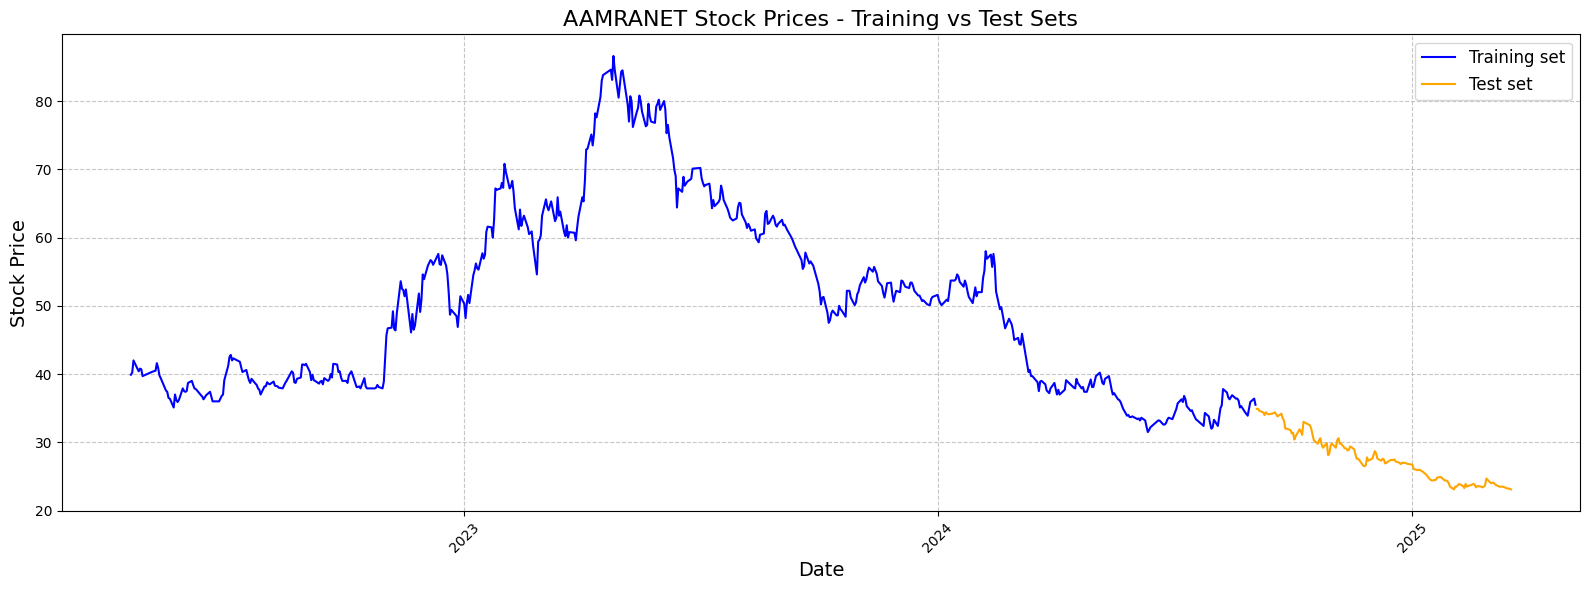

Epoch 1/100
17/17 [==============================] - 15s 115ms/step - loss: 0.0544
Epoch 2/100
17/17 [==============================] - 1s 68ms/step - loss: 0.0142
Epoch 3/100
17/17 [==============================] - 1s 71ms/step - loss: 0.0089
Epoch 4/100
17/17 [==============================] - 1s 74ms/step - loss: 0.0078
Epoch 5/100
17/17 [==============================] - 1s 72ms/step - loss: 0.0081
Epoch 6/100
17/17 [==============================] - 1s 66ms/step - loss: 0.0075
Epoch 7/100
17/17 [==============================] - 1s 69ms/step - loss: 0.0086
Epoch 8/100
17/17 [==============================] - 1s 68ms/step - loss: 0.0070
Epoch 9/100
17/17 [==============================] - 1s 65ms/step - loss: 0.0088
Epoch 10/100
17/17 [==============================] - 1s 65ms/step - loss: 0.0069
Epoch 11/100
17/17 [==============================] - 1s 66ms/step - loss: 0.0062
Epoch 12/100
17/17 [==============================] - 1s 68ms/step - loss: 0.0068
Epoch 13/100
17/17 [===

In [ ]:
# iteration 4 - fixed iteration 3
# -*- coding: utf-8 -*-
"""Stock Price Prediction with LSTM, GRU, ARIMA and Traditional Models"""

# --- Install Required Libraries ---
!pip install -q numpy==1.23.5 pandas==1.5.3 matplotlib==3.7.1 scikit-learn==1.2.2 
!pip install -q statsmodels==0.14.0 pmdarima==2.0.3 xgboost==1.7.5 
!pip install -q tensorflow==2.12.0 keras==2.12.0

# --- Import Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from xgboost import XGBRegressor
from sklearn.svm import SVR
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
import warnings
import math
warnings.filterwarnings("ignore")

# --- Helper Functions ---
def lr_schedule(epoch, lr):
    """Learning rate schedule with decay"""
    if epoch < 10:
        return lr
    else:
        return lr * math.exp(-0.1)

def ad_test(dataset):
    """Augmented Dickey-Fuller test for stationarity"""
    dftest = adfuller(dataset, autolag='AIC')
    print('1. ADF:', dftest[0])
    print('2. P-value:', dftest[1])
    print('3. Num of Lags:', dftest[2])
    print('4. Num of Observations:', dftest[3])
    print('5. Critical Values:')
    for key, val in dftest[4].items():
        print(f'\t{key}: {val}')
    return dftest[1]  # Return p-value

# --- Data Loading and Preparation ---
def load_data(filepath):
    """Load and preprocess the stock data"""
    df = pd.read_csv(filepath, parse_dates=['Date'], dayfirst=True)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])
    df = df.sort_values(['Company', 'Date'])
    
    numeric_cols = ['Open', 'Close', 'High', 'Low', 'Volume']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    df = df.dropna(subset=numeric_cols)
    
    return df

def prepare_sequence_data(company_data, look_back=30):
    """Prepare data for sequence models (LSTM, Bi-LSTM, GRU)"""
    company_data['ohlc_avg'] = company_data[['Open', 'High', 'Low', 'Close']].mean(axis=1)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(company_data[['ohlc_avg']])
    
    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i, 0])
        y.append(scaled_data[i, 0])
    
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    return X, y, scaler, company_data

def prepare_tabular_data(company_data, look_back=30):
    """Prepare data for non-sequence models (XGBoost, SVR)"""
    company_data['ohlc_avg'] = company_data[['Open', 'High', 'Low', 'Close']].mean(axis=1)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(company_data[['ohlc_avg']])
    
    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i, 0])
        y.append(scaled_data[i, 0])
    
    return np.array(X), np.array(y), scaler, company_data

# --- Model Definitions ---
def train_gru(X_train, y_train, epochs=100, batch_size=150):
    """GRU implementation with learning rate scheduling"""
    model = Sequential([
        GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'),
        Dropout(0.2),
        GRU(units=50, return_sequences=True, activation='tanh'),
        Dropout(0.2),
        GRU(units=50, return_sequences=True, activation='tanh'),
        Dropout(0.2),
        GRU(units=50, activation='tanh'),
        Dropout(0.2),
        Dense(units=1)
    ])
    
    optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=False)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    callbacks = [
        EarlyStopping(monitor='loss', patience=15, restore_best_weights=True),
        LearningRateScheduler(lr_schedule)
    ]
    
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              callbacks=callbacks, verbose=1)
    return model

def train_lstm(X_train, y_train, epochs=100, batch_size=32):
    """LSTM implementation"""
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.3),
        LSTM(64, return_sequences=True),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.3),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              callbacks=[early_stopping], verbose=1)
    return model

def train_bilstm(X_train, y_train, epochs=100, batch_size=32):
    """Bidirectional LSTM implementation"""
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.3),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(64)),
        Dropout(0.3),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              callbacks=[early_stopping], verbose=1)
    return model

def train_arima(train_data):
    """Enhanced ARIMA implementation with auto_arima and diagnostics"""
    if isinstance(train_data, pd.DataFrame):
        series = train_data['ohlc_avg']
    else:
        series = train_data
    
    # Check stationarity
    print("\nPerforming Augmented Dickey-Fuller Test:")
    p_value = ad_test(series)
    
    # Plot ACF and PACF
    plt.figure(figsize=(12, 6))
    plot_acf(series, lags=30, ax=plt.subplot(121), title='Autocorrelation')
    plot_pacf(series, lags=30, ax=plt.subplot(122), title='Partial Autocorrelation')
    plt.suptitle(f'ACF and PACF Plots')
    plt.tight_layout()
    plt.show()
    
    # Auto ARIMA for parameter selection
    print("\nRunning auto_arima for parameter selection:")
    model_autoARIMA = auto_arima(series, start_p=0, start_q=0,
                                test='adf',
                                max_p=3, max_q=3,
                                m=1,
                                d=None,
                                seasonal=False,
                                trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True)
    
    print("\nAuto ARIMA Summary:")
    print(model_autoARIMA.summary())
    
    # Plot diagnostics
    print("\nModel Diagnostics:")
    model_autoARIMA.plot_diagnostics(figsize=(15, 8))
    plt.tight_layout()
    plt.show()
    
    # Get the best parameters from auto_arima
    order = model_autoARIMA.order
    print(f"\nBest ARIMA Order: {order}")
    
    # Fit SARIMAX model (enhanced ARIMA)
    model = SARIMAX(series, order=order)
    model_fit = model.fit(disp=False)
    
    return model_fit

def train_xgboost(X_train, y_train):
    """XGBoost implementation"""
    model = XGBRegressor(n_estimators=100, learning_rate=0.1)
    model.fit(X_train, y_train)
    return model

def train_svr(X_train, y_train):
    """SVR implementation"""
    model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
    model.fit(X_train, y_train)
    return model

# --- Visualization Functions ---
def plot_training_test_split(company, train_dates, train_prices, test_dates, test_prices):
    """Plot training vs test set split"""
    plt.figure(figsize=(16, 6))
    plt.plot(train_dates, train_prices, label='Training set', color='blue')
    plt.plot(test_dates, test_prices, label='Test set', color='orange')
    plt.title(f'{company} Stock Prices - Training vs Test Sets', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Stock Price', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Format x-axis
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_predictions(company, model_name, dates, actual, predicted, metrics):
    """Plot actual vs predicted prices"""
    plt.figure(figsize=(14, 7))
    plt.plot(dates, actual, label='Actual Prices', color='blue', linewidth=2)
    plt.plot(dates, predicted, label=f'Predicted Prices ({model_name})', 
            color='red', linestyle='--', linewidth=2)
    plt.title(f'{company} Stock Price Prediction ({model_name})', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Stock Price', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Format x-axis
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    
    # Add metrics to plot
    plt.figtext(0.15, 0.8, 
               f"MAE: {metrics['MAE']:.2f}\nRMSE: {metrics['RMSE']:.2f}\nR²: {metrics['R2']:.2f}", 
               bbox=dict(facecolor='white', alpha=0.8),
               fontsize=12)
    
    plt.tight_layout()
    plt.show()

# --- Main Prediction Function ---
def predict_stock_prices(df, look_back=30):
    """Predict stock prices for all companies in the dataframe"""
    companies = df['Company'].unique()
    results = {}
    
    for company in companies:
        try:
            print(f"\n{'='*50}\nProcessing {company}...\n{'='*50}")
            company_data = df[df['Company'] == company].copy()
            
            if len(company_data) < look_back * 2:
                print(f"Skipping {company} - insufficient data ({len(company_data)} records)")
                continue
                
            # Prepare data
            X_seq, y_seq, seq_scaler, _ = prepare_sequence_data(company_data, look_back)
            X_tab, y_tab, tab_scaler, _ = prepare_tabular_data(company_data, look_back)
            
            # Train-test split
            split = int(0.8 * len(X_seq))
            X_seq_train, X_seq_test = X_seq[:split], X_seq[split:]
            y_seq_train, y_seq_test = y_seq[:split], y_seq[split:]
            X_tab_train, X_tab_test = X_tab[:split], X_tab[split:]
            y_tab_train, y_tab_test = y_tab[:split], y_tab[split:]
            
            # Get dates and prices for plotting
            test_dates = company_data['Date'].iloc[split+look_back:].values
            train_dates = company_data['Date'].iloc[:split+look_back].values
            train_prices = company_data['Close'].iloc[:split+look_back].values
            test_prices = company_data['Close'].iloc[split+look_back:].values
            
            # Plot training vs test split
            plot_training_test_split(company, train_dates, train_prices, test_dates, test_prices)
            
            # Train all models
            models = {
                'LSTM': train_lstm(X_seq_train, y_seq_train),
                'Bi-LSTM': train_bilstm(X_seq_train, y_seq_train),
                'GRU': train_gru(X_seq_train, y_seq_train),
                'ARIMA': train_arima(company_data.iloc[:split + look_back]),
                'XGBoost': train_xgboost(X_tab_train, y_tab_train),
                'SVR': train_svr(X_tab_train, y_tab_train)
            }
            
            company_results = {}
            
            # Make predictions and plot for each model
            for model_name, model in models.items():
                try:
                    print(f"\nTraining {model_name} model...")
                    
                    if model_name in ['LSTM', 'Bi-LSTM', 'GRU']:
                        predicted = model.predict(X_seq_test)
                        predicted_prices = seq_scaler.inverse_transform(predicted)
                        actual_prices = seq_scaler.inverse_transform(y_seq_test.reshape(-1, 1))
                    elif model_name == 'ARIMA':
                        # ARIMA predictions
                        forecast = model.get_prediction(start=split+look_back, 
                                                      end=len(company_data)-1)
                        predicted_prices = forecast.predicted_mean.values.reshape(-1, 1)
                        actual_prices = seq_scaler.inverse_transform(y_seq_test.reshape(-1, 1))
                    else:  # XGBoost, SVR
                        predicted = model.predict(X_tab_test)
                        predicted_prices = tab_scaler.inverse_transform(predicted.reshape(-1, 1))
                        actual_prices = tab_scaler.inverse_transform(y_tab_test.reshape(-1, 1))
                    
                    # Calculate metrics
                    metrics = {
                        'MAE': mean_absolute_error(actual_prices, predicted_prices),
                        'RMSE': np.sqrt(mean_squared_error(actual_prices, predicted_prices)),
                        'R2': r2_score(actual_prices, predicted_prices)
                    }
                    
                    # Store results
                    company_results[model_name] = {
                        'predicted': predicted_prices.flatten(),
                        'metrics': metrics
                    }
                    
                    # Plot predictions
                    plot_predictions(company, model_name, test_dates, 
                                   actual_prices.flatten(), predicted_prices.flatten(), metrics)
                    
                    print(f"\nMetrics for {model_name}:")
                    print(f"MAE: {metrics['MAE']:.4f}")
                    print(f"RMSE: {metrics['RMSE']:.4f}")
                    print(f"R2 Score: {metrics['R2']:.4f}")
                    
                except Exception as e:
                    print(f"\nError processing {model_name} for {company}: {str(e)}")
                    company_results[model_name] = None
            
            # Store all results for this company
            results[company] = {
                'dates': test_dates,
                'actual': actual_prices.flatten(),
                'models': company_results
            }
            
        except Exception as e:
            print(f"\nError processing {company}: {str(e)}")
    
    return results

# --- Main Execution ---
if __name__ == "__main__":
    # Load data
    file_path = "combined_stock_data_test.csv"
    print("\nLoading data...")
    stock_data = load_data(file_path)
    
    # Run predictions
    print("\nStarting predictions...")
    prediction_results = predict_stock_prices(stock_data)
    
    # Save results to CSV
    results_df = pd.DataFrame()
    full_results = []
    
    for company, data in prediction_results.items():
        # Save metrics
        for model_name, model_data in data['models'].items():
            if model_data is not None:
                temp_df = pd.DataFrame({
                    'Company': company,
                    'Model': model_name,
                    **model_data['metrics']
                }, index=[0])
                results_df = pd.concat([results_df, temp_df], ignore_index=True)
        
        # Save predictions if we have any models that succeeded
        if any(model_data is not None for model_data in data['models'].values()):
            temp_df = pd.DataFrame({
                'Company': company,
                'Date': data['dates'],
                'Actual_Price': data['actual']
            })
            
            for model_name, model_data in data['models'].items():
                if model_data is not None:
                    temp_df[f'{model_name}_Predicted'] = model_data['predicted']
            
            full_results.append(temp_df)
    
    # Only save files if we have results
    if len(results_df) > 0:
        results_df.to_csv('stock_prediction_results_all_models.csv', index=False)
        print("\nPrediction results saved to 'stock_prediction_results_all_models.csv'")
    else:
        print("\nNo prediction results to save - all models failed")
    
    if len(full_results) > 0:
        pd.concat(full_results).to_csv('full_predictions_all_models.csv', index=False)
        print("Detailed predictions saved to 'full_predictions_all_models.csv'")
    else:
        print("No detailed predictions to save - all models failed")

You should consider upgrading via the 'C:\Users\SHEPHERD\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\SHEPHERD\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\SHEPHERD\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\SHEPHERD\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.



Loading data...

Starting predictions...

Processing AAMRANET...


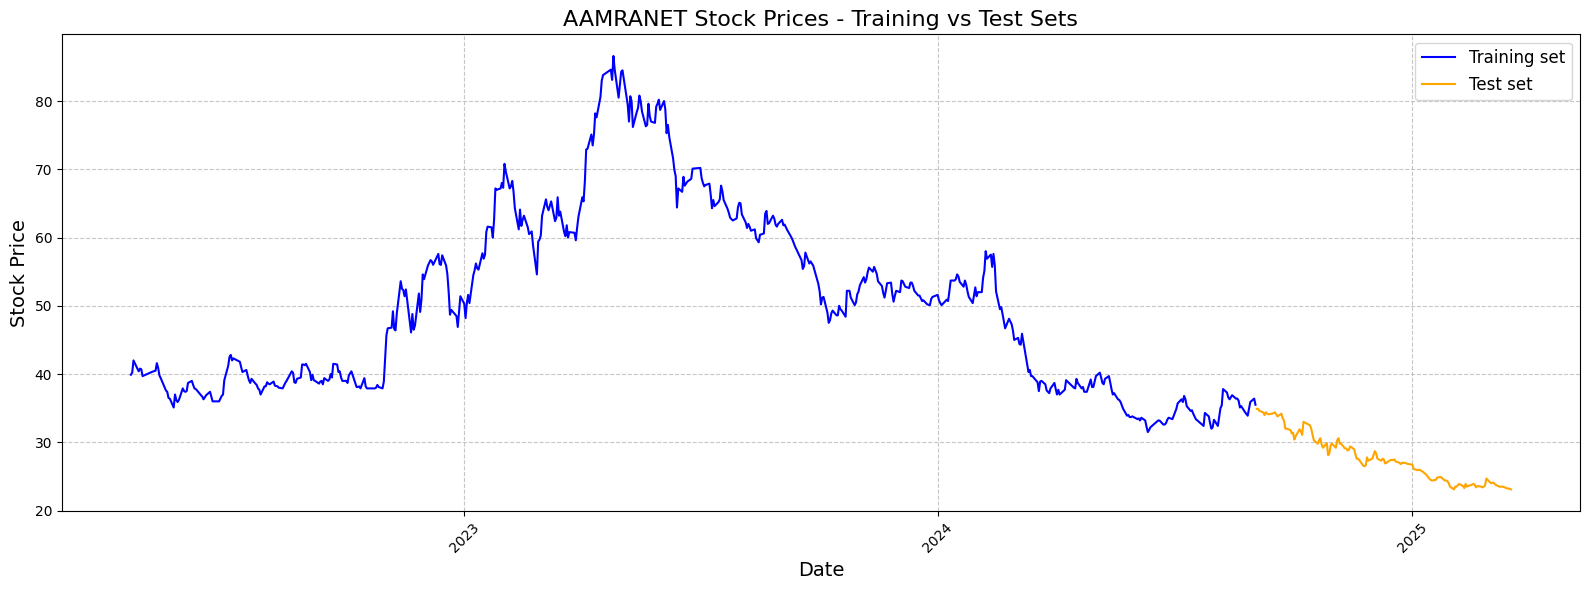

Epoch 1/100
17/17 [==============================] - 6s 32ms/step - loss: 0.0443
Epoch 2/100
17/17 [==============================] - 1s 32ms/step - loss: 0.0119
Epoch 3/100
17/17 [==============================] - 1s 32ms/step - loss: 0.0092
Epoch 4/100
17/17 [==============================] - 1s 35ms/step - loss: 0.0080
Epoch 5/100
17/17 [==============================] - 1s 31ms/step - loss: 0.0073
Epoch 6/100
17/17 [==============================] - 1s 34ms/step - loss: 0.0076
Epoch 7/100
17/17 [==============================] - 1s 33ms/step - loss: 0.0077
Epoch 8/100
17/17 [==============================] - 1s 37ms/step - loss: 0.0065
Epoch 9/100
17/17 [==============================] - 1s 33ms/step - loss: 0.0065
Epoch 10/100
17/17 [==============================] - 1s 32ms/step - loss: 0.0065
Epoch 11/100
17/17 [==============================] - 1s 33ms/step - loss: 0.0060
Epoch 12/100
17/17 [==============================] - 1s 32ms/step - loss: 0.0059
Epoch 13/100
17/17 [=====

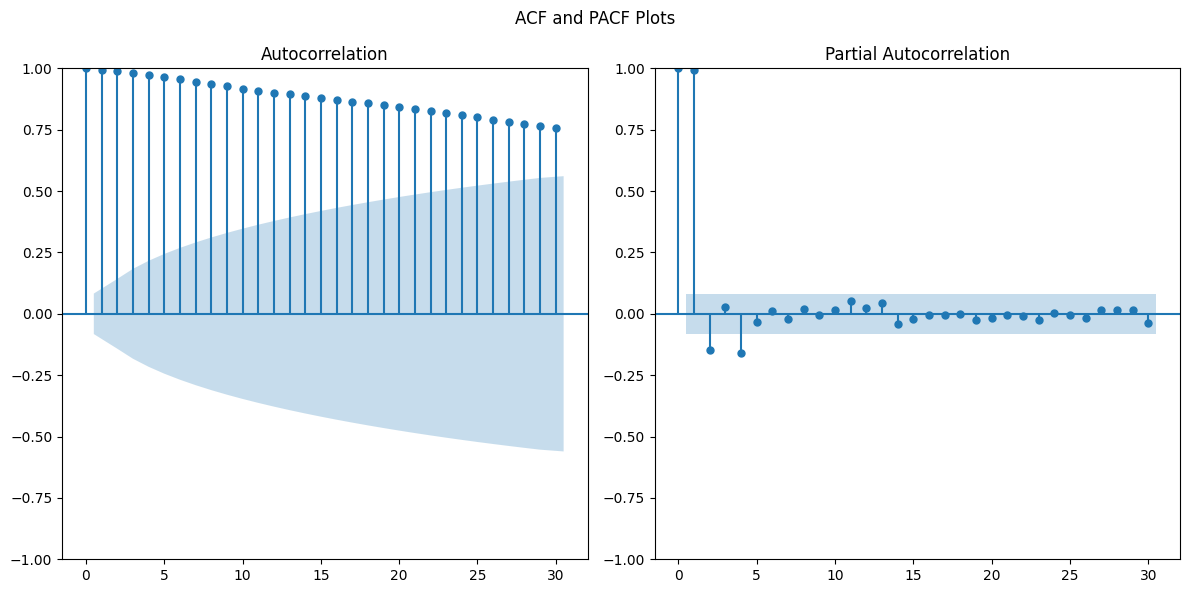


Running auto_arima for parameter selection:
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1745.929, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1716.889, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1709.542, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1743.947, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1701.600, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1703.421, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1703.509, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1705.563, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1716.396, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1699.113, Time=0.27 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1691.305, Time=0.26 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1689.385, Time=0.13 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1687.905, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1685.910, Ti

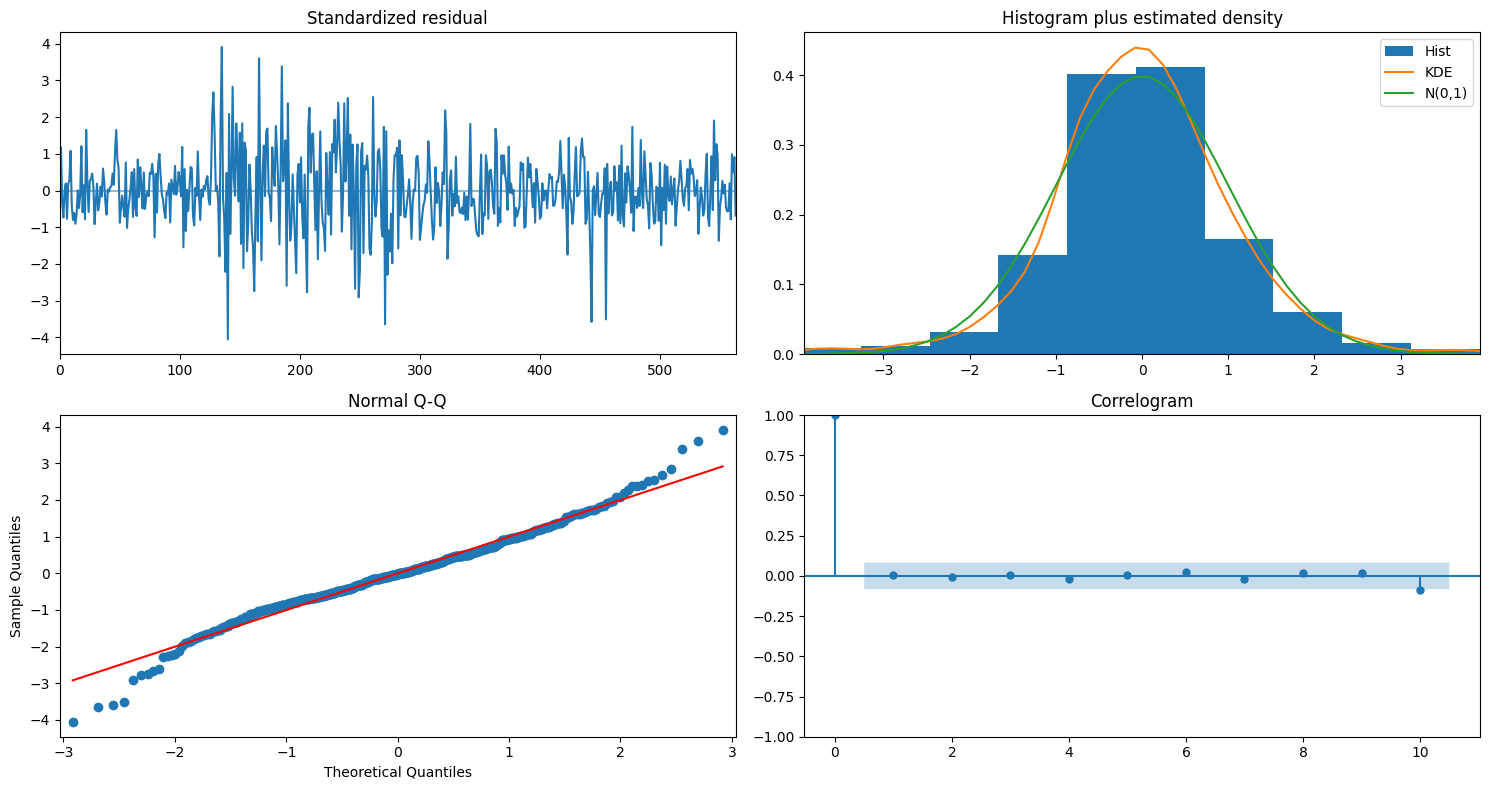


Best ARIMA Order: (3, 1, 0)

HMM Information Criteria:
AIC: 4211.02, BIC: 4488.46, HQC: 4319.32, CAIC: 4552.46

Training LSTM model...
5/5 [==============================] - 1s 10ms/step


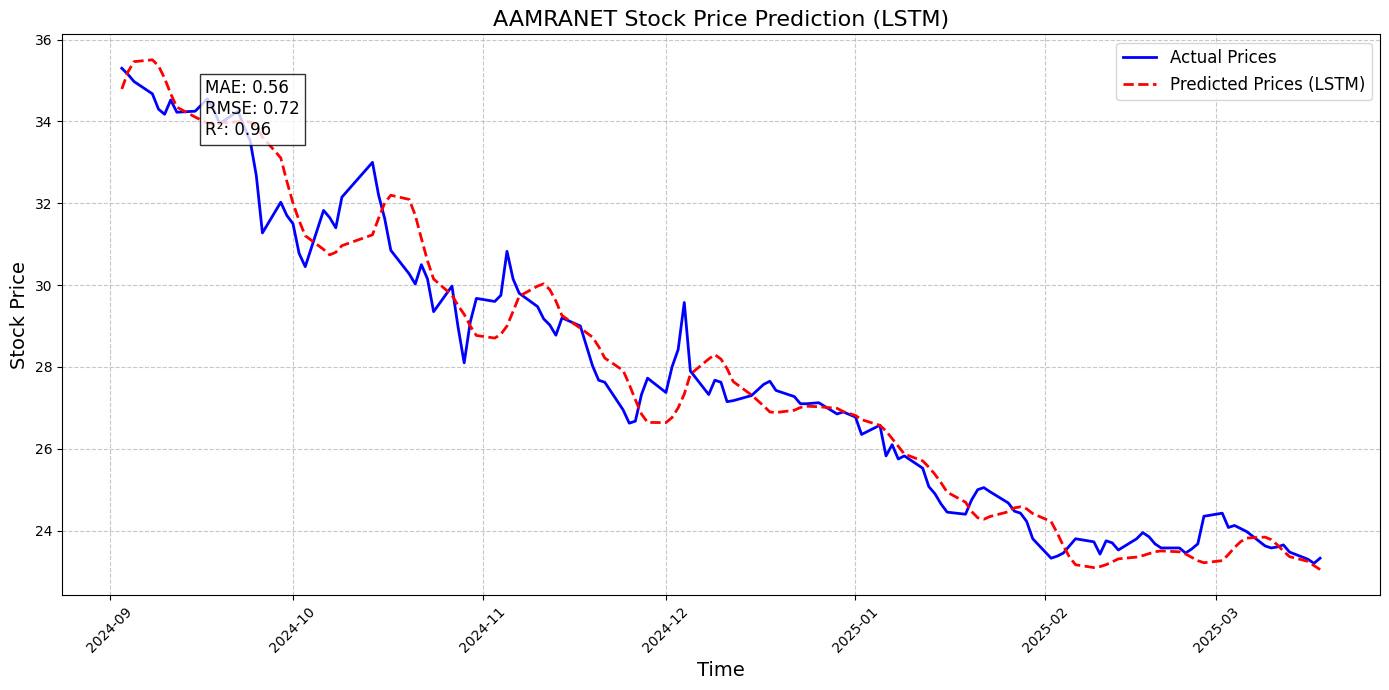


Metrics for LSTM:
MAE: 0.5597
RMSE: 0.7233
R2 Score: 0.9588

Training Bi-LSTM model...
5/5 [==============================] - 2s 16ms/step


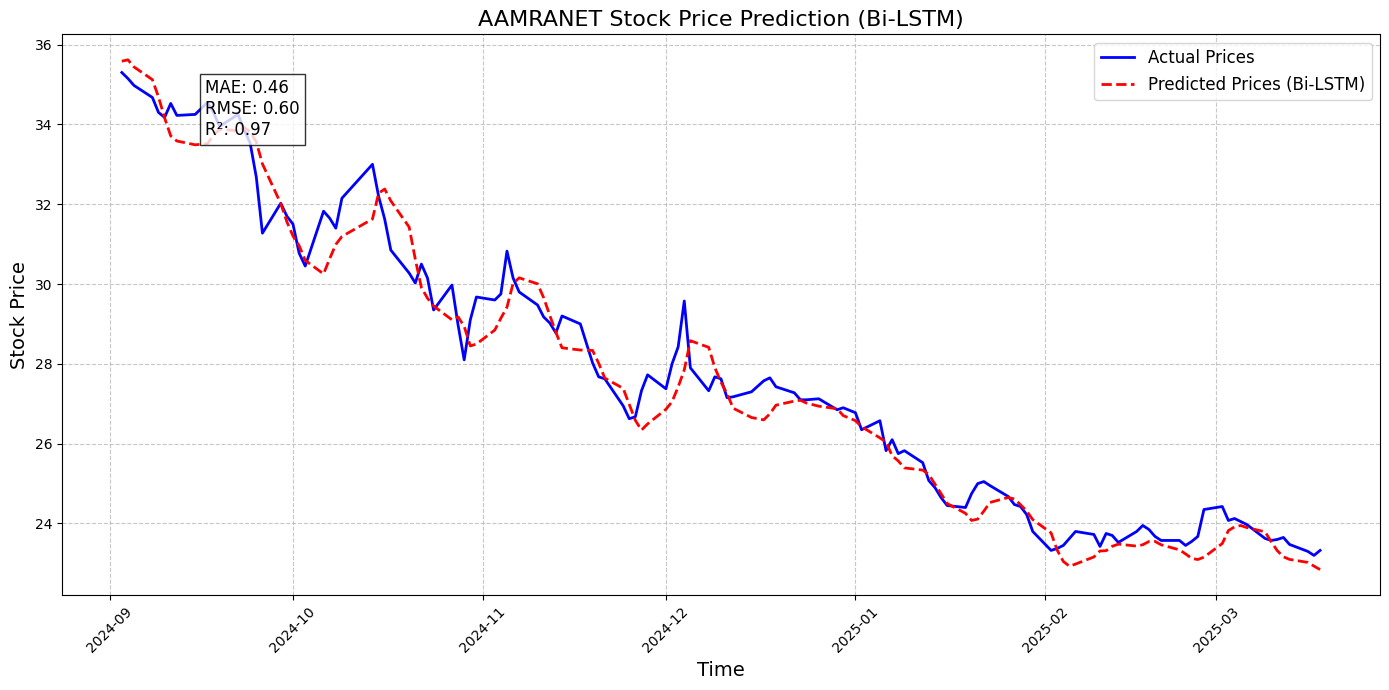


Metrics for Bi-LSTM:
MAE: 0.4625
RMSE: 0.6033
R2 Score: 0.9714

Training GRU model...
5/5 [==============================] - 2s 11ms/step


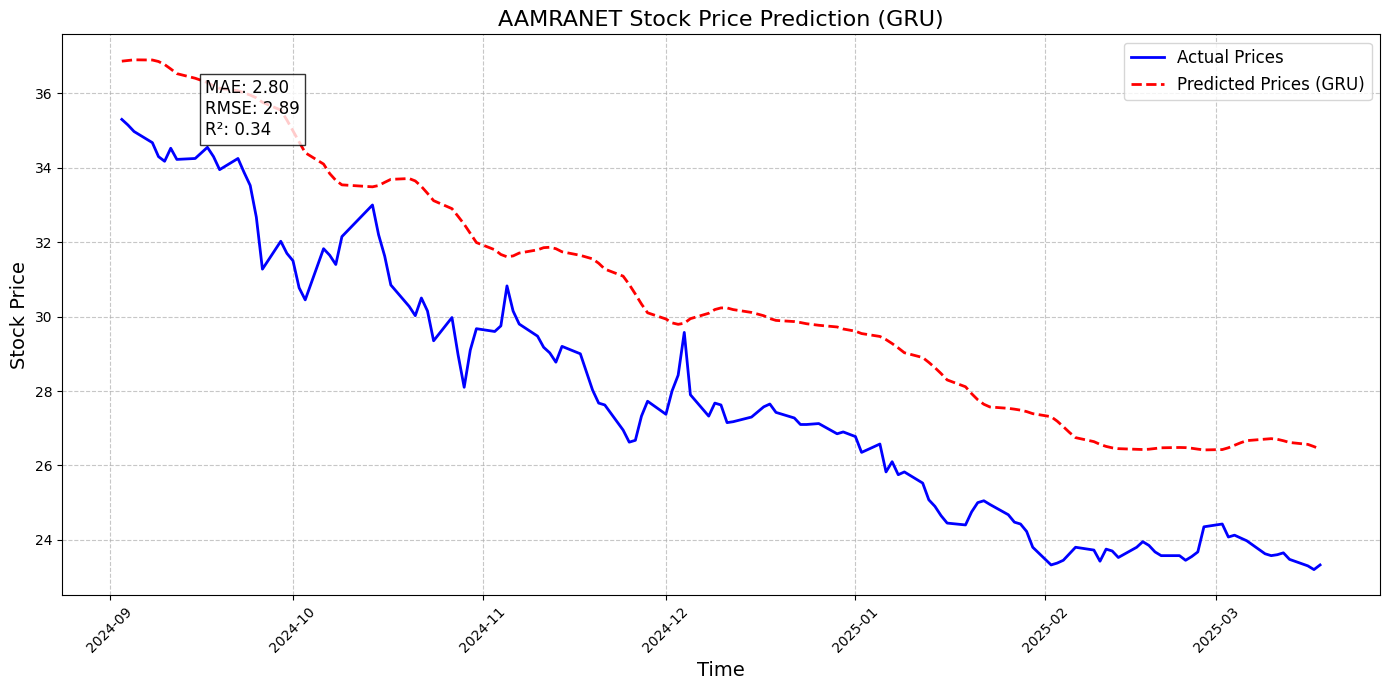


Metrics for GRU:
MAE: 2.7982
RMSE: 2.8945
R2 Score: 0.3410

Training ARIMA model...


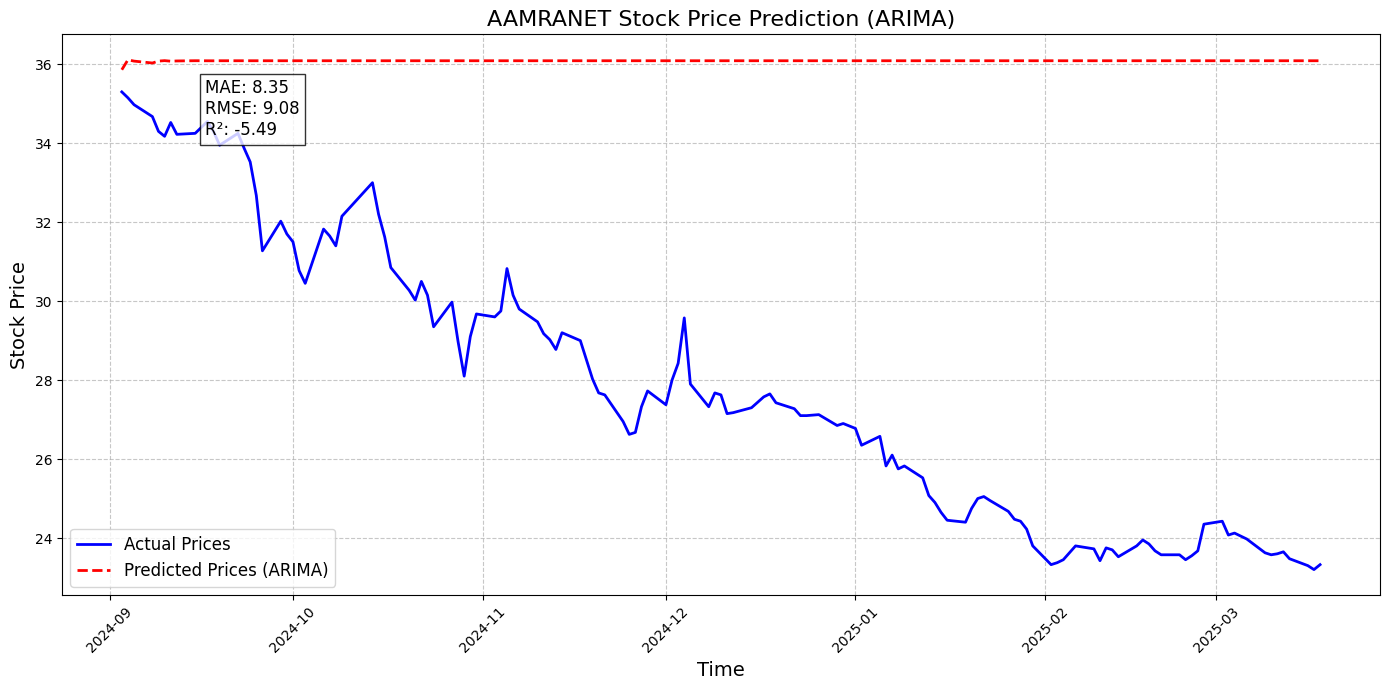


Metrics for ARIMA:
MAE: 8.3533
RMSE: 9.0842
R2 Score: -5.4913

Training HMM model...


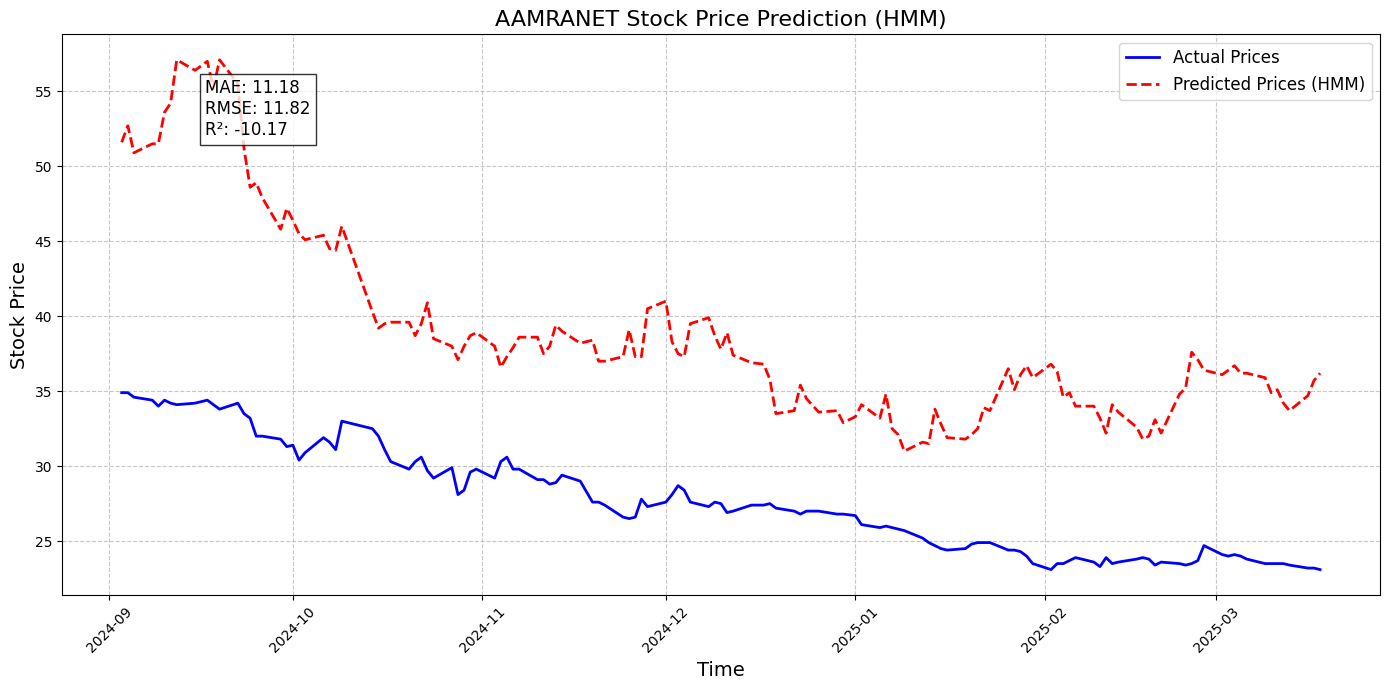


Metrics for HMM:
MAE: 11.1821
RMSE: 11.8153
R2 Score: -10.1696

Training XGBoost model...


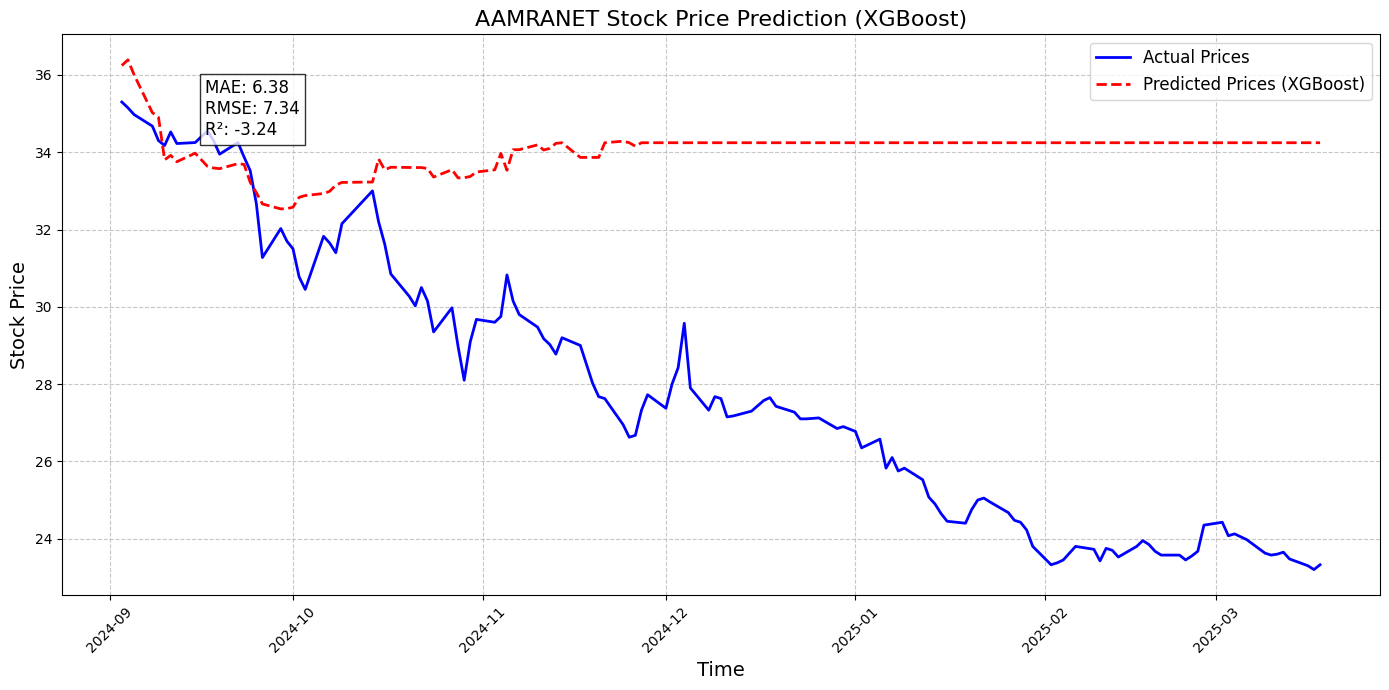


Metrics for XGBoost:
MAE: 6.3764
RMSE: 7.3399
R2 Score: -3.2378

Training SVR model...


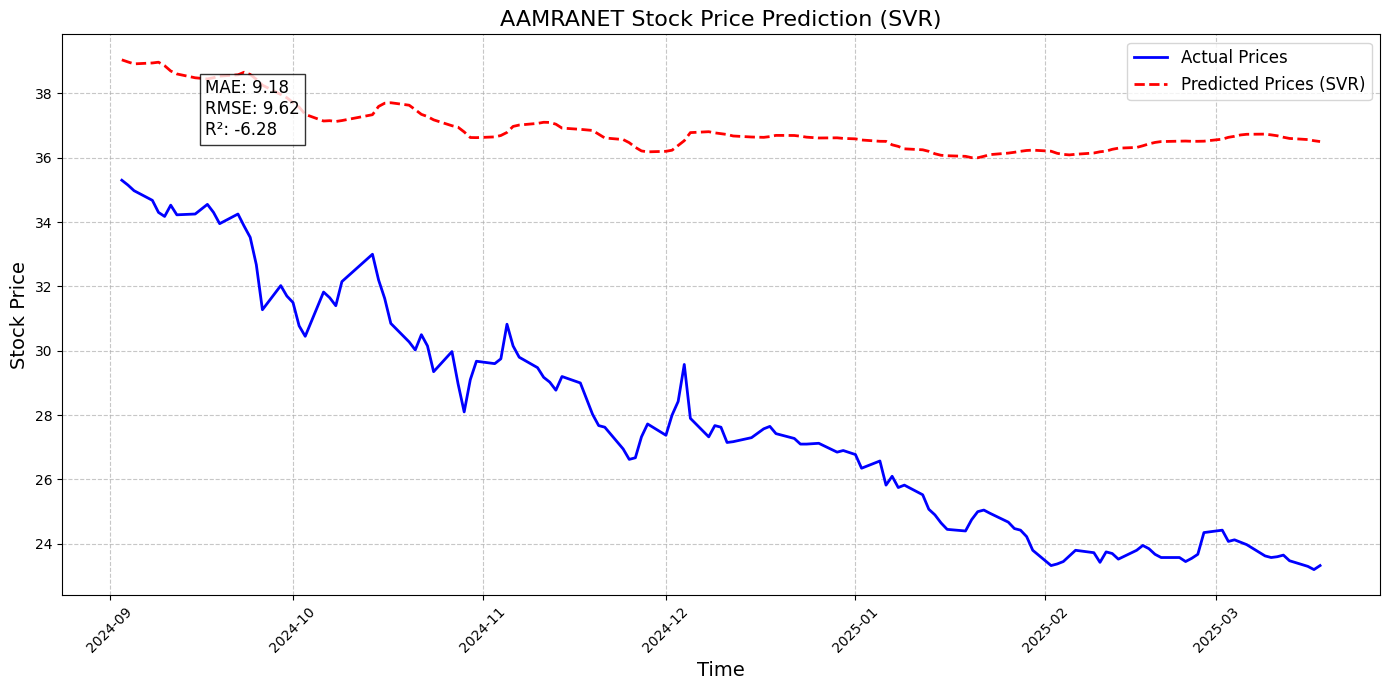


Metrics for SVR:
MAE: 9.1761
RMSE: 9.6205
R2 Score: -6.2803

Processing AAMRATECH...


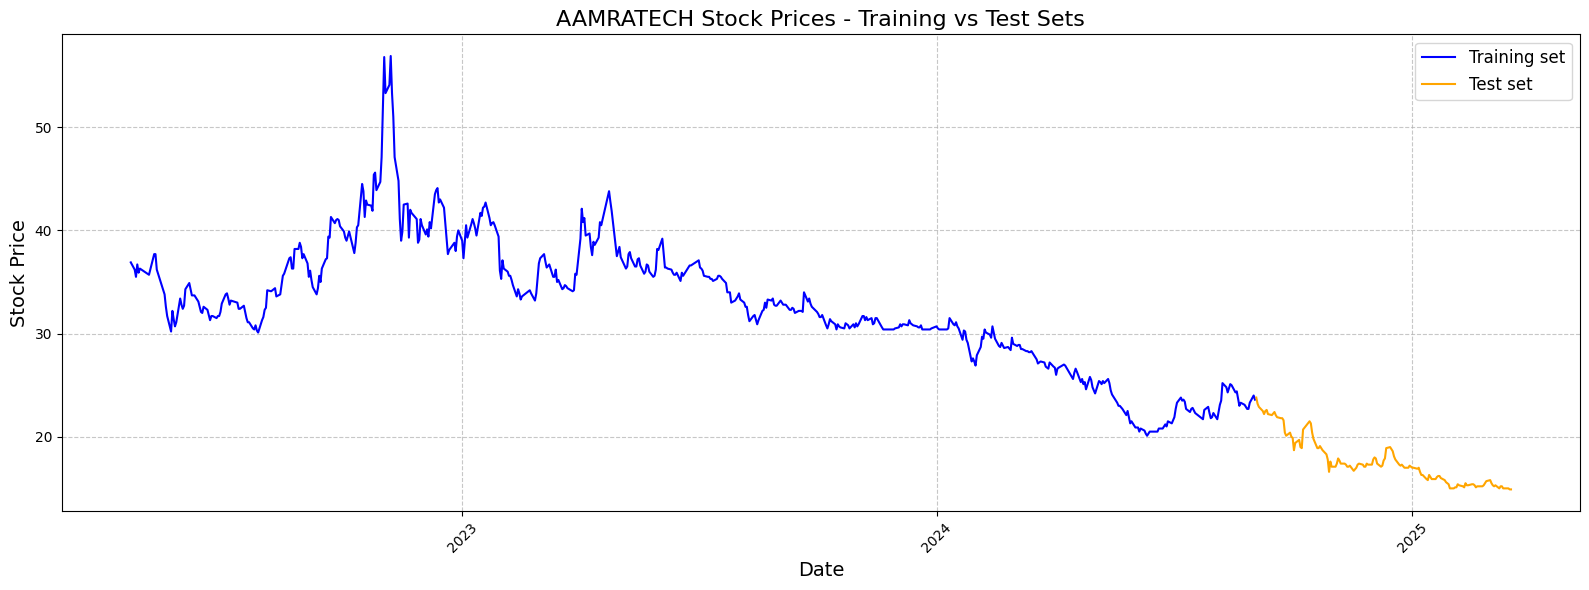

Epoch 1/100
17/17 [==============================] - 7s 36ms/step - loss: 0.0422
Epoch 2/100
17/17 [==============================] - 1s 38ms/step - loss: 0.0116
Epoch 3/100
17/17 [==============================] - 1s 38ms/step - loss: 0.0086
Epoch 4/100
17/17 [==============================] - 1s 40ms/step - loss: 0.0071
Epoch 5/100
17/17 [==============================] - 1s 37ms/step - loss: 0.0062
Epoch 6/100
17/17 [==============================] - 1s 39ms/step - loss: 0.0059
Epoch 7/100
17/17 [==============================] - 1s 38ms/step - loss: 0.0059
Epoch 8/100
17/17 [==============================] - 1s 39ms/step - loss: 0.0061
Epoch 9/100
17/17 [==============================] - 1s 39ms/step - loss: 0.0058
Epoch 10/100
17/17 [==============================] - 1s 38ms/step - loss: 0.0055
Epoch 11/100
17/17 [==============================] - 1s 40ms/step - loss: 0.0056
Epoch 12/100
17/17 [==============================] - 1s 37ms/step - loss: 0.0050
Epoch 13/100
17/17 [=====

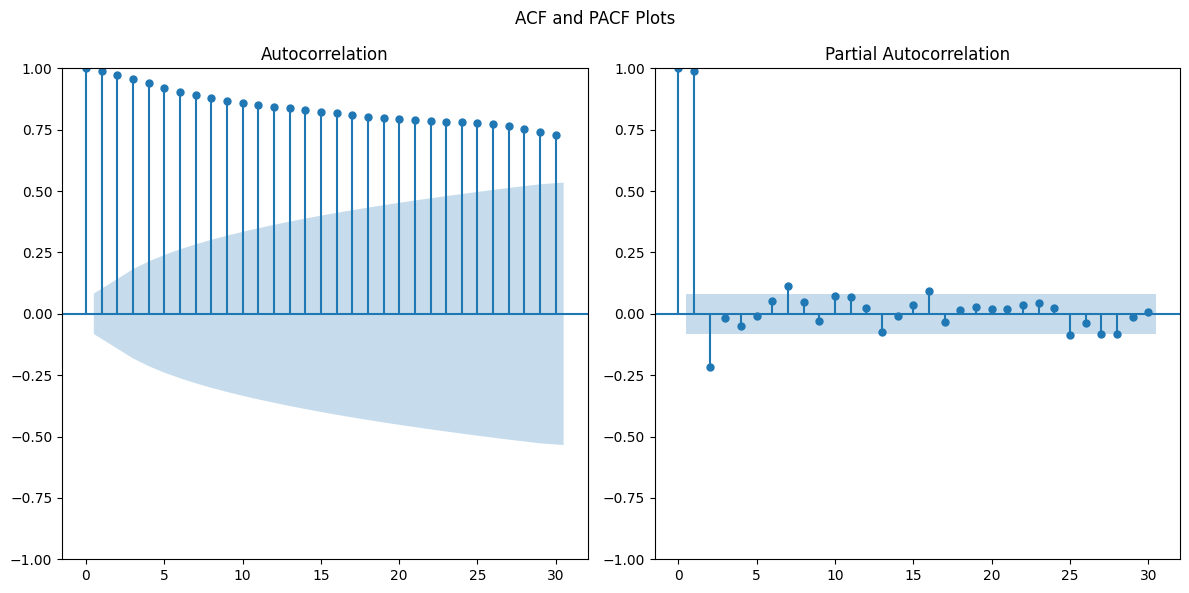


Running auto_arima for parameter selection:
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1383.898, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1346.997, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1347.348, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1382.280, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1348.825, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1348.715, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1350.159, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1345.212, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1347.048, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1346.941, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1345.596, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1348.383, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.878 seconds

Auto ARIMA Summary:
                      

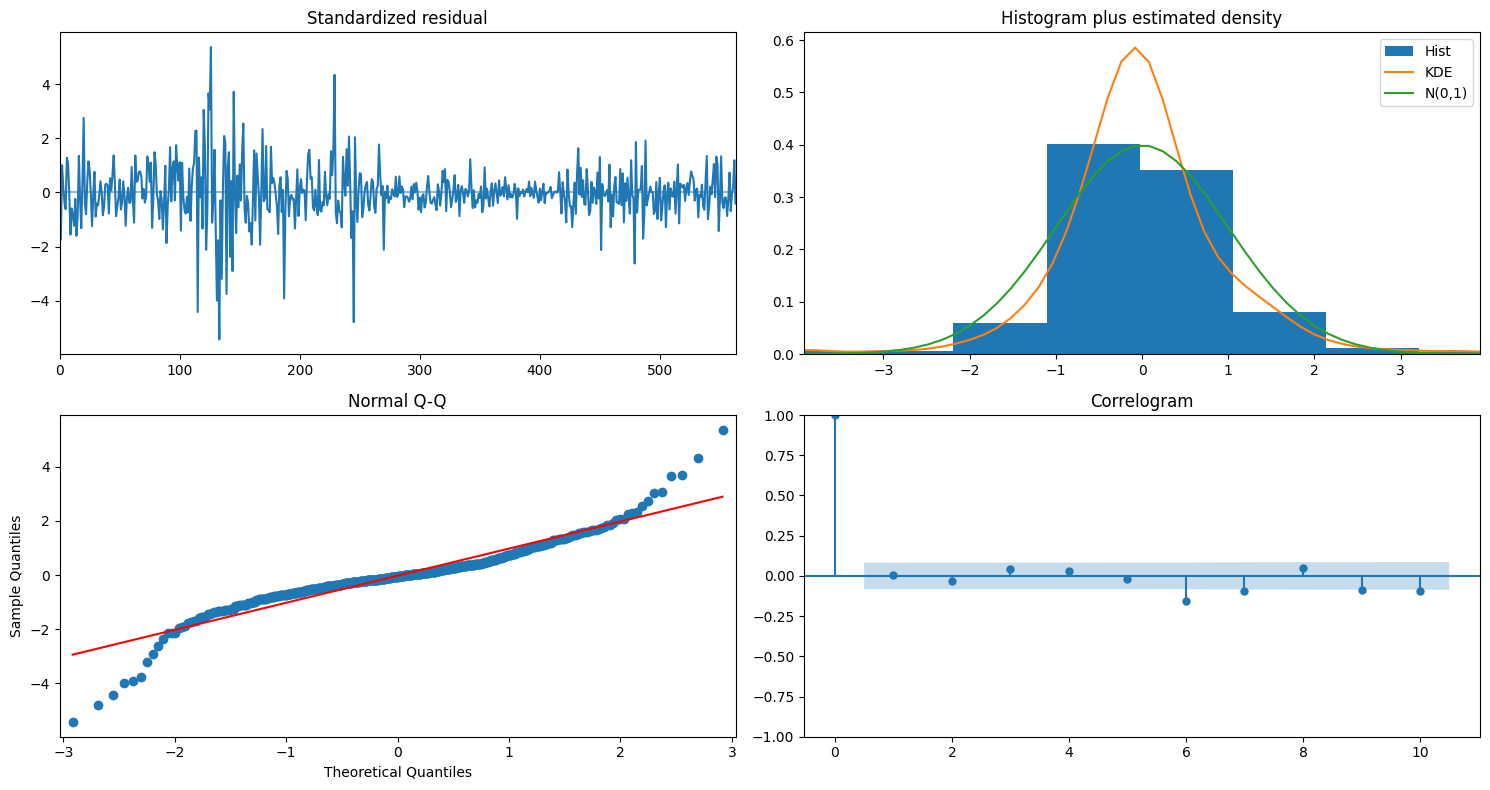


Best ARIMA Order: (1, 1, 0)

HMM Information Criteria:
AIC: 4112.87, BIC: 4390.32, HQC: 4221.17, CAIC: 4454.32

Training LSTM model...
5/5 [==============================] - 1s 15ms/step


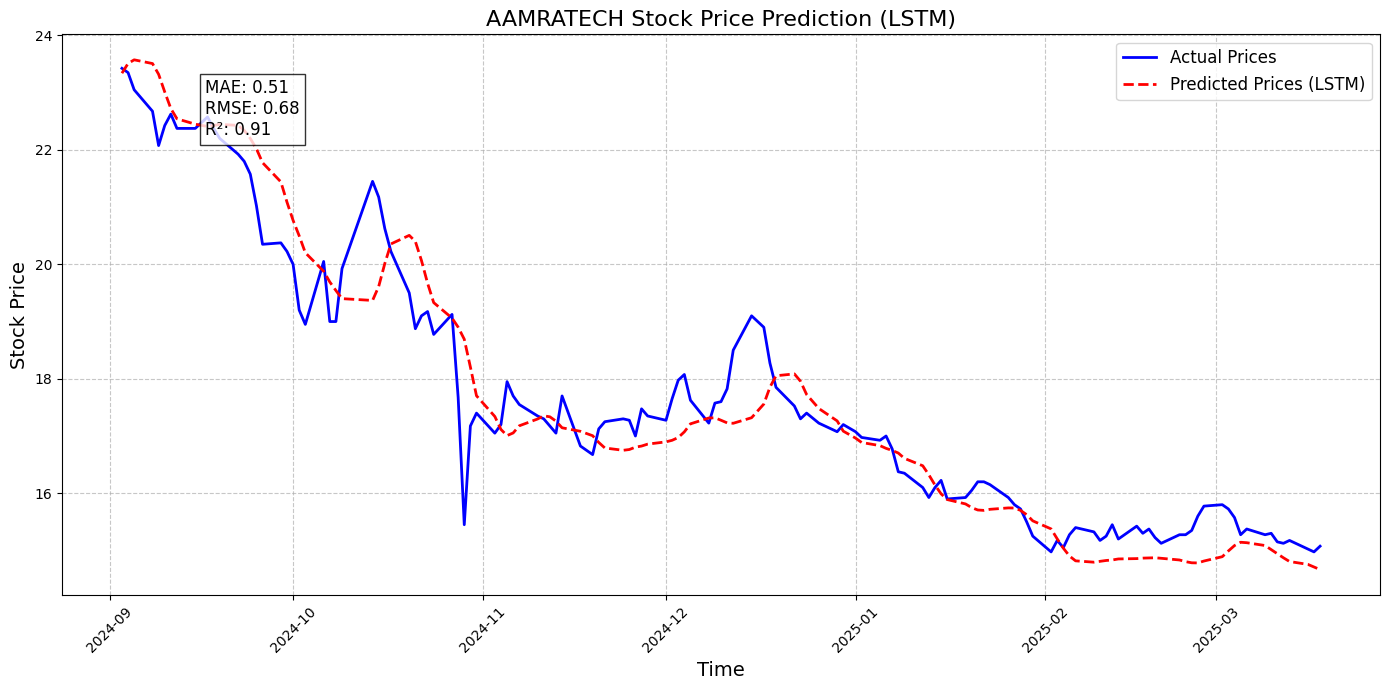


Metrics for LSTM:
MAE: 0.5055
RMSE: 0.6836
R2 Score: 0.9122

Training Bi-LSTM model...
5/5 [==============================] - 2s 16ms/step


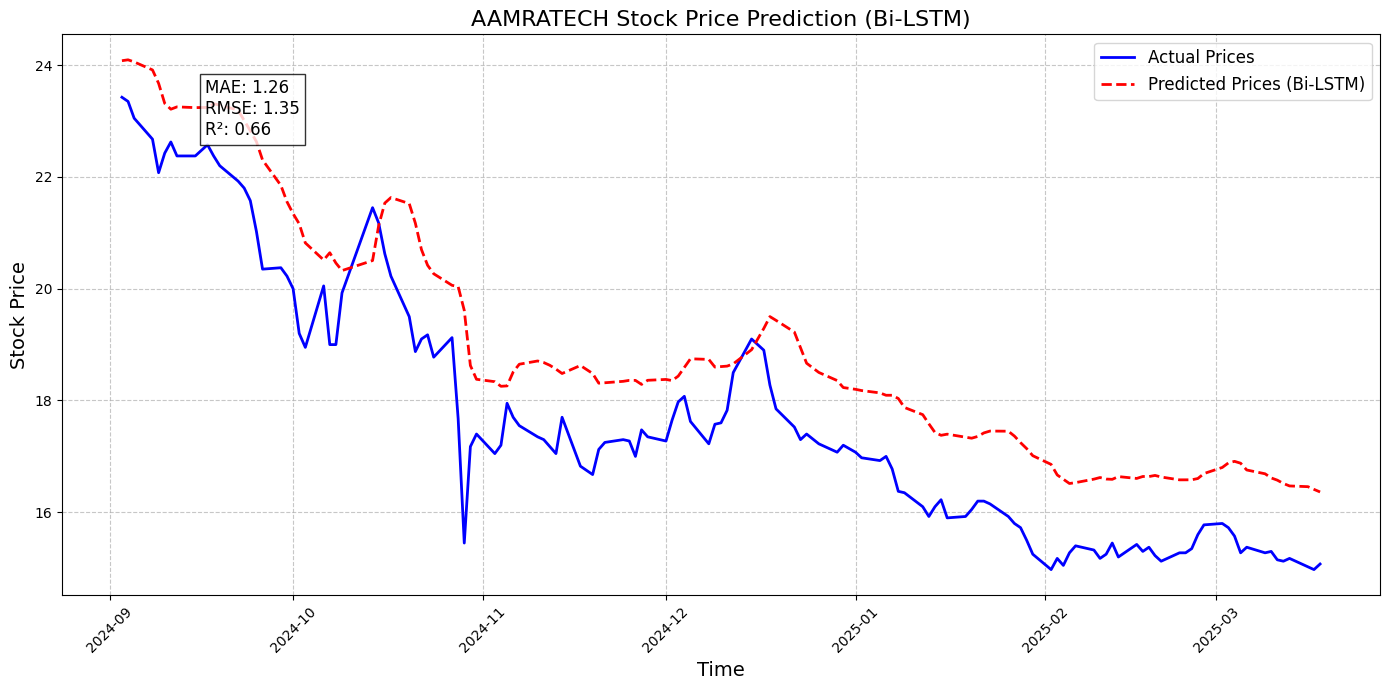


Metrics for Bi-LSTM:
MAE: 1.2622
RMSE: 1.3462
R2 Score: 0.6595

Training GRU model...
5/5 [==============================] - 1s 14ms/step


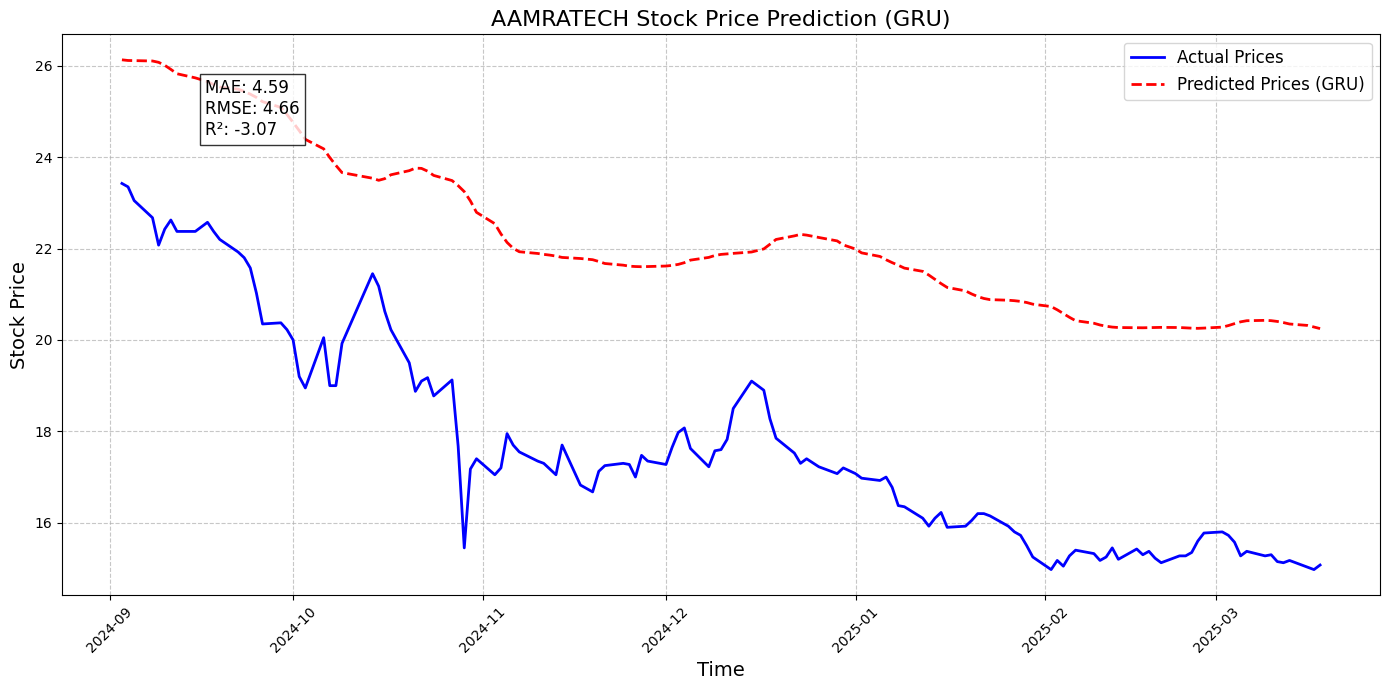


Metrics for GRU:
MAE: 4.5850
RMSE: 4.6553
R2 Score: -3.0717

Training ARIMA model...


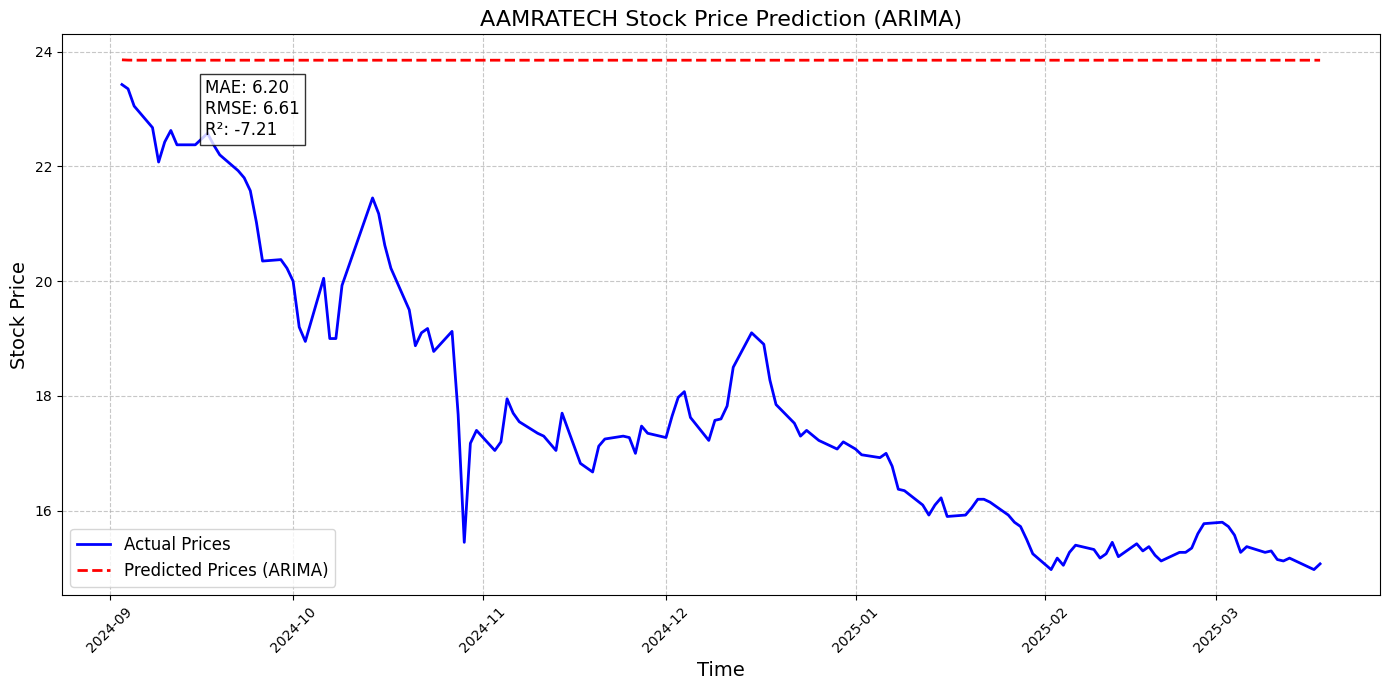


Metrics for ARIMA:
MAE: 6.1965
RMSE: 6.6120
R2 Score: -7.2138

Training HMM model...


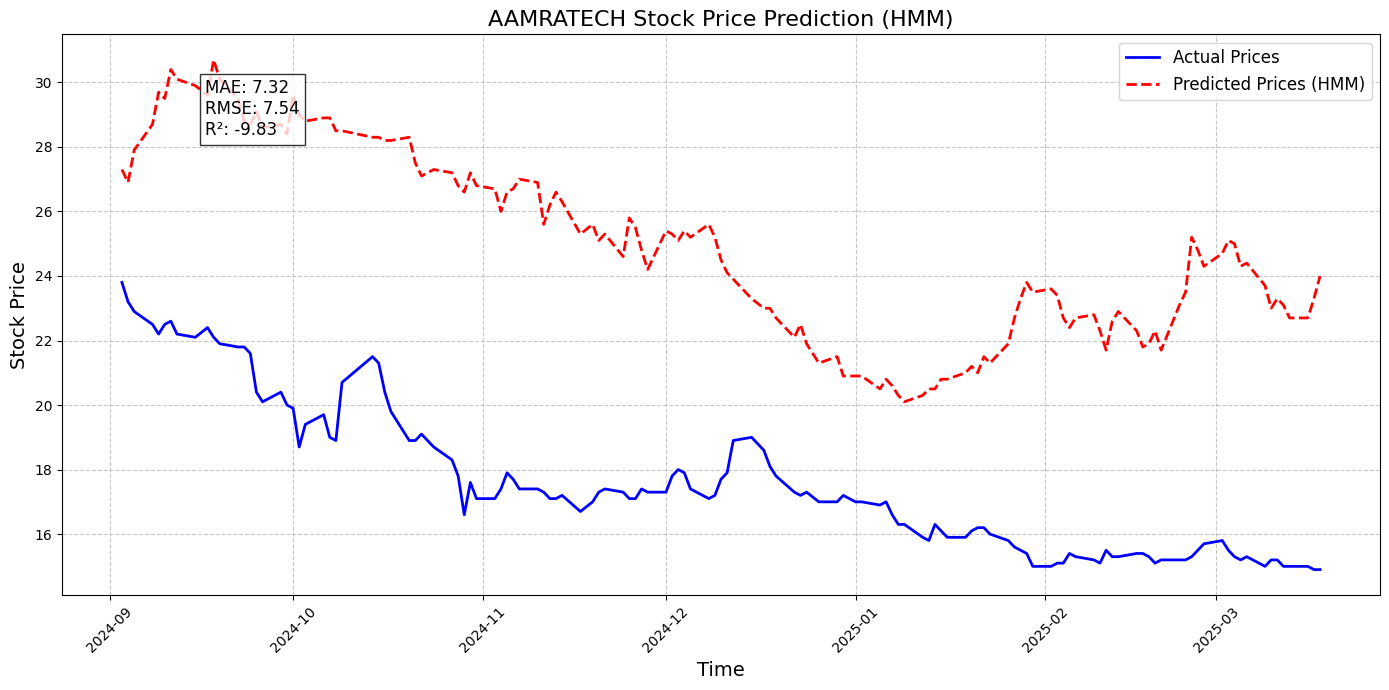


Metrics for HMM:
MAE: 7.3187
RMSE: 7.5387
R2 Score: -9.8334

Training XGBoost model...


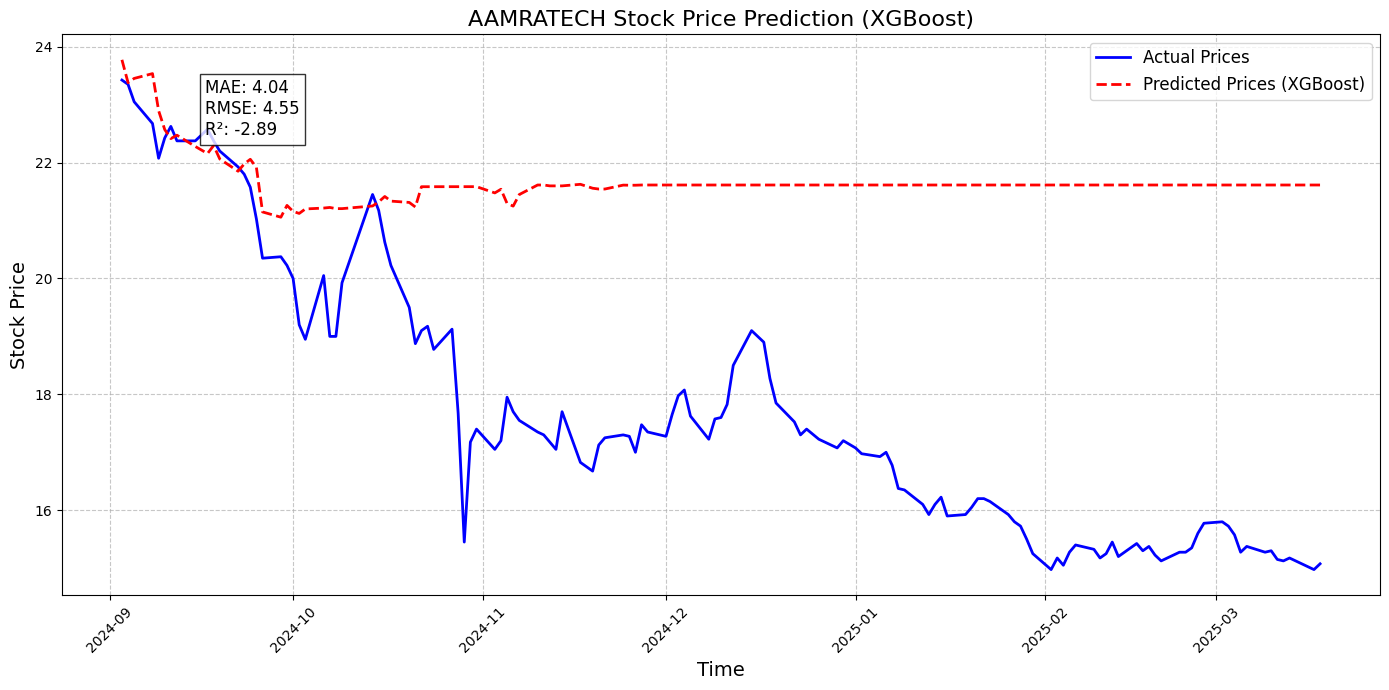


Metrics for XGBoost:
MAE: 4.0357
RMSE: 4.5490
R2 Score: -2.8879

Training SVR model...


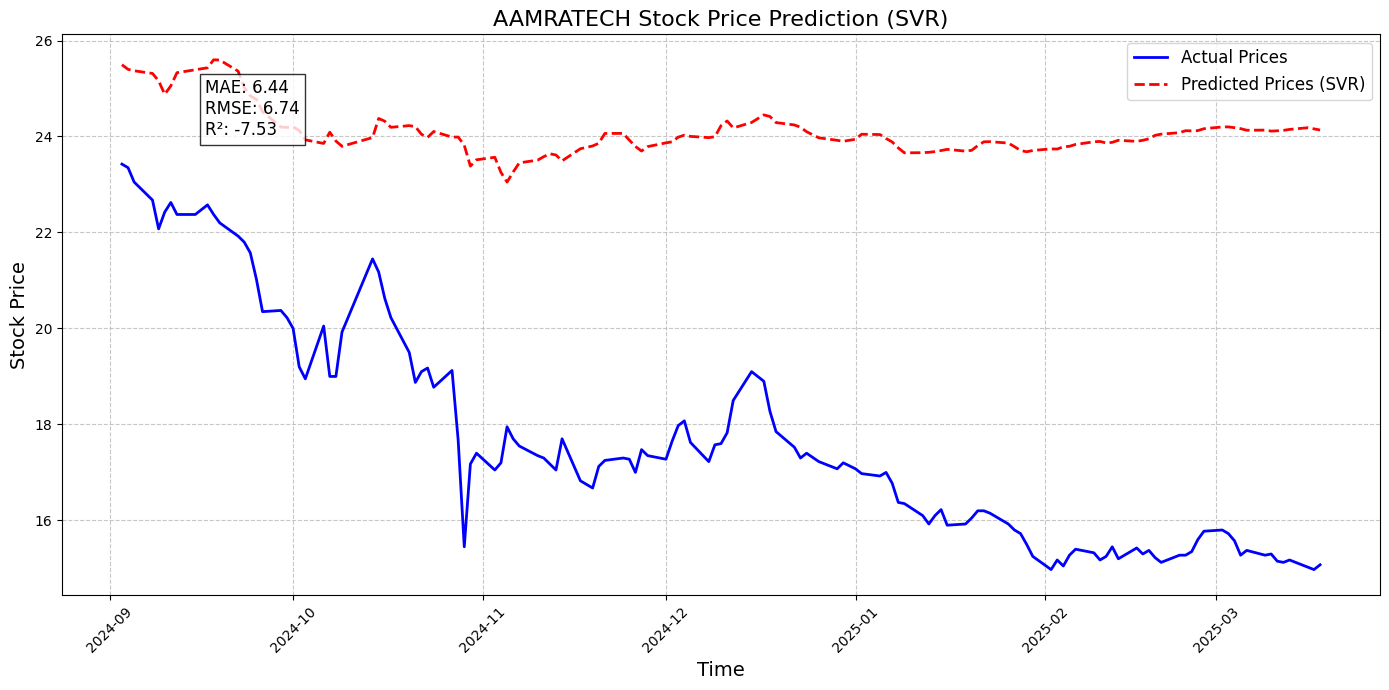


Metrics for SVR:
MAE: 6.4419
RMSE: 6.7382
R2 Score: -7.5303

Prediction results saved to 'stock_prediction_results_all_models.csv'
Detailed predictions saved to 'full_predictions_all_models.csv'


In [1]:
#iteration 4 - update hmm 
# -*- coding: utf-8 -*-
"""Stock Price Prediction with LSTM, GRU, ARIMA, HMM and Traditional Models"""

# --- Install Required Libraries ---
!pip install -q numpy==1.23.5 pandas==1.5.3 matplotlib==3.7.1 scikit-learn==1.2.2 
!pip install -q statsmodels==0.14.0 pmdarima==2.0.3 xgboost==1.7.5 
!pip install -q tensorflow==2.12.0 keras==2.12.0
!pip install -q hmmlearn yfinance

# --- Import Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from xgboost import XGBRegressor
from sklearn.svm import SVR
from hmmlearn import hmm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
import yfinance as yf
import warnings
import math
warnings.filterwarnings("ignore")

# --- Helper Functions ---
def lr_schedule(epoch, lr):
    """Learning rate schedule with decay"""
    if epoch < 10:
        return lr
    else:
        return lr * math.exp(-0.1)

def ad_test(dataset):
    """Augmented Dickey-Fuller test for stationarity"""
    dftest = adfuller(dataset, autolag='AIC')
    print('1. ADF:', dftest[0])
    print('2. P-value:', dftest[1])
    print('3. Num of Lags:', dftest[2])
    print('4. Num of Observations:', dftest[3])
    print('5. Critical Values:')
    for key, val in dftest[4].items():
        print(f'\t{key}: {val}')
    return dftest[1]  # Return p-value

def calculate_hmm_metrics(model, scaled_data):
    """Calculate information criteria for HMM"""
    n_samples = len(scaled_data)
    n_parameters = model.n_components * model.n_components + 2 * model.n_components * model.n_features - 1
    logL = model.score(scaled_data)

    aic = -2 * logL + 2 * n_parameters
    bic = -2 * logL + n_parameters * np.log(n_samples)
    hqc = -2 * logL + 2 * n_parameters * np.log(np.log(n_samples))
    caic = -2 * logL + n_parameters * (np.log(n_samples) + 1)

    return aic, bic, hqc, caic

# --- Data Loading and Preparation ---
def load_data(filepath):
    """Load and preprocess the stock data"""
    df = pd.read_csv(filepath, parse_dates=['Date'], dayfirst=True)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])
    df = df.sort_values(['Company', 'Date'])
    
    numeric_cols = ['Open', 'Close', 'High', 'Low', 'Volume']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    df = df.dropna(subset=numeric_cols)
    
    return df

def prepare_sequence_data(company_data, look_back=30):
    """Prepare data for sequence models (LSTM, Bi-LSTM, GRU)"""
    company_data['ohlc_avg'] = company_data[['Open', 'High', 'Low', 'Close']].mean(axis=1)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(company_data[['ohlc_avg']])
    
    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i, 0])
        y.append(scaled_data[i, 0])
    
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    return X, y, scaler, company_data

def prepare_tabular_data(company_data, look_back=30):
    """Prepare data for non-sequence models (XGBoost, SVR)"""
    company_data['ohlc_avg'] = company_data[['Open', 'High', 'Low', 'Close']].mean(axis=1)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(company_data[['ohlc_avg']])
    
    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i, 0])
        y.append(scaled_data[i, 0])
    
    return np.array(X), np.array(y), scaler, company_data

def prepare_hmm_data(company_data):
    """Prepare data for HMM model"""
    # Extract OHLC prices
    data = company_data[['Open', 'High', 'Low', 'Close']].values
    
    # Remove any rows with inf or NaN values
    data = data[np.isfinite(data).all(axis=1)]
    
    # Calculate returns for OHLC
    returns = np.diff(np.log(data), axis=0)
    
    # Remove any rows with inf or NaN values in returns
    returns = returns[np.isfinite(returns).all(axis=1)]
    
    # Standardize the returns
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(returns)
    
    # Ensure the data is 2D
    if scaled_data.ndim == 1:
        scaled_data = scaled_data.reshape(-1, 1)
    
    return scaled_data, scaler

# --- Model Definitions ---
def train_gru(X_train, y_train, epochs=100, batch_size=150):
    """GRU implementation with learning rate scheduling"""
    model = Sequential([
        GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'),
        Dropout(0.2),
        GRU(units=50, return_sequences=True, activation='tanh'),
        Dropout(0.2),
        GRU(units=50, return_sequences=True, activation='tanh'),
        Dropout(0.2),
        GRU(units=50, activation='tanh'),
        Dropout(0.2),
        Dense(units=1)
    ])
    
    optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=False)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    callbacks = [
        EarlyStopping(monitor='loss', patience=15, restore_best_weights=True),
        LearningRateScheduler(lr_schedule)
    ]
    
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              callbacks=callbacks, verbose=1)
    return model

def train_lstm(X_train, y_train, epochs=100, batch_size=32):
    """LSTM implementation"""
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.3),
        LSTM(64, return_sequences=True),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.3),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              callbacks=[early_stopping], verbose=1)
    return model

def train_bilstm(X_train, y_train, epochs=100, batch_size=32):
    """Bidirectional LSTM implementation"""
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.3),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(64)),
        Dropout(0.3),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              callbacks=[early_stopping], verbose=1)
    return model

def train_arima(train_data):
    """Enhanced ARIMA implementation with auto_arima and diagnostics"""
    if isinstance(train_data, pd.DataFrame):
        series = train_data['ohlc_avg']
    else:
        series = train_data
    
    # Check stationarity
    print("\nPerforming Augmented Dickey-Fuller Test:")
    p_value = ad_test(series)
    
    # Plot ACF and PACF
    plt.figure(figsize=(12, 6))
    plot_acf(series, lags=30, ax=plt.subplot(121), title='Autocorrelation')
    plot_pacf(series, lags=30, ax=plt.subplot(122), title='Partial Autocorrelation')
    plt.suptitle(f'ACF and PACF Plots')
    plt.tight_layout()
    plt.show()
    
    # Auto ARIMA for parameter selection
    print("\nRunning auto_arima for parameter selection:")
    model_autoARIMA = auto_arima(series, start_p=0, start_q=0,
                                test='adf',
                                max_p=3, max_q=3,
                                m=1,
                                d=None,
                                seasonal=False,
                                trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True)
    
    print("\nAuto ARIMA Summary:")
    print(model_autoARIMA.summary())
    
    # Plot diagnostics
    print("\nModel Diagnostics:")
    model_autoARIMA.plot_diagnostics(figsize=(15, 8))
    plt.tight_layout()
    plt.show()
    
    # Get the best parameters from auto_arima
    order = model_autoARIMA.order
    print(f"\nBest ARIMA Order: {order}")
    
    # Fit SARIMAX model (enhanced ARIMA)
    model = SARIMAX(series, order=order)
    model_fit = model.fit(disp=False)
    
    return model_fit

def train_hmm(company_data, n_states=5):
    """Hidden Markov Model implementation"""
    scaled_data, scaler = prepare_hmm_data(company_data)
    
    # Initialize and train the HMM model
    model = hmm.GaussianHMM(
        n_components=n_states,
        covariance_type="full",
        n_iter=1000,
        random_state=42
    )
    model.fit(scaled_data)
    
    if not model.monitor_.converged:
        print("HMM model did not converge")
        return None
    
    # Calculate information criteria
    aic, bic, hqc, caic = calculate_hmm_metrics(model, scaled_data)
    print(f"\nHMM Information Criteria:")
    print(f"AIC: {aic:.2f}, BIC: {bic:.2f}, HQC: {hqc:.2f}, CAIC: {caic:.2f}")
    
    return model

def train_xgboost(X_train, y_train):
    """XGBoost implementation"""
    model = XGBRegressor(n_estimators=100, learning_rate=0.1)
    model.fit(X_train, y_train)
    return model

def train_svr(X_train, y_train):
    """SVR implementation"""
    model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
    model.fit(X_train, y_train)
    return model

# --- Prediction Functions ---
def predict_with_hmm(model, company_data, test_dates, feature='Close'):
    """Make predictions using HMM model"""
    try:
        # Prepare the data
        data = company_data[['Open', 'High', 'Low', 'Close']].values
        data = data[np.isfinite(data).all(axis=1)]
        
        # Initialize variables
        D = 96  # Training window size
        d = len(test_dates)  # Prediction window size
        T = len(data) - d  # Starting index
        hmm_predictions = []
        
        # Sliding window approach
        for i in range(d):
            train_data = data[T-D+i:T+i]
            
            # Calculate likelihood of current window
            current_likelihood = model.score(train_data)
            
            # Find most similar historical window
            min_diff = float('inf')
            best_idx = T-D+i
            
            for t in range(T-D):
                window = data[t:t+D]
                window_likelihood = model.score(window)
                diff = abs(window_likelihood - current_likelihood)
                
                if diff < min_diff:
                    min_diff = diff
                    best_idx = t
            
            # Predict next value based on historical pattern
            if feature == 'Open':
                pred = data[T+i-1, 0] + (data[best_idx+1, 0] - data[best_idx, 0])
            elif feature == 'High':
                pred = data[T+i-1, 1] + (data[best_idx+1, 1] - data[best_idx, 1])
            elif feature == 'Low':
                pred = data[T+i-1, 2] + (data[best_idx+1, 2] - data[best_idx, 2])
            else:  # Close
                pred = data[T+i-1, 3] + (data[best_idx+1, 3] - data[best_idx, 3])
            
            hmm_predictions.append(pred)
        
        return np.array(hmm_predictions)
    except Exception as e:
        print(f"Error in HMM prediction: {str(e)}")
        return None

# --- Visualization Functions ---
def plot_training_test_split(company, train_dates, train_prices, test_dates, test_prices):
    """Plot training vs test set split"""
    plt.figure(figsize=(16, 6))
    plt.plot(train_dates, train_prices, label='Training set', color='blue')
    plt.plot(test_dates, test_prices, label='Test set', color='orange')
    plt.title(f'{company} Stock Prices - Training vs Test Sets', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Stock Price', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Format x-axis
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_predictions(company, model_name, dates, actual, predicted, metrics):
    """Plot actual vs predicted prices"""
    plt.figure(figsize=(14, 7))
    plt.plot(dates, actual, label='Actual Prices', color='blue', linewidth=2)
    plt.plot(dates, predicted, label=f'Predicted Prices ({model_name})', 
            color='red', linestyle='--', linewidth=2)
    plt.title(f'{company} Stock Price Prediction ({model_name})', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Stock Price', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Format x-axis
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    
    # Add metrics to plot
    plt.figtext(0.15, 0.8, 
               f"MAE: {metrics['MAE']:.2f}\nRMSE: {metrics['RMSE']:.2f}\nR²: {metrics['R2']:.2f}", 
               bbox=dict(facecolor='white', alpha=0.8),
               fontsize=12)
    
    plt.tight_layout()
    plt.show()

# --- Main Prediction Function ---
def predict_stock_prices(df, look_back=30):
    """Predict stock prices for all companies in the dataframe"""
    companies = df['Company'].unique()
    results = {}
    
    for company in companies:
        try:
            print(f"\n{'='*50}\nProcessing {company}...\n{'='*50}")
            company_data = df[df['Company'] == company].copy()
            
            if len(company_data) < look_back * 2:
                print(f"Skipping {company} - insufficient data ({len(company_data)} records)")
                continue
                
            # Prepare data for different models
            X_seq, y_seq, seq_scaler, _ = prepare_sequence_data(company_data, look_back)
            X_tab, y_tab, tab_scaler, _ = prepare_tabular_data(company_data, look_back)
            
            # Train-test split
            split = int(0.8 * len(X_seq))
            X_seq_train, X_seq_test = X_seq[:split], X_seq[split:]
            y_seq_train, y_seq_test = y_seq[:split], y_seq[split:]
            X_tab_train, X_tab_test = X_tab[:split], X_tab[split:]
            y_tab_train, y_tab_test = y_tab[:split], y_tab[split:]
            
            # Get dates and prices for plotting
            test_dates = company_data['Date'].iloc[split+look_back:].values
            train_dates = company_data['Date'].iloc[:split+look_back].values
            train_prices = company_data['Close'].iloc[:split+look_back].values
            test_prices = company_data['Close'].iloc[split+look_back:].values
            
            # Plot training vs test split
            plot_training_test_split(company, train_dates, train_prices, test_dates, test_prices)
            
            # Train all models
            models = {
                'LSTM': train_lstm(X_seq_train, y_seq_train),
                'Bi-LSTM': train_bilstm(X_seq_train, y_seq_train),
                'GRU': train_gru(X_seq_train, y_seq_train),
                'ARIMA': train_arima(company_data.iloc[:split + look_back]),
                'HMM': train_hmm(company_data.iloc[:split + look_back]),
                'XGBoost': train_xgboost(X_tab_train, y_tab_train),
                'SVR': train_svr(X_tab_train, y_tab_train)
            }
            
            company_results = {}
            
            # Make predictions and plot for each model
            for model_name, model in models.items():
                try:
                    print(f"\nTraining {model_name} model...")
                    
                    if model_name in ['LSTM', 'Bi-LSTM', 'GRU']:
                        predicted = model.predict(X_seq_test)
                        predicted_prices = seq_scaler.inverse_transform(predicted)
                        actual_prices = seq_scaler.inverse_transform(y_seq_test.reshape(-1, 1))
                    elif model_name == 'ARIMA':
                        forecast = model.get_prediction(start=split+look_back, 
                                                      end=len(company_data)-1)
                        predicted_prices = forecast.predicted_mean.values.reshape(-1, 1)
                        actual_prices = seq_scaler.inverse_transform(y_seq_test.reshape(-1, 1))
                    elif model_name == 'HMM':
                        predicted_prices = predict_with_hmm(model, company_data.iloc[:split + look_back], 
                                                          test_dates, 'Close')
                        if predicted_prices is None:
                            continue
                        predicted_prices = predicted_prices.reshape(-1, 1)
                        actual_prices = company_data['Close'].iloc[split+look_back:].values.reshape(-1, 1)
                    else:  # XGBoost, SVR
                        predicted = model.predict(X_tab_test)
                        predicted_prices = tab_scaler.inverse_transform(predicted.reshape(-1, 1))
                        actual_prices = tab_scaler.inverse_transform(y_tab_test.reshape(-1, 1))
                    
                    # Calculate metrics
                    metrics = {
                        'MAE': mean_absolute_error(actual_prices, predicted_prices),
                        'RMSE': np.sqrt(mean_squared_error(actual_prices, predicted_prices)),
                        'R2': r2_score(actual_prices, predicted_prices)
                    }
                    
                    # Store results
                    company_results[model_name] = {
                        'predicted': predicted_prices.flatten(),
                        'metrics': metrics
                    }
                    
                    # Plot predictions
                    plot_predictions(company, model_name, test_dates, 
                                   actual_prices.flatten(), predicted_prices.flatten(), metrics)
                    
                    print(f"\nMetrics for {model_name}:")
                    print(f"MAE: {metrics['MAE']:.4f}")
                    print(f"RMSE: {metrics['RMSE']:.4f}")
                    print(f"R2 Score: {metrics['R2']:.4f}")
                    
                except Exception as e:
                    print(f"\nError processing {model_name} for {company}: {str(e)}")
                    company_results[model_name] = None
            
            # Store all results for this company
            results[company] = {
                'dates': test_dates,
                'actual': actual_prices.flatten(),
                'models': company_results
            }
            
        except Exception as e:
            print(f"\nError processing {company}: {str(e)}")
    
    return results

# --- Main Execution ---
if __name__ == "__main__":
    # Load data
    file_path = "combined_stock_data_test.csv"
    print("\nLoading data...")
    stock_data = load_data(file_path)
    
    # Run predictions
    print("\nStarting predictions...")
    prediction_results = predict_stock_prices(stock_data)
    
    # Save results to CSV
    results_df = pd.DataFrame()
    full_results = []
    
    for company, data in prediction_results.items():
        # Save metrics
        for model_name, model_data in data['models'].items():
            if model_data is not None:
                temp_df = pd.DataFrame({
                    'Company': company,
                    'Model': model_name,
                    **model_data['metrics']
                }, index=[0])
                results_df = pd.concat([results_df, temp_df], ignore_index=True)
        
        # Save predictions if we have any models that succeeded
        if any(model_data is not None for model_data in data['models'].values()):
            temp_df = pd.DataFrame({
                'Company': company,
                'Date': data['dates'],
                'Actual_Price': data['actual']
            })
            
            for model_name, model_data in data['models'].items():
                if model_data is not None:
                    temp_df[f'{model_name}_Predicted'] = model_data['predicted']
            
            full_results.append(temp_df)
    
    # Only save files if we have results
    if len(results_df) > 0:
        results_df.to_csv('stock_prediction_results_all_models.csv', index=False)
        print("\nPrediction results saved to 'stock_prediction_results_all_models.csv'")
    else:
        print("\nNo prediction results to save - all models failed")
    
    if len(full_results) > 0:
        pd.concat(full_results).to_csv('full_predictions_all_models.csv', index=False)
        print("Detailed predictions saved to 'full_predictions_all_models.csv'")
    else:
        print("No detailed predictions to save - all models failed")

In [ ]:
#iteration 5 - update arima - again
# -*- coding: utf-8 -*-
"""Stock Price Prediction with LSTM, GRU, ARIMA and Traditional Models"""

# --- Install Required Libraries ---
!pip install -q numpy==1.23.5 pandas==1.5.3 matplotlib==3.7.1 scikit-learn==1.2.2 
!pip install -q statsmodels==0.14.0 pmdarima==2.0.3 xgboost==1.7.5 
!pip install -q tensorflow==2.12.0 keras==2.12.0
!pip install -q hmmlearn yfinance

# --- Import Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from xgboost import XGBRegressor
from sklearn.svm import SVR
from hmmlearn import hmm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
import yfinance as yf
import warnings
import math
warnings.filterwarnings("ignore")

# --- Helper Functions ---
def lr_schedule(epoch, lr):
    """Learning rate schedule with decay"""
    if epoch < 10:
        return lr
    else:
        return lr * math.exp(-0.1)

def ad_test(dataset):
    """Augmented Dickey-Fuller test for stationarity"""
    dftest = adfuller(dataset, autolag='AIC')
    print('1. ADF:', dftest[0])
    print('2. P-value:', dftest[1])
    print('3. Num of Lags:', dftest[2])
    print('4. Num of Observations:', dftest[3])
    print('5. Critical Values:')
    for key, val in dftest[4].items():
        print(f'\t{key}: {val}')
    return dftest[1]  # Return p-value

def calculate_hmm_metrics(model, scaled_data):
    """Calculate information criteria for HMM"""
    n_samples = len(scaled_data)
    n_parameters = model.n_components * model.n_components + 2 * model.n_components * model.n_features - 1
    logL = model.score(scaled_data)

    aic = -2 * logL + 2 * n_parameters
    bic = -2 * logL + n_parameters * np.log(n_samples)
    hqc = -2 * logL + 2 * n_parameters * np.log(np.log(n_samples))
    caic = -2 * logL + n_parameters * (np.log(n_samples) + 1)

    return aic, bic, hqc, caic

# --- Data Loading and Preparation ---
def load_data(filepath):
    """Load and preprocess the stock data"""
    df = pd.read_csv(filepath, parse_dates=['Date'], dayfirst=True)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])
    df = df.sort_values(['Company', 'Date'])
    
    numeric_cols = ['Open', 'Close', 'High', 'Low', 'Volume']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    df = df.dropna(subset=numeric_cols)
    
    return df

def prepare_sequence_data(company_data, look_back=30):
    """Prepare data for sequence models (LSTM, Bi-LSTM, GRU)"""
    company_data['ohlc_avg'] = company_data[['Open', 'High', 'Low', 'Close']].mean(axis=1)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(company_data[['ohlc_avg']])
    
    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i, 0])
        y.append(scaled_data[i, 0])
    
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    return X, y, scaler, company_data

def prepare_tabular_data(company_data, look_back=30):
    """Prepare data for non-sequence models (XGBoost, SVR)"""
    company_data['ohlc_avg'] = company_data[['Open', 'High', 'Low', 'Close']].mean(axis=1)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(company_data[['ohlc_avg']])
    
    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i, 0])
        y.append(scaled_data[i, 0])
    
    return np.array(X), np.array(y), scaler, company_data

def prepare_hmm_data(company_data):
    """Prepare data for HMM model"""
    # Extract OHLC prices
    data = company_data[['Open', 'High', 'Low', 'Close']].values
    
    # Remove any rows with inf or NaN values
    data = data[np.isfinite(data).all(axis=1)]
    
    # Calculate returns for OHLC
    returns = np.diff(np.log(data), axis=0)
    
    # Remove any rows with inf or NaN values in returns
    returns = returns[np.isfinite(returns).all(axis=1)]
    
    # Standardize the returns
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(returns)
    
    # Ensure the data is 2D
    if scaled_data.ndim == 1:
        scaled_data = scaled_data.reshape(-1, 1)
    
    return scaled_data, scaler

# --- Enhanced ARIMA Implementation ---
def train_arima(train_data):
    """Enhanced ARIMA implementation combining both approaches"""
    if isinstance(train_data, pd.DataFrame):
        series = train_data['ohlc_avg']
    else:
        series = train_data
    
    # Check stationarity
    print("\nPerforming Augmented Dickey-Fuller Test:")
    p_value = ad_test(series)
    
    # Plot ACF and PACF
    plt.figure(figsize=(12, 6))
    plot_acf(series, lags=30, ax=plt.subplot(121), title='Autocorrelation')
    plot_pacf(series, lags=30, ax=plt.subplot(122), title='Partial Autocorrelation')
    plt.suptitle(f'ACF and PACF Plots')
    plt.tight_layout()
    plt.show()
    
    # Auto ARIMA for parameter selection
    print("\nRunning auto_arima for parameter selection:")
    model_autoARIMA = auto_arima(series, start_p=0, start_q=0,
                                test='adf',
                                max_p=3, max_q=3,
                                m=1,
                                d=None,
                                seasonal=False,
                                trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True)
    
    print("\nAuto ARIMA Summary:")
    print(model_autoARIMA.summary())
    
    # Plot diagnostics
    print("\nModel Diagnostics:")
    model_autoARIMA.plot_diagnostics(figsize=(15, 8))
    plt.tight_layout()
    plt.show()
    
    # Get the best parameters from auto_arima
    order = model_autoARIMA.order
    print(f"\nBest ARIMA Order: {order}")
    
    # Fit SARIMAX model (enhanced ARIMA)
    model = SARIMAX(series, order=order)
    model_fit = model.fit(disp=False)
    
    return model_fit

# --- Other Model Definitions (LSTM, GRU, etc.) ---
def train_gru(X_train, y_train, epochs=100, batch_size=150):
    """GRU implementation with learning rate scheduling"""
    model = Sequential([
        GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'),
        Dropout(0.2),
        GRU(units=50, return_sequences=True, activation='tanh'),
        Dropout(0.2),
        GRU(units=50, return_sequences=True, activation='tanh'),
        Dropout(0.2),
        GRU(units=50, activation='tanh'),
        Dropout(0.2),
        Dense(units=1)
    ])
    
    optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=False)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    callbacks = [
        EarlyStopping(monitor='loss', patience=15, restore_best_weights=True),
        LearningRateScheduler(lr_schedule)
    ]
    
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              callbacks=callbacks, verbose=1)
    return model

def train_lstm(X_train, y_train, epochs=100, batch_size=32):
    """LSTM implementation"""
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.3),
        LSTM(64, return_sequences=True),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.3),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              callbacks=[early_stopping], verbose=1)
    return model

def train_bilstm(X_train, y_train, epochs=100, batch_size=32):
    """Bidirectional LSTM implementation"""
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.3),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(64)),
        Dropout(0.3),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              callbacks=[early_stopping], verbose=1)
    return model

def train_hmm(company_data, n_states=5):
    """Hidden Markov Model implementation"""
    scaled_data, scaler = prepare_hmm_data(company_data)
    
    # Initialize and train the HMM model
    model = hmm.GaussianHMM(
        n_components=n_states,
        covariance_type="full",
        n_iter=1000,
        random_state=42
    )
    model.fit(scaled_data)
    
    if not model.monitor_.converged:
        print("HMM model did not converge")
        return None
    
    # Calculate information criteria
    aic, bic, hqc, caic = calculate_hmm_metrics(model, scaled_data)
    print(f"\nHMM Information Criteria:")
    print(f"AIC: {aic:.2f}, BIC: {bic:.2f}, HQC: {hqc:.2f}, CAIC: {caic:.2f}")
    
    return model

def train_xgboost(X_train, y_train):
    """XGBoost implementation"""
    model = XGBRegressor(n_estimators=100, learning_rate=0.1)
    model.fit(X_train, y_train)
    return model

def train_svr(X_train, y_train):
    """SVR implementation"""
    model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
    model.fit(X_train, y_train)
    return model

# --- Prediction Functions ---
def predict_with_hmm(model, company_data, test_dates, feature='Close'):
    """Make predictions using HMM model"""
    try:
        # Prepare the data
        data = company_data[['Open', 'High', 'Low', 'Close']].values
        data = data[np.isfinite(data).all(axis=1)]
        
        # Initialize variables
        D = 96  # Training window size
        d = len(test_dates)  # Prediction window size
        T = len(data) - d  # Starting index
        hmm_predictions = []
        
        # Sliding window approach
        for i in range(d):
            train_data = data[T-D+i:T+i]
            
            # Calculate likelihood of current window
            current_likelihood = model.score(train_data)
            
            # Find most similar historical window
            min_diff = float('inf')
            best_idx = T-D+i
            
            for t in range(T-D):
                window = data[t:t+D]
                window_likelihood = model.score(window)
                diff = abs(window_likelihood - current_likelihood)
                
                if diff < min_diff:
                    min_diff = diff
                    best_idx = t
            
            # Predict next value based on historical pattern
            if feature == 'Open':
                pred = data[T+i-1, 0] + (data[best_idx+1, 0] - data[best_idx, 0])
            elif feature == 'High':
                pred = data[T+i-1, 1] + (data[best_idx+1, 1] - data[best_idx, 1])
            elif feature == 'Low':
                pred = data[T+i-1, 2] + (data[best_idx+1, 2] - data[best_idx, 2])
            else:  # Close
                pred = data[T+i-1, 3] + (data[best_idx+1, 3] - data[best_idx, 3])
            
            hmm_predictions.append(pred)
        
        return np.array(hmm_predictions)
    except Exception as e:
        print(f"Error in HMM prediction: {str(e)}")
        return None

# --- Visualization Functions ---
def plot_training_test_split(company, train_dates, train_prices, test_dates, test_prices):
    """Plot training vs test set split"""
    plt.figure(figsize=(16, 6))
    plt.plot(train_dates, train_prices, label='Training set', color='blue')
    plt.plot(test_dates, test_prices, label='Test set', color='orange')
    plt.title(f'{company} Stock Prices - Training vs Test Sets', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Stock Price', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Format x-axis
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_predictions(company, model_name, dates, actual, predicted, metrics):
    """Plot actual vs predicted prices"""
    plt.figure(figsize=(14, 7))
    plt.plot(dates, actual, label='Actual Prices', color='blue', linewidth=2)
    plt.plot(dates, predicted, label=f'Predicted Prices ({model_name})', 
            color='red', linestyle='--', linewidth=2)
    plt.title(f'{company} Stock Price Prediction ({model_name})', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Stock Price', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Format x-axis
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    
    # Add metrics to plot
    plt.figtext(0.15, 0.8, 
               f"MAE: {metrics['MAE']:.2f}\nRMSE: {metrics['RMSE']:.2f}\nR²: {metrics['R2']:.2f}", 
               bbox=dict(facecolor='white', alpha=0.8),
               fontsize=12)
    
    plt.tight_layout()
    plt.show()

# --- Main Prediction Function ---
def predict_stock_prices(df, look_back=30):
    """Predict stock prices for all companies in the dataframe"""
    companies = df['Company'].unique()
    results = {}
    
    for company in companies:
        try:
            print(f"\n{'='*50}\nProcessing {company}...\n{'='*50}")
            company_data = df[df['Company'] == company].copy()
            
            if len(company_data) < look_back * 2:
                print(f"Skipping {company} - insufficient data ({len(company_data)} records)")
                continue
                
            # Prepare data for different models
            X_seq, y_seq, seq_scaler, _ = prepare_sequence_data(company_data, look_back)
            X_tab, y_tab, tab_scaler, _ = prepare_tabular_data(company_data, look_back)
            
            # Train-test split
            split = int(0.8 * len(X_seq))
            X_seq_train, X_seq_test = X_seq[:split], X_seq[split:]
            y_seq_train, y_seq_test = y_seq[:split], y_seq[split:]
            X_tab_train, X_tab_test = X_tab[:split], X_tab[split:]
            y_tab_train, y_tab_test = y_tab[:split], y_tab[split:]
            
            # Get dates and prices for plotting
            test_dates = company_data['Date'].iloc[split+look_back:].values
            train_dates = company_data['Date'].iloc[:split+look_back].values
            train_prices = company_data['Close'].iloc[:split+look_back].values
            test_prices = company_data['Close'].iloc[split+look_back:].values
            
            # Plot training vs test split
            plot_training_test_split(company, train_dates, train_prices, test_dates, test_prices)
            
            # Train all models
            models = {
                'LSTM': train_lstm(X_seq_train, y_seq_train),
                'Bi-LSTM': train_bilstm(X_seq_train, y_seq_train),
                'GRU': train_gru(X_seq_train, y_seq_train),
                'ARIMA': train_arima(company_data.iloc[:split + look_back]),
                'HMM': train_hmm(company_data.iloc[:split + look_back]),
                'XGBoost': train_xgboost(X_tab_train, y_tab_train),
                'SVR': train_svr(X_tab_train, y_tab_train)
            }
            
            company_results = {}
            
            # Make predictions and plot for each model
            for model_name, model in models.items():
                try:
                    print(f"\nTraining {model_name} model...")
                    
                    if model_name in ['LSTM', 'Bi-LSTM', 'GRU']:
                        predicted = model.predict(X_seq_test)
                        predicted_prices = seq_scaler.inverse_transform(predicted)
                        actual_prices = seq_scaler.inverse_transform(y_seq_test.reshape(-1, 1))
                    elif model_name == 'ARIMA':
                        forecast = model.get_prediction(start=split+look_back, 
                                                      end=len(company_data)-1)
                        predicted_prices = forecast.predicted_mean.values.reshape(-1, 1)
                        actual_prices = seq_scaler.inverse_transform(y_seq_test.reshape(-1, 1))
                    elif model_name == 'HMM':
                        predicted_prices = predict_with_hmm(model, company_data.iloc[:split + look_back], 
                                                          test_dates, 'Close')
                        if predicted_prices is None:
                            continue
                        predicted_prices = predicted_prices.reshape(-1, 1)
                        actual_prices = company_data['Close'].iloc[split+look_back:].values.reshape(-1, 1)
                    else:  # XGBoost, SVR
                        predicted = model.predict(X_tab_test)
                        predicted_prices = tab_scaler.inverse_transform(predicted.reshape(-1, 1))
                        actual_prices = tab_scaler.inverse_transform(y_tab_test.reshape(-1, 1))
                    
                    # Calculate metrics
                    metrics = {
                        'MAE': mean_absolute_error(actual_prices, predicted_prices),
                        'RMSE': np.sqrt(mean_squared_error(actual_prices, predicted_prices)),
                        'R2': r2_score(actual_prices, predicted_prices)
                    }
                    
                    # Store results
                    company_results[model_name] = {
                        'predicted': predicted_prices.flatten(),
                        'metrics': metrics
                    }
                    
                    # Plot predictions
                    plot_predictions(company, model_name, test_dates, 
                                   actual_prices.flatten(), predicted_prices.flatten(), metrics)
                    
                    print(f"\nMetrics for {model_name}:")
                    print(f"MAE: {metrics['MAE']:.4f}")
                    print(f"RMSE: {metrics['RMSE']:.4f}")
                    print(f"R2 Score: {metrics['R2']:.4f}")
                    
                except Exception as e:
                    print(f"\nError processing {model_name} for {company}: {str(e)}")
                    company_results[model_name] = None
            
            # Store all results for this company
            results[company] = {
                'dates': test_dates,
                'actual': actual_prices.flatten(),
                'models': company_results
            }
            
        except Exception as e:
            print(f"\nError processing {company}: {str(e)}")
    
    return results

# --- Main Execution ---
if __name__ == "__main__":
    # Load data
    file_path = "combined_stock_data_test.csv"
    print("\nLoading data...")
    stock_data = load_data(file_path)
    
    # Run predictions
    print("\nStarting predictions...")
    prediction_results = predict_stock_prices(stock_data)
    
    # Save results to CSV
    results_df = pd.DataFrame()
    full_results = []
    
    for company, data in prediction_results.items():
        # Save metrics
        for model_name, model_data in data['models'].items():
            if model_data is not None:
                temp_df = pd.DataFrame({
                    'Company': company,
                    'Model': model_name,
                    **model_data['metrics']
                }, index=[0])
                results_df = pd.concat([results_df, temp_df], ignore_index=True)
        
        # Save predictions if we have any models that succeeded
        if any(model_data is not None for model_data in data['models'].values()):
            temp_df = pd.DataFrame({
                'Company': company,
                'Date': data['dates'],
                'Actual_Price': data['actual']
            })
            
            for model_name, model_data in data['models'].items():
                if model_data is not None:
                    temp_df[f'{model_name}_Predicted'] = model_data['predicted']
            
            full_results.append(temp_df)
    
    # Only save files if we have results
    if len(results_df) > 0:
        results_df.to_csv('stock_prediction_results_all_models.csv', index=False)
        print("\nPrediction results saved to 'stock_prediction_results_all_models.csv'")
    else:
        print("\nNo prediction results to save - all models failed")
    
    if len(full_results) > 0:
        pd.concat(full_results).to_csv('full_predictions_all_models.csv', index=False)
        print("Detailed predictions saved to 'full_predictions_all_models.csv'")
    else:
        print("No detailed predictions to save - all models failed")


Loading data...

Starting predictions...

Processing AAMRANET...


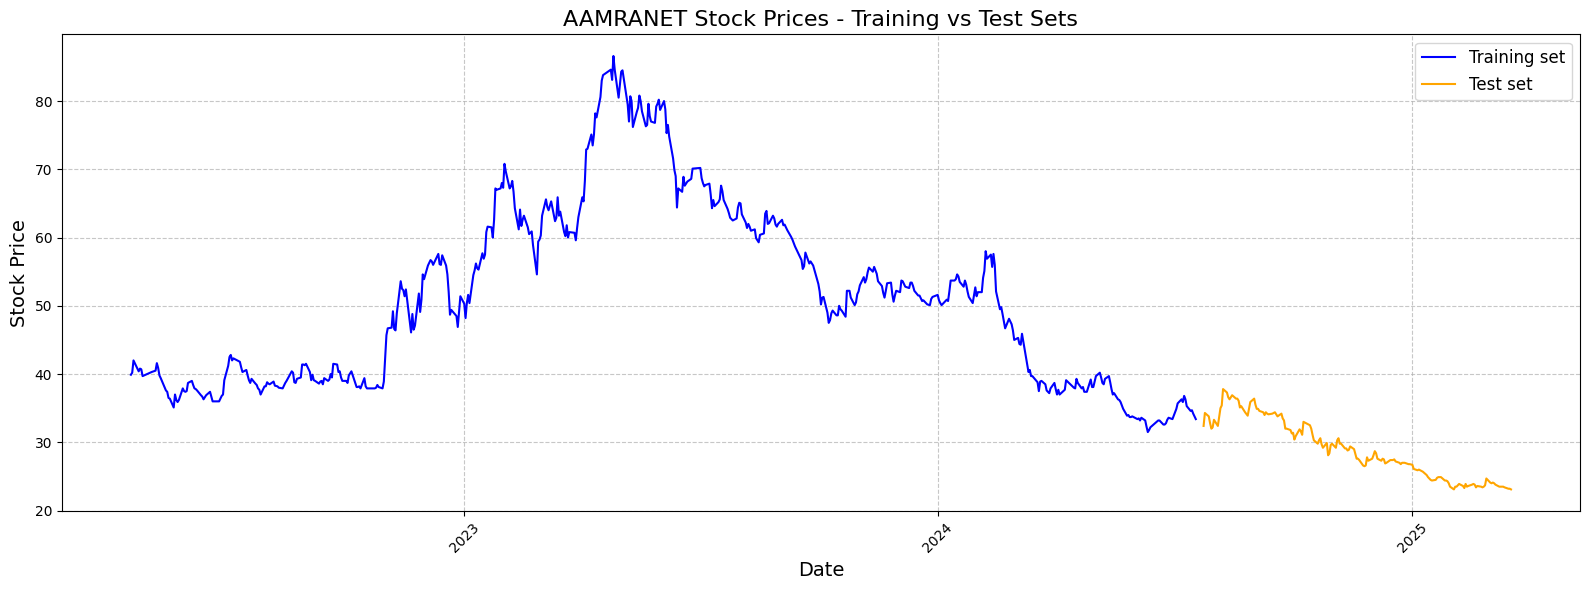

Epoch 1/100


KeyboardInterrupt: 

In [3]:
# iteration 6 - updated/added xgboost
# -*- coding: utf-8 -*-
"""Stock Price Prediction with LSTM, GRU, ARIMA and Traditional Models"""

# --- Install Required Libraries ---
!pip install -q numpy==1.23.5 pandas==1.5.3 matplotlib==3.7.1 scikit-learn==1.2.2 
!pip install -q statsmodels==0.14.0 pmdarima==2.0.3 xgboost==1.7.5 
!pip install -q tensorflow==2.12.0 keras==2.12.0
!pip install -q hmmlearn yfinance
!pip install -q stldecompose

# --- Import Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from xgboost import XGBRegressor
from sklearn.svm import SVR
from hmmlearn import hmm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
import yfinance as yf
import warnings
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import plot_importance
warnings.filterwarnings("ignore")

# --- Helper Functions ---
def lr_schedule(epoch, lr):
    """Learning rate schedule with decay"""
    if epoch < 10:
        return lr
    else:
        return lr * math.exp(-0.1)

def ad_test(dataset):
    """Augmented Dickey-Fuller test for stationarity"""
    dftest = adfuller(dataset, autolag='AIC')
    print('1. ADF:', dftest[0])
    print('2. P-value:', dftest[1])
    print('3. Num of Lags:', dftest[2])
    print('4. Num of Observations:', dftest[3])
    print('5. Critical Values:')
    for key, val in dftest[4].items():
        print(f'\t{key}: {val}')
    return dftest[1]  # Return p-value

def calculate_hmm_metrics(model, scaled_data):
    """Calculate information criteria for HMM"""
    n_samples = len(scaled_data)
    n_parameters = model.n_components * model.n_components + 2 * model.n_components * model.n_features - 1
    logL = model.score(scaled_data)

    aic = -2 * logL + 2 * n_parameters
    bic = -2 * logL + n_parameters * np.log(n_samples)
    hqc = -2 * logL + 2 * n_parameters * np.log(np.log(n_samples))
    caic = -2 * logL + n_parameters * (np.log(n_samples) + 1)

    return aic, bic, hqc, caic

def relative_strength_idx(df, n=14):
    """Calculate Relative Strength Index"""
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

def calculate_macd(df):
    """Calculate MACD indicator"""
    EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
    EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
    df['MACD'] = pd.Series(EMA_12 - EMA_26)
    df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())
    return df

# --- Data Loading and Preparation ---
def load_data(filepath):
    """Load and preprocess the stock data"""
    df = pd.read_csv(filepath, parse_dates=['Date'], dayfirst=True)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])
    df = df.sort_values(['Company', 'Date'])
    
    numeric_cols = ['Open', 'Close', 'High', 'Low', 'Volume']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    df = df.dropna(subset=numeric_cols)
    
    return df

def prepare_sequence_data(company_data, look_back=30):
    """Prepare data for sequence models (LSTM, Bi-LSTM, GRU)"""
    # Add technical indicators
    company_data = add_technical_indicators(company_data)
    
    company_data['ohlc_avg'] = company_data[['Open', 'High', 'Low', 'Close']].mean(axis=1)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(company_data[['ohlc_avg']])
    
    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i, 0])
        y.append(scaled_data[i, 0])
    
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    return X, y, scaler, company_data

def add_technical_indicators(df):
    """Add technical indicators to dataframe"""
    # Moving Averages
    df['EMA_9'] = df['Close'].ewm(9).mean().shift()
    df['SMA_5'] = df['Close'].rolling(5).mean().shift()
    df['SMA_10'] = df['Close'].rolling(10).mean().shift()
    df['SMA_15'] = df['Close'].rolling(15).mean().shift()
    df['SMA_30'] = df['Close'].rolling(30).mean().shift()
    
    # RSI
    df['RSI'] = relative_strength_idx(df).fillna(0)
    
    # MACD
    df = calculate_macd(df)
    
    # Shift close price for next day prediction
    df['Close_Shifted'] = df['Close'].shift(-1)
    
    # Drop invalid rows
    df = df.iloc[33:]  # Because of moving averages and MACD line
    df = df[:-1]       # Because of shifting close price
    
    return df

def prepare_tabular_data(company_data, look_back=30):
    """Prepare data for non-sequence models (XGBoost, SVR)"""
    # Add technical indicators
    company_data = add_technical_indicators(company_data)
    
    # Drop unnecessary columns
    drop_cols = ['Date', 'Volume', 'Open', 'Low', 'High', 'OpenInt', 'Close']
    features = company_data.drop(drop_cols, axis=1, errors='ignore')
    target = company_data['Close_Shifted']
    
    # Split into train, validation and test sets
    test_size = 0.15
    valid_size = 0.15
    
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=test_size, shuffle=False)
    
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train, test_size=valid_size/(1-test_size), shuffle=False)
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test, company_data

def prepare_hmm_data(company_data):
    """Prepare data for HMM model"""
    # Extract OHLC prices
    data = company_data[['Open', 'High', 'Low', 'Close']].values
    
    # Remove any rows with inf or NaN values
    data = data[np.isfinite(data).all(axis=1)]
    
    # Calculate returns for OHLC
    returns = np.diff(np.log(data), axis=0)
    
    # Remove any rows with inf or NaN values in returns
    returns = returns[np.isfinite(returns).all(axis=1)]
    
    # Standardize the returns
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(returns)
    
    # Ensure the data is 2D
    if scaled_data.ndim == 1:
        scaled_data = scaled_data.reshape(-1, 1)
    
    return scaled_data, scaler

# --- Enhanced ARIMA Implementation ---
def train_arima(train_data):
    """Enhanced ARIMA implementation combining both approaches"""
    if isinstance(train_data, pd.DataFrame):
        series = train_data['ohlc_avg']
    else:
        series = train_data
    
    # Check stationarity
    print("\nPerforming Augmented Dickey-Fuller Test:")
    p_value = ad_test(series)
    
    # Plot ACF and PACF
    plt.figure(figsize=(12, 6))
    plot_acf(series, lags=30, ax=plt.subplot(121), title='Autocorrelation')
    plot_pacf(series, lags=30, ax=plt.subplot(122), title='Partial Autocorrelation')
    plt.suptitle(f'ACF and PACF Plots')
    plt.tight_layout()
    plt.show()
    
    # Auto ARIMA for parameter selection
    print("\nRunning auto_arima for parameter selection:")
    model_autoARIMA = auto_arima(series, start_p=0, start_q=0,
                                test='adf',
                                max_p=3, max_q=3,
                                m=1,
                                d=None,
                                seasonal=False,
                                trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True)
    
    print("\nAuto ARIMA Summary:")
    print(model_autoARIMA.summary())
    
    # Plot diagnostics
    print("\nModel Diagnostics:")
    model_autoARIMA.plot_diagnostics(figsize=(15, 8))
    plt.tight_layout()
    plt.show()
    
    # Get the best parameters from auto_arima
    order = model_autoARIMA.order
    print(f"\nBest ARIMA Order: {order}")
    
    # Fit SARIMAX model (enhanced ARIMA)
    model = SARIMAX(series, order=order)
    model_fit = model.fit(disp=False)
    
    return model_fit

# --- Other Model Definitions (LSTM, GRU, etc.) ---
def train_gru(X_train, y_train, epochs=100, batch_size=150):
    """GRU implementation with learning rate scheduling"""
    model = Sequential([
        GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'),
        Dropout(0.2),
        GRU(units=50, return_sequences=True, activation='tanh'),
        Dropout(0.2),
        GRU(units=50, return_sequences=True, activation='tanh'),
        Dropout(0.2),
        GRU(units=50, activation='tanh'),
        Dropout(0.2),
        Dense(units=1)
    ])
    
    optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=False)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    callbacks = [
        EarlyStopping(monitor='loss', patience=15, restore_best_weights=True),
        LearningRateScheduler(lr_schedule)
    ]
    
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              callbacks=callbacks, verbose=1)
    return model

def train_lstm(X_train, y_train, epochs=100, batch_size=32):
    """LSTM implementation"""
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.3),
        LSTM(64, return_sequences=True),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.3),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              callbacks=[early_stopping], verbose=1)
    return model

def train_bilstm(X_train, y_train, epochs=100, batch_size=32):
    """Bidirectional LSTM implementation"""
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.3),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(64)),
        Dropout(0.3),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              callbacks=[early_stopping], verbose=1)
    return model

def train_hmm(company_data, n_states=5):
    """Hidden Markov Model implementation"""
    scaled_data, scaler = prepare_hmm_data(company_data)
    
    # Initialize and train the HMM model
    model = hmm.GaussianHMM(
        n_components=n_states,
        covariance_type="full",
        n_iter=1000,
        random_state=42
    )
    model.fit(scaled_data)
    
    if not model.monitor_.converged:
        print("HMM model did not converge")
        return None
    
    # Calculate information criteria
    aic, bic, hqc, caic = calculate_hmm_metrics(model, scaled_data)
    print(f"\nHMM Information Criteria:")
    print(f"AIC: {aic:.2f}, BIC: {bic:.2f}, HQC: {hqc:.2f}, CAIC: {caic:.2f}")
    
    return model

def train_xgboost(X_train, y_train, X_valid=None, y_valid=None):
    """Enhanced XGBoost implementation with hyperparameter tuning"""
    # If validation data is provided, use it for early stopping
    eval_set = [(X_train, y_train)]
    if X_valid is not None and y_valid is not None:
        eval_set.append((X_valid, y_valid))
    
    # Hyperparameter grid for tuning
    parameters = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.001, 0.01, 0.1],
        'max_depth': [6, 8, 10],
        'gamma': [0.001, 0.01],
        'random_state': [42]
    }
    
    model = XGBRegressor(objective='reg:squarederror')
    clf = GridSearchCV(model, parameters, cv=3, n_jobs=-1)
    
    clf.fit(X_train, y_train, eval_set=eval_set, verbose=False)
    
    print(f'Best parameters: {clf.best_params_}')
    print(f'Best validation score: {clf.best_score_}')
    
    # Train final model with best parameters
    best_model = XGBRegressor(**clf.best_params_, objective='reg:squarederror')
    best_model.fit(X_train, y_train, eval_set=eval_set, verbose=False)
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plot_importance(best_model)
    plt.show()
    
    return best_model

def train_svr(X_train, y_train):
    """SVR implementation"""
    model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
    model.fit(X_train, y_train)
    return model

# --- Prediction Functions ---
def predict_with_hmm(model, company_data, test_dates, feature='Close'):
    """Make predictions using HMM model"""
    try:
        # Prepare the data
        data = company_data[['Open', 'High', 'Low', 'Close']].values
        data = data[np.isfinite(data).all(axis=1)]
        
        # Initialize variables
        D = 96  # Training window size
        d = len(test_dates)  # Prediction window size
        T = len(data) - d  # Starting index
        hmm_predictions = []
        
        # Sliding window approach
        for i in range(d):
            train_data = data[T-D+i:T+i]
            
            # Calculate likelihood of current window
            current_likelihood = model.score(train_data)
            
            # Find most similar historical window
            min_diff = float('inf')
            best_idx = T-D+i
            
            for t in range(T-D):
                window = data[t:t+D]
                window_likelihood = model.score(window)
                diff = abs(window_likelihood - current_likelihood)
                
                if diff < min_diff:
                    min_diff = diff
                    best_idx = t
            
            # Predict next value based on historical pattern
            if feature == 'Open':
                pred = data[T+i-1, 0] + (data[best_idx+1, 0] - data[best_idx, 0])
            elif feature == 'High':
                pred = data[T+i-1, 1] + (data[best_idx+1, 1] - data[best_idx, 1])
            elif feature == 'Low':
                pred = data[T+i-1, 2] + (data[best_idx+1, 2] - data[best_idx, 2])
            else:  # Close
                pred = data[T+i-1, 3] + (data[best_idx+1, 3] - data[best_idx, 3])
            
            hmm_predictions.append(pred)
        
        return np.array(hmm_predictions)
    except Exception as e:
        print(f"Error in HMM prediction: {str(e)}")
        return None

# --- Visualization Functions ---
def plot_training_test_split(company, train_dates, train_prices, test_dates, test_prices):
    """Plot training vs test set split"""
    plt.figure(figsize=(16, 6))
    plt.plot(train_dates, train_prices, label='Training set', color='blue')
    plt.plot(test_dates, test_prices, label='Test set', color='orange')
    plt.title(f'{company} Stock Prices - Training vs Test Sets', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Stock Price', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Format x-axis
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_predictions(company, model_name, dates, actual, predicted, metrics):
    """Plot actual vs predicted prices"""
    plt.figure(figsize=(14, 7))
    plt.plot(dates, actual, label='Actual Prices', color='blue', linewidth=2)
    plt.plot(dates, predicted, label=f'Predicted Prices ({model_name})', 
            color='red', linestyle='--', linewidth=2)
    plt.title(f'{company} Stock Price Prediction ({model_name})', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Stock Price', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Format x-axis
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    
    # Add metrics to plot
    plt.figtext(0.15, 0.8, 
               f"MAE: {metrics['MAE']:.2f}\nRMSE: {metrics['RMSE']:.2f}\nR²: {metrics['R2']:.2f}", 
               bbox=dict(facecolor='white', alpha=0.8),
               fontsize=12)
    
    plt.tight_layout()
    plt.show()

def plot_xgboost_predictions(company, dates, y_true, y_pred):
    """Specialized plot for XGBoost predictions"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Top plot - full range
    ax1.plot(dates, y_true, label='Actual Prices', color='blue')
    ax1.plot(dates, y_pred, label='Predicted Prices', color='red', linestyle='--')
    ax1.set_title(f'{company} Stock Price Prediction (XGBoost)')
    ax1.set_ylabel('Price')
    ax1.legend()
    ax1.grid(True)
    
    # Bottom plot - zoomed in
    ax2.plot(dates[-100:], y_true[-100:], label='Actual Prices', color='blue')
    ax2.plot(dates[-100:], y_pred[-100:], label='Predicted Prices', color='red', linestyle='--')
    ax2.set_title('Zoomed View (Last 100 Days)')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Price')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# --- Main Prediction Function ---
def predict_stock_prices(df, look_back=30):
    """Predict stock prices for all companies in the dataframe"""
    companies = df['Company'].unique()
    results = {}
    
    for company in companies:
        try:
            print(f"\n{'='*50}\nProcessing {company}...\n{'='*50}")
            company_data = df[df['Company'] == company].copy()
            
            if len(company_data) < look_back * 2:
                print(f"Skipping {company} - insufficient data ({len(company_data)} records)")
                continue
                
            # Prepare data for different models
            X_seq, y_seq, seq_scaler, _ = prepare_sequence_data(company_data, look_back)
            X_tab_train, X_tab_valid, X_tab_test, y_tab_train, y_tab_valid, y_tab_test, _ = prepare_tabular_data(company_data, look_back)
            
            # Train-test split for sequence models
            split = int(0.8 * len(X_seq))
            X_seq_train, X_seq_test = X_seq[:split], X_seq[split:]
            y_seq_train, y_seq_test = y_seq[:split], y_seq[split:]
            
            # Get dates and prices for plotting
            test_dates = company_data['Date'].iloc[split+look_back:].values
            train_dates = company_data['Date'].iloc[:split+look_back].values
            train_prices = company_data['Close'].iloc[:split+look_back].values
            test_prices = company_data['Close'].iloc[split+look_back:].values
            
            # Plot training vs test split
            plot_training_test_split(company, train_dates, train_prices, test_dates, test_prices)
            
            # Train all models
            models = {
                'LSTM': train_lstm(X_seq_train, y_seq_train),
                'Bi-LSTM': train_bilstm(X_seq_train, y_seq_train),
                'GRU': train_gru(X_seq_train, y_seq_train),
                'ARIMA': train_arima(company_data.iloc[:split + look_back]),
                'HMM': train_hmm(company_data.iloc[:split + look_back]),
                'XGBoost': train_xgboost(X_tab_train, y_tab_train, X_tab_valid, y_tab_valid),
                'SVR': train_svr(X_tab_train, y_tab_train)
            }
            
            company_results = {}
            
            # Make predictions and plot for each model
            for model_name, model in models.items():
                try:
                    print(f"\nTraining {model_name} model...")
                    
                    if model_name in ['LSTM', 'Bi-LSTM', 'GRU']:
                        predicted = model.predict(X_seq_test)
                        predicted_prices = seq_scaler.inverse_transform(predicted)
                        actual_prices = seq_scaler.inverse_transform(y_seq_test.reshape(-1, 1))
                    elif model_name == 'ARIMA':
                        forecast = model.get_prediction(start=split+look_back, 
                                                      end=len(company_data)-1)
                        predicted_prices = forecast.predicted_mean.values.reshape(-1, 1)
                        actual_prices = seq_scaler.inverse_transform(y_seq_test.reshape(-1, 1))
                    elif model_name == 'HMM':
                        predicted_prices = predict_with_hmm(model, company_data.iloc[:split + look_back], 
                                                          test_dates, 'Close')
                        if predicted_prices is None:
                            continue
                        predicted_prices = predicted_prices.reshape(-1, 1)
                        actual_prices = company_data['Close'].iloc[split+look_back:].values.reshape(-1, 1)
                    else:  # XGBoost, SVR
                        predicted_prices = model.predict(X_tab_test).reshape(-1, 1)
                        actual_prices = y_tab_test.values.reshape(-1, 1)
                    
                    # Calculate metrics
                    metrics = {
                        'MAE': mean_absolute_error(actual_prices, predicted_prices),
                        'RMSE': np.sqrt(mean_squared_error(actual_prices, predicted_prices)),
                        'R2': r2_score(actual_prices, predicted_prices)
                    }
                    
                    # Store results
                    company_results[model_name] = {
                        'predicted': predicted_prices.flatten(),
                        'metrics': metrics
                    }
                    
                    # Special plotting for XGBoost
                    if model_name == 'XGBoost':
                        plot_xgboost_predictions(company, test_dates, 
                                                actual_prices.flatten(), 
                                                predicted_prices.flatten())
                    else:
                        # Plot predictions for other models
                        plot_predictions(company, model_name, test_dates, 
                                       actual_prices.flatten(), predicted_prices.flatten(), metrics)
                    
                    print(f"\nMetrics for {model_name}:")
                    print(f"MAE: {metrics['MAE']:.4f}")
                    print(f"RMSE: {metrics['RMSE']:.4f}")
                    print(f"R2 Score: {metrics['R2']:.4f}")
                    
                except Exception as e:
                    print(f"\nError processing {model_name} for {company}: {str(e)}")
                    company_results[model_name] = None
            
            # Store all results for this company
            results[company] = {
                'dates': test_dates,
                'actual': actual_prices.flatten(),
                'models': company_results
            }
            
        except Exception as e:
            print(f"\nError processing {company}: {str(e)}")
    
    return results

# --- Main Execution ---
if __name__ == "__main__":
    # Load data
    file_path = "combined_stock_data_test.csv"
    print("\nLoading data...")
    stock_data = load_data(file_path)
    
    # Run predictions
    print("\nStarting predictions...")
    prediction_results = predict_stock_prices(stock_data)
    
    # Save results to CSV
    results_df = pd.DataFrame()
    full_results = []
    
    for company, data in prediction_results.items():
        # Save metrics
        for model_name, model_data in data['models'].items():
            if model_data is not None:
                temp_df = pd.DataFrame({
                    'Company': company,
                    'Model': model_name,
                    **model_data['metrics']
                }, index=[0])
                results_df = pd.concat([results_df, temp_df], ignore_index=True)
        
        # Save predictions if we have any models that succeeded
        if any(model_data is not None for model_data in data['models'].values()):
            temp_df = pd.DataFrame({
                'Company': company,
                'Date': data['dates'],
                'Actual_Price': data['actual']
            })
            
            for model_name, model_data in data['models'].items():
                if model_data is not None:
                    temp_df[f'{model_name}_Predicted'] = model_data['predicted']
            
            full_results.append(temp_df)
    
    # Only save files if we have results
    if len(results_df) > 0:
        results_df.to_csv('stock_prediction_results_all_models.csv', index=False)
        print("\nPrediction results saved to 'stock_prediction_results_all_models.csv'")
    else:
        print("\nNo prediction results to save - all models failed")
    
    if len(full_results) > 0:
        pd.concat(full_results).to_csv('full_predictions_all_models.csv', index=False)
        print("Detailed predictions saved to 'full_predictions_all_models.csv'")
    else:
        print("No detailed predictions to save - all models failed")

In [1]:
#latest version iteration
# -*- coding: utf-8 -*-
"""Stock Price Prediction with LSTM, GRU, ARIMA and Traditional Models"""

# --- Install Required Libraries ---
!pip install -q numpy==1.23.5 pandas==1.5.3 matplotlib==3.7.1 scikit-learn==1.2.2 
!pip install -q statsmodels==0.14.0 pmdarima==2.0.3 xgboost==1.7.5 
!pip install -q tensorflow==2.12.0 keras==2.12.0
!pip install -q hmmlearn

# --- Import Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from xgboost import XGBRegressor
from sklearn.svm import SVR
from hmmlearn import hmm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
import warnings
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import plot_importance
warnings.filterwarnings("ignore")

# --- Helper Functions ---
def lr_schedule(epoch, lr):
    """Learning rate schedule with decay"""
    if epoch < 10:
        return lr
    else:
        return lr * math.exp(-0.1)

def ad_test(dataset):
    """Augmented Dickey-Fuller test for stationarity"""
    dftest = adfuller(dataset, autolag='AIC')
    print('1. ADF:', dftest[0])
    print('2. P-value:', dftest[1])
    print('3. Num of Lags:', dftest[2])
    print('4. Num of Observations:', dftest[3])
    print('5. Critical Values:')
    for key, val in dftest[4].items():
        print(f'\t{key}: {val}')
    return dftest[1]

def calculate_hmm_metrics(model, scaled_data):
    """Calculate information criteria for HMM"""
    n_samples = len(scaled_data)
    n_parameters = model.n_components * model.n_components + 2 * model.n_components * model.n_features - 1
    logL = model.score(scaled_data)

    aic = -2 * logL + 2 * n_parameters
    bic = -2 * logL + n_parameters * np.log(n_samples)
    hqc = -2 * logL + 2 * n_parameters * np.log(np.log(n_samples))
    caic = -2 * logL + n_parameters * (np.log(n_samples) + 1)

    return aic, bic, hqc, caic

def relative_strength_idx(df, n=14):
    """Calculate Relative Strength Index"""
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

def calculate_macd(df):
    """Calculate MACD indicator"""
    EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
    EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
    df['MACD'] = pd.Series(EMA_12 - EMA_26)
    df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())
    return df

# --- Data Loading and Preparation ---
def load_data(filepath):
    """Load and preprocess the stock data"""
    df = pd.read_csv(filepath, parse_dates=['Date'], dayfirst=True)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])
    df = df.sort_values(['Company', 'Date'])
    
    numeric_cols = ['Open', 'Close', 'High', 'Low', 'Volume']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    df = df.dropna(subset=numeric_cols)
    
    return df

def add_technical_indicators(df):
    """Add technical indicators to dataframe"""
    # Create OHLC average first
    df['ohlc_avg'] = df[['Open', 'High', 'Low', 'Close']].mean(axis=1)
    
    # Moving Averages
    df['EMA_9'] = df['Close'].ewm(9).mean().shift()
    df['SMA_5'] = df['Close'].rolling(5).mean().shift()
    df['SMA_10'] = df['Close'].rolling(10).mean().shift()
    df['SMA_15'] = df['Close'].rolling(15).mean().shift()
    df['SMA_30'] = df['Close'].rolling(30).mean().shift()
    
    # RSI
    df['RSI'] = relative_strength_idx(df).fillna(0)
    
    # MACD
    df = calculate_macd(df)
    
    # Shift close price for next day prediction
    df['Close_Shifted'] = df['Close'].shift(-1)
    
    # Drop invalid rows
    df = df.iloc[33:]  # Because of moving averages and MACD line
    df = df[:-1]       # Because of shifting close price
    
    return df

def prepare_sequence_data(company_data, look_back=30):
    """Prepare data for sequence models (LSTM, Bi-LSTM, GRU)"""
    # Add technical indicators
    company_data = add_technical_indicators(company_data)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(company_data[['ohlc_avg']])
    
    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i, 0])
        y.append(scaled_data[i, 0])
    
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    return X, y, scaler, company_data

def prepare_tabular_data(company_data, look_back=30):
    """Prepare data for non-sequence models (XGBoost, SVR)"""
    # Add technical indicators
    company_data = add_technical_indicators(company_data)
    
    # Drop unnecessary columns
    drop_cols = ['Date', 'Volume', 'Open', 'Low', 'High', 'Close']
    features = company_data.drop(drop_cols, axis=1, errors='ignore')
    target = company_data['Close_Shifted']
    
    # Split into train, validation and test sets
    test_size = 0.15
    valid_size = 0.15
    
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=test_size, shuffle=False)
    
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train, test_size=valid_size/(1-test_size), shuffle=False)
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test, company_data

def prepare_hmm_data(company_data):
    """Prepare data for HMM model"""
    # Extract OHLC prices
    data = company_data[['Open', 'High', 'Low', 'Close']].values
    
    # Remove any rows with inf or NaN values
    data = data[np.isfinite(data).all(axis=1)]
    
    # Calculate returns for OHLC
    returns = np.diff(np.log(data), axis=0)
    
    # Remove any rows with inf or NaN values in returns
    returns = returns[np.isfinite(returns).all(axis=1)]
    
    # Standardize the returns
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(returns)
    
    # Ensure the data is 2D
    if scaled_data.ndim == 1:
        scaled_data = scaled_data.reshape(-1, 1)
    
    return scaled_data, scaler

# --- Model Definitions ---
def train_arima(train_data):
    """Enhanced ARIMA implementation"""
    if isinstance(train_data, pd.DataFrame):
        series = train_data['ohlc_avg']
    else:
        series = train_data
    
    # Check stationarity
    print("\nPerforming Augmented Dickey-Fuller Test:")
    p_value = ad_test(series)
    
    # Plot ACF and PACF
    plt.figure(figsize=(12, 6))
    plot_acf(series, lags=30, ax=plt.subplot(121), title='Autocorrelation')
    plot_pacf(series, lags=30, ax=plt.subplot(122), title='Partial Autocorrelation')
    plt.suptitle(f'ACF and PACF Plots')
    plt.tight_layout()
    plt.show()
    
    # Auto ARIMA for parameter selection
    print("\nRunning auto_arima for parameter selection:")
    model_autoARIMA = auto_arima(series, start_p=0, start_q=0,
                                test='adf',
                                max_p=3, max_q=3,
                                m=1,
                                d=None,
                                seasonal=False,
                                trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True)
    
    print("\nAuto ARIMA Summary:")
    print(model_autoARIMA.summary())
    
    # Get the best parameters from auto_arima
    order = model_autoARIMA.order
    print(f"\nBest ARIMA Order: {order}")
    
    # Fit SARIMAX model (enhanced ARIMA)
    model = SARIMAX(series, order=order)
    model_fit = model.fit(disp=False)
    
    return model_fit

def train_lstm(X_train, y_train, epochs=100, batch_size=32):
    """LSTM implementation"""
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.3),
        LSTM(64, return_sequences=True),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.3),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              callbacks=[early_stopping], verbose=1)
    return model

def train_xgboost(X_train, y_train, X_valid=None, y_valid=None):
    """Enhanced XGBoost implementation"""
    # If validation data is provided, use it for early stopping
    eval_set = [(X_train, y_train)]
    if X_valid is not None and y_valid is not None:
        eval_set.append((X_valid, y_valid))
    
    # Hyperparameter grid for tuning
    parameters = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.001, 0.01, 0.1],
        'max_depth': [6, 8, 10],
        'gamma': [0.001, 0.01],
        'random_state': [42]
    }
    
    model = XGBRegressor(objective='reg:squarederror')
    clf = GridSearchCV(model, parameters, cv=3, n_jobs=-1)
    
    clf.fit(X_train, y_train, eval_set=eval_set, verbose=False)
    
    print(f'Best parameters: {clf.best_params_}')
    print(f'Best validation score: {clf.best_score_}')
    
    # Train final model with best parameters
    best_model = XGBRegressor(**clf.best_params_, objective='reg:squarederror')
    best_model.fit(X_train, y_train, eval_set=eval_set, verbose=False)
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plot_importance(best_model)
    plt.show()
    
    return best_model

# --- Visualization Functions ---
def plot_training_test_split(company, train_dates, train_prices, test_dates, test_prices):
    """Plot training vs test set split"""
    plt.figure(figsize=(16, 6))
    plt.plot(train_dates, train_prices, label='Training set', color='blue')
    plt.plot(test_dates, test_prices, label='Test set', color='orange')
    plt.title(f'{company} Stock Prices - Training vs Test Sets', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Stock Price', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Format x-axis
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_predictions(company, model_name, dates, actual, predicted, metrics):
    """Plot actual vs predicted prices"""
    plt.figure(figsize=(14, 7))
    plt.plot(dates, actual, label='Actual Prices', color='blue', linewidth=2)
    plt.plot(dates, predicted, label=f'Predicted Prices ({model_name})', 
            color='red', linestyle='--', linewidth=2)
    plt.title(f'{company} Stock Price Prediction ({model_name})', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Stock Price', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Format x-axis
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    
    # Add metrics to plot
    plt.figtext(0.15, 0.8, 
               f"MAE: {metrics['MAE']:.2f}\nRMSE: {metrics['RMSE']:.2f}\nR²: {metrics['R2']:.2f}", 
               bbox=dict(facecolor='white', alpha=0.8),
               fontsize=12)
    
    plt.tight_layout()
    plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    # Load data
    file_path = "combined_stock_data_test.csv"  # Correct input file
    print("\nLoading data...")
    stock_data = load_data(file_path)
    
    # Process data and train models
    print("\nStarting predictions...")
    companies = stock_data['Company'].unique()
    results = []
    
    for company in companies:
        print(f"\nProcessing {company}...")
        company_data = stock_data[stock_data['Company'] == company].copy()
        
        # Prepare data
        X_seq, y_seq, seq_scaler, company_data = prepare_sequence_data(company_data)
        X_tab_train, X_tab_valid, X_tab_test, y_tab_train, y_tab_valid, y_tab_test, _ = prepare_tabular_data(company_data)
        
        # Train-test split for sequence models
        split = int(0.8 * len(X_seq))
        X_seq_train, X_seq_test = X_seq[:split], X_seq[split:]
        y_seq_train, y_seq_test = y_seq[:split], y_seq[split:]
        
        # Get dates for plotting
        test_dates = company_data['Date'].iloc[split+30:]
        
        # Train XGBoost
        print("\nTraining XGBoost model...")
        xgb_model = train_xgboost(X_tab_train, y_tab_train, X_tab_valid, y_tab_valid)
        
        # Make predictions
        xgb_pred = xgb_model.predict(X_tab_test)
        
        # Calculate metrics
        metrics = {
            'MAE': mean_absolute_error(y_tab_test, xgb_pred),
            'RMSE': np.sqrt(mean_squared_error(y_tab_test, xgb_pred)),
            'R2': r2_score(y_tab_test, xgb_pred)
        }
        
        # Store results
        results.append({
            'Company': company,
            'MAE': metrics['MAE'],
            'RMSE': metrics['RMSE'],
            'R2': metrics['R2']
        })
        
        # Plot predictions
        plot_predictions(company, "XGBoost", test_dates, 
                        y_tab_test.values, xgb_pred, metrics)
    
    # Save results to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv('stock_prediction_results_all_models.csv', index=False)
    print("\nPrediction results saved to 'stock_prediction_results_all_models.csv'")

You should consider upgrading via the 'C:\Users\SHEPHERD\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\SHEPHERD\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\SHEPHERD\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\SHEPHERD\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.



Loading data...

Starting predictions...

Processing AAMRANET...

Training XGBoost model...



KeyboardInterrupt



You should consider upgrading via the 'C:\Users\SHEPHERD\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\SHEPHERD\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\SHEPHERD\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\SHEPHERD\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.



Loading data...

Starting predictions...

Processing AAMRANET...

Training LSTM model...
Epoch 1/100
16/16 [==============================] - 7s 35ms/step - loss: 0.0556
Epoch 2/100
16/16 [==============================] - 1s 32ms/step - loss: 0.0149
Epoch 3/100
16/16 [==============================] - 1s 33ms/step - loss: 0.0106
Epoch 4/100
16/16 [==============================] - 1s 32ms/step - loss: 0.0089
Epoch 5/100
16/16 [==============================] - 1s 32ms/step - loss: 0.0085
Epoch 6/100
16/16 [==============================] - 1s 32ms/step - loss: 0.0088
Epoch 7/100
16/16 [==============================] - 1s 33ms/step - loss: 0.0080
Epoch 8/100
16/16 [==============================] - 1s 33ms/step - loss: 0.0071
Epoch 9/100
16/16 [==============================] - 1s 32ms/step - loss: 0.0072
Epoch 10/100
16/16 [==============================] - 1s 33ms/step - loss: 0.0072
Epoch 11/100
16/16 [==============================] - 1s 34ms/step - loss: 0.0063
Epoch 12/100
16/1

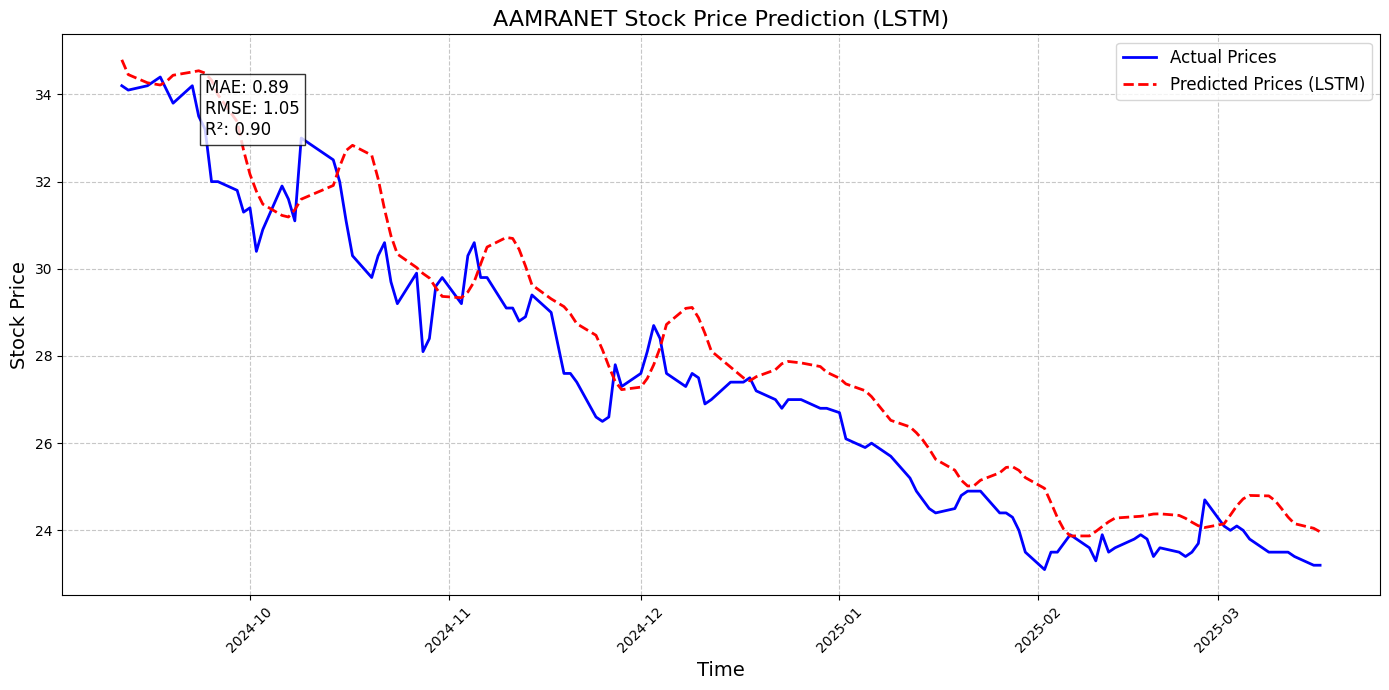


Metrics for LSTM:
MAE: 0.8934
RMSE: 1.0548
R2: 0.8958

Training Bi-LSTM model...
Epoch 1/100
16/16 [==============================] - 11s 64ms/step - loss: 0.0473
Epoch 2/100
16/16 [==============================] - 1s 71ms/step - loss: 0.0129
Epoch 3/100
16/16 [==============================] - 1s 73ms/step - loss: 0.0078
Epoch 4/100
16/16 [==============================] - 1s 73ms/step - loss: 0.0068
Epoch 5/100
16/16 [==============================] - 1s 73ms/step - loss: 0.0054
Epoch 6/100
16/16 [==============================] - 1s 66ms/step - loss: 0.0055
Epoch 7/100
16/16 [==============================] - 1s 64ms/step - loss: 0.0050
Epoch 8/100
16/16 [==============================] - 1s 70ms/step - loss: 0.0050
Epoch 9/100
16/16 [==============================] - 1s 66ms/step - loss: 0.0051
Epoch 10/100
16/16 [==============================] - 1s 66ms/step - loss: 0.0047
Epoch 11/100
16/16 [==============================] - 1s 66ms/step - loss: 0.0044
Epoch 12/100
16/16 [====

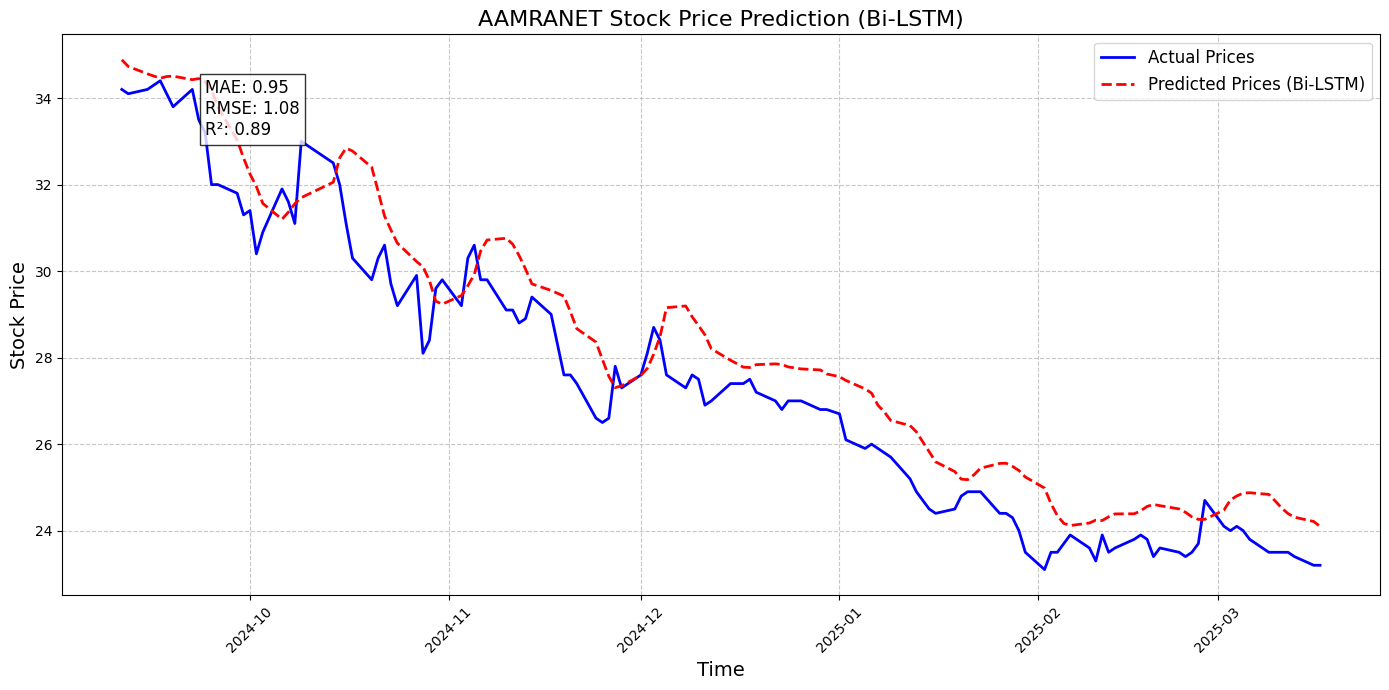


Metrics for Bi-LSTM:
MAE: 0.9530
RMSE: 1.0812
R2: 0.8905

Training GRU model...
Epoch 1/100
4/4 [==============================] - 11s 155ms/step - loss: 0.1242 - lr: 0.0100
Epoch 2/100
4/4 [==============================] - 1s 143ms/step - loss: 0.0621 - lr: 0.0100
Epoch 3/100
4/4 [==============================] - 1s 143ms/step - loss: 0.0573 - lr: 0.0100
Epoch 4/100
4/4 [==============================] - 1s 143ms/step - loss: 0.0442 - lr: 0.0100
Epoch 5/100
4/4 [==============================] - 1s 143ms/step - loss: 0.0370 - lr: 0.0100
Epoch 6/100
4/4 [==============================] - 1s 142ms/step - loss: 0.0273 - lr: 0.0100
Epoch 7/100
4/4 [==============================] - 1s 143ms/step - loss: 0.0227 - lr: 0.0100
Epoch 8/100
4/4 [==============================] - 1s 142ms/step - loss: 0.0195 - lr: 0.0100
Epoch 9/100
4/4 [==============================] - 1s 156ms/step - loss: 0.0162 - lr: 0.0100
Epoch 10/100
4/4 [==============================] - 1s 144ms/step - loss: 0.0135 

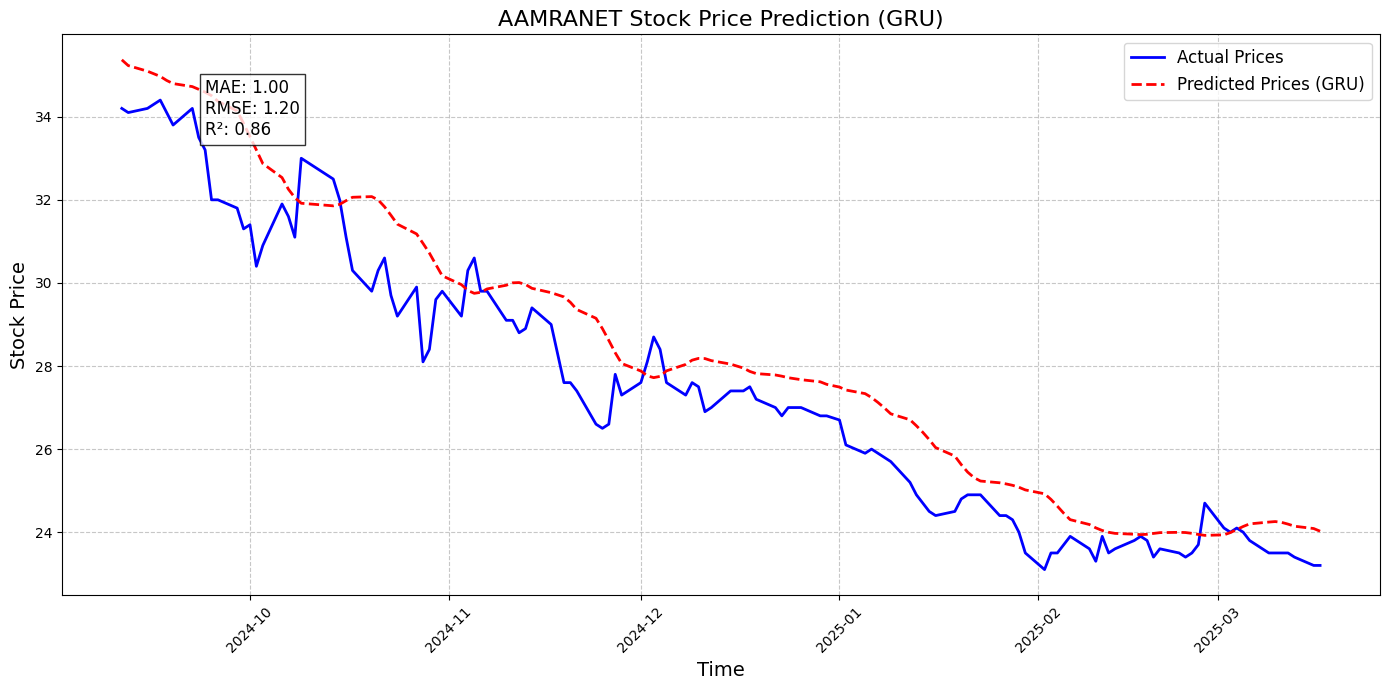


Metrics for GRU:
MAE: 1.0020
RMSE: 1.2027
R2: 0.8645

Training ARIMA model...

Performing Augmented Dickey-Fuller Test:
1. ADF: -1.4264343270421307
2. P-value: 0.5695396284161425
3. Num of Lags: 3
4. Num of Observations: 534
5. Critical Values:
	1%: -3.4426552678216003
	5%: -2.8669676577777548
	10%: -2.569660749624767


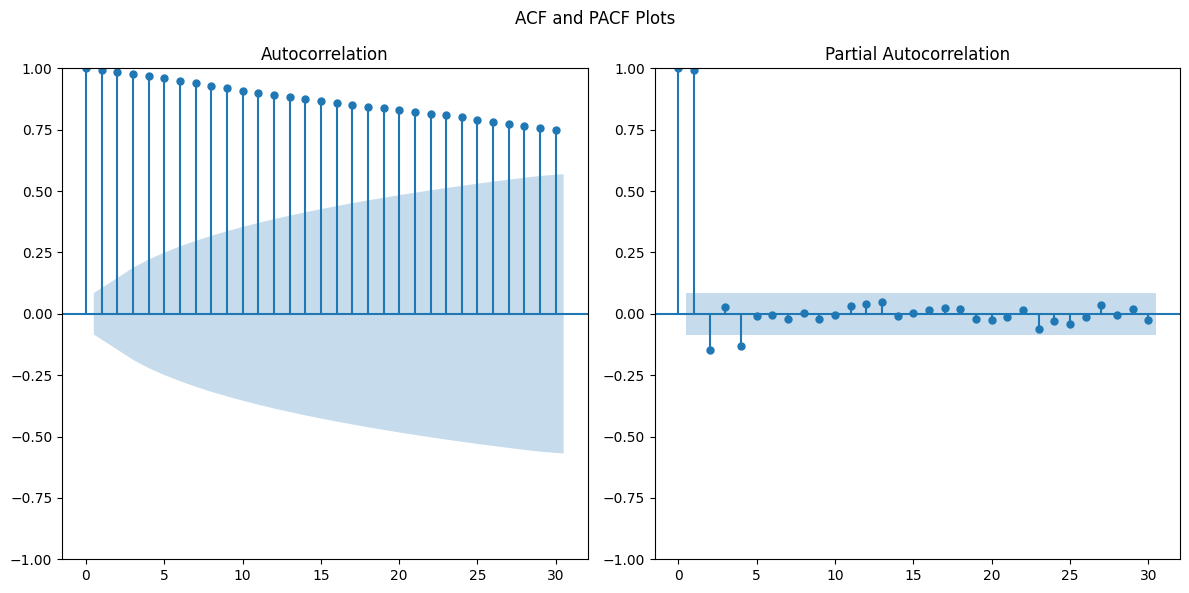


Running auto_arima for parameter selection:
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1676.101, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1648.266, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1641.498, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1674.115, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1634.133, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1635.894, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1636.012, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1638.028, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1648.155, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1631.507, Time=0.97 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1624.302, Time=0.69 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1622.371, Time=0.36 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1621.010, Time=0.13 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1619.019, Ti

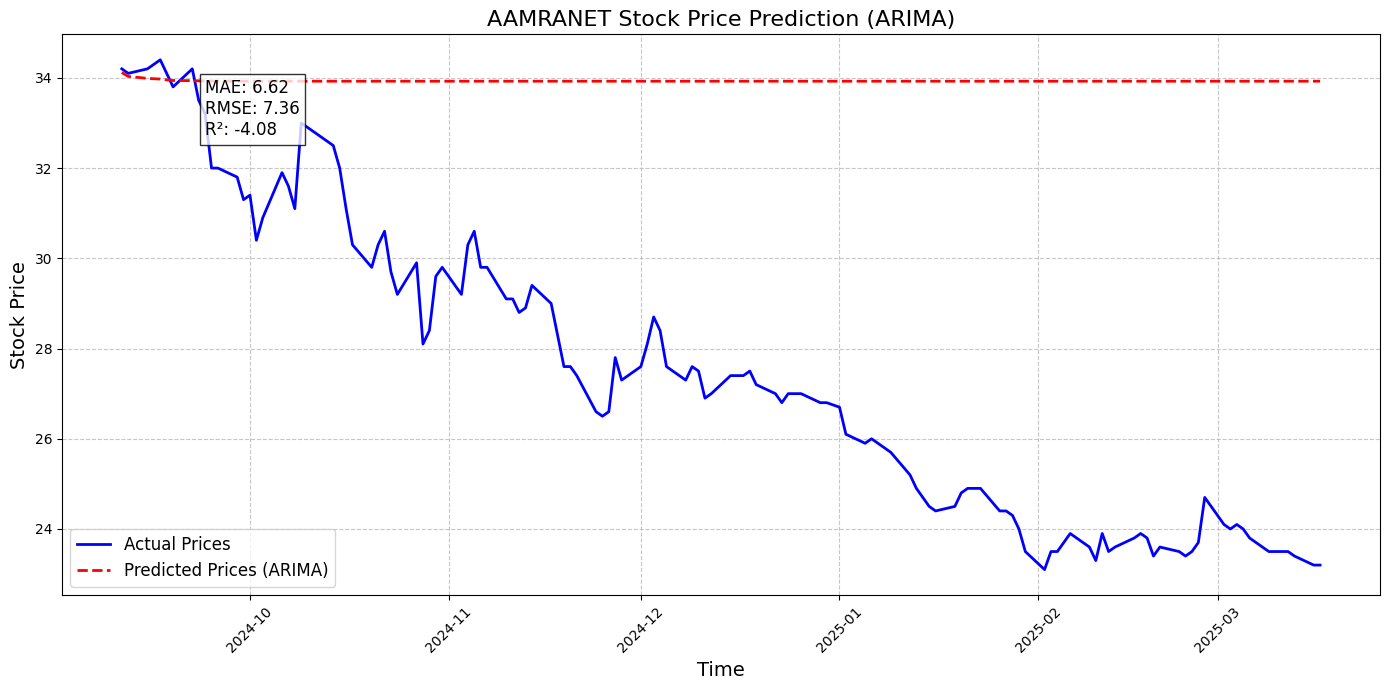


Metrics for ARIMA:
MAE: 6.6220
RMSE: 7.3640
R2: -4.0786

Training HMM model...

HMM Information Criteria:
AIC: 4020.14, BIC: 4294.45, HQC: 4127.45, CAIC: 4358.45


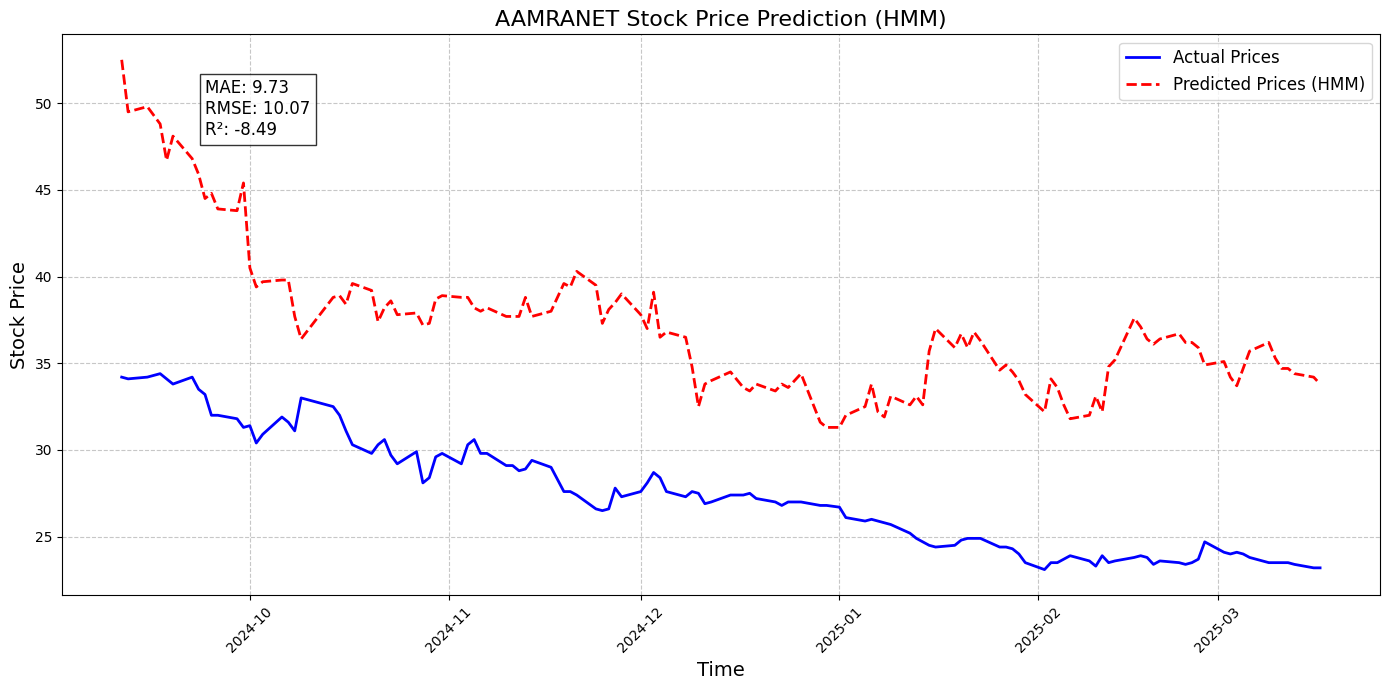


Metrics for HMM:
MAE: 9.7331
RMSE: 10.0677
R2: -8.4925

Training XGBoost model...

Error processing XGBoost for AAMRANET: 
All the 162 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\SHEPHERD\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\SHEPHERD\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "C:\Users\SHEPHERD\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py", line 988, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "C

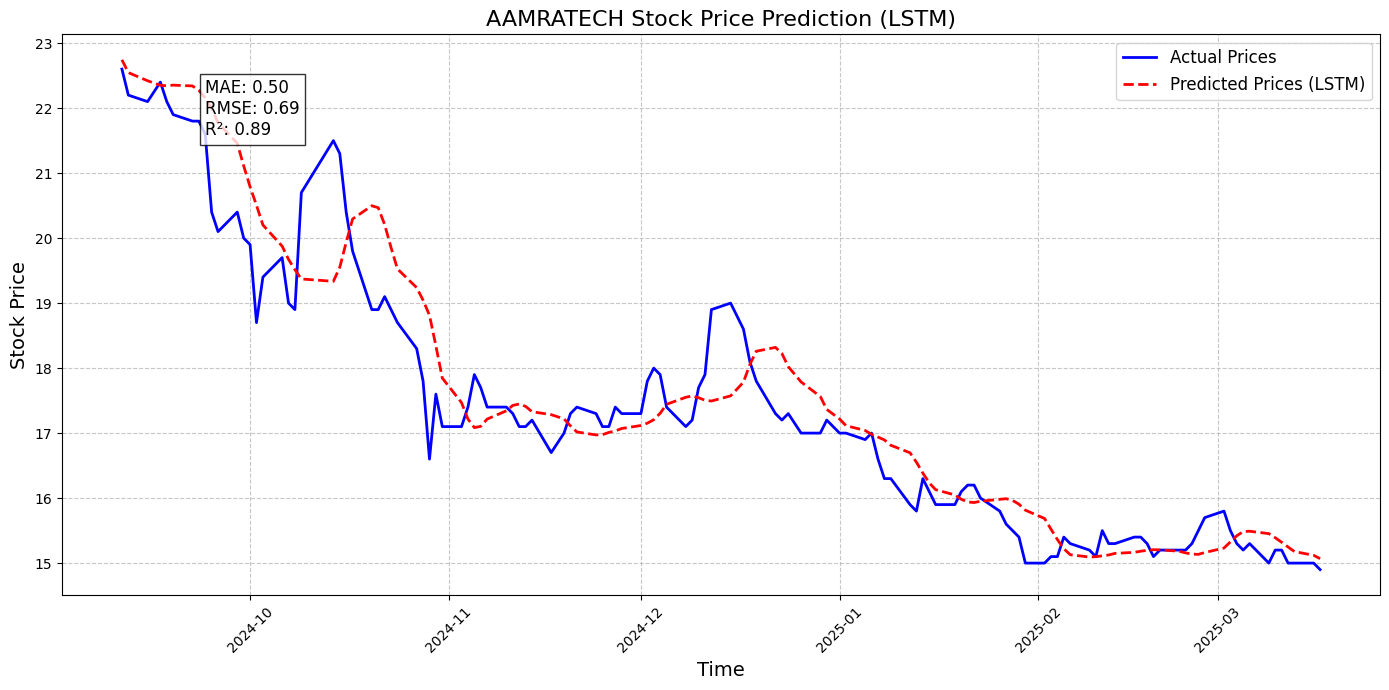


Metrics for LSTM:
MAE: 0.5013
RMSE: 0.6856
R2: 0.8856

Training Bi-LSTM model...
Epoch 1/100
16/16 [==============================] - 22s 135ms/step - loss: 0.0376
Epoch 2/100
16/16 [==============================] - 2s 127ms/step - loss: 0.0098
Epoch 3/100
16/16 [==============================] - 2s 124ms/step - loss: 0.0059
Epoch 4/100
16/16 [==============================] - 2s 126ms/step - loss: 0.0052
Epoch 5/100
16/16 [==============================] - 2s 122ms/step - loss: 0.0050
Epoch 6/100
16/16 [==============================] - 2s 129ms/step - loss: 0.0052
Epoch 7/100
16/16 [==============================] - 2s 134ms/step - loss: 0.0053
Epoch 8/100
16/16 [==============================] - 2s 131ms/step - loss: 0.0047
Epoch 9/100
16/16 [==============================] - 2s 126ms/step - loss: 0.0041
Epoch 10/100
16/16 [==============================] - 2s 120ms/step - loss: 0.0048
Epoch 11/100
16/16 [==============================] - 2s 126ms/step - loss: 0.0037
Epoch 12/100


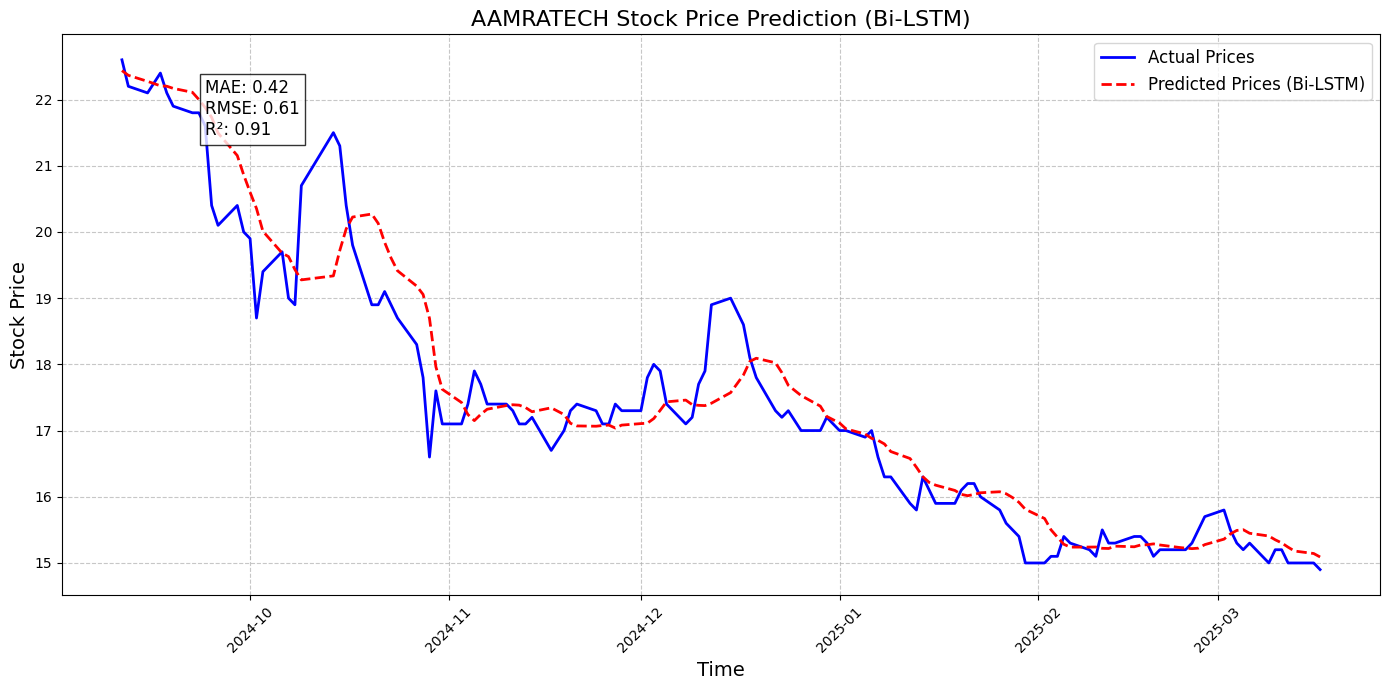


Metrics for Bi-LSTM:
MAE: 0.4238
RMSE: 0.6061
R2: 0.9106

Training GRU model...
Epoch 1/100
4/4 [==============================] - 16s 199ms/step - loss: 0.1249 - lr: 0.0100
Epoch 2/100
4/4 [==============================] - 1s 194ms/step - loss: 0.0682 - lr: 0.0100
Epoch 3/100
4/4 [==============================] - 1s 191ms/step - loss: 0.0453 - lr: 0.0100
Epoch 4/100
4/4 [==============================] - 1s 194ms/step - loss: 0.0451 - lr: 0.0100
Epoch 5/100
4/4 [==============================] - 1s 201ms/step - loss: 0.0323 - lr: 0.0100
Epoch 6/100
4/4 [==============================] - 1s 198ms/step - loss: 0.0295 - lr: 0.0100
Epoch 7/100
4/4 [==============================] - 1s 189ms/step - loss: 0.0240 - lr: 0.0100
Epoch 8/100
4/4 [==============================] - 1s 193ms/step - loss: 0.0222 - lr: 0.0100
Epoch 9/100
4/4 [==============================] - 1s 204ms/step - loss: 0.0214 - lr: 0.0100
Epoch 10/100
4/4 [==============================] - 1s 201ms/step - loss: 0.0200 

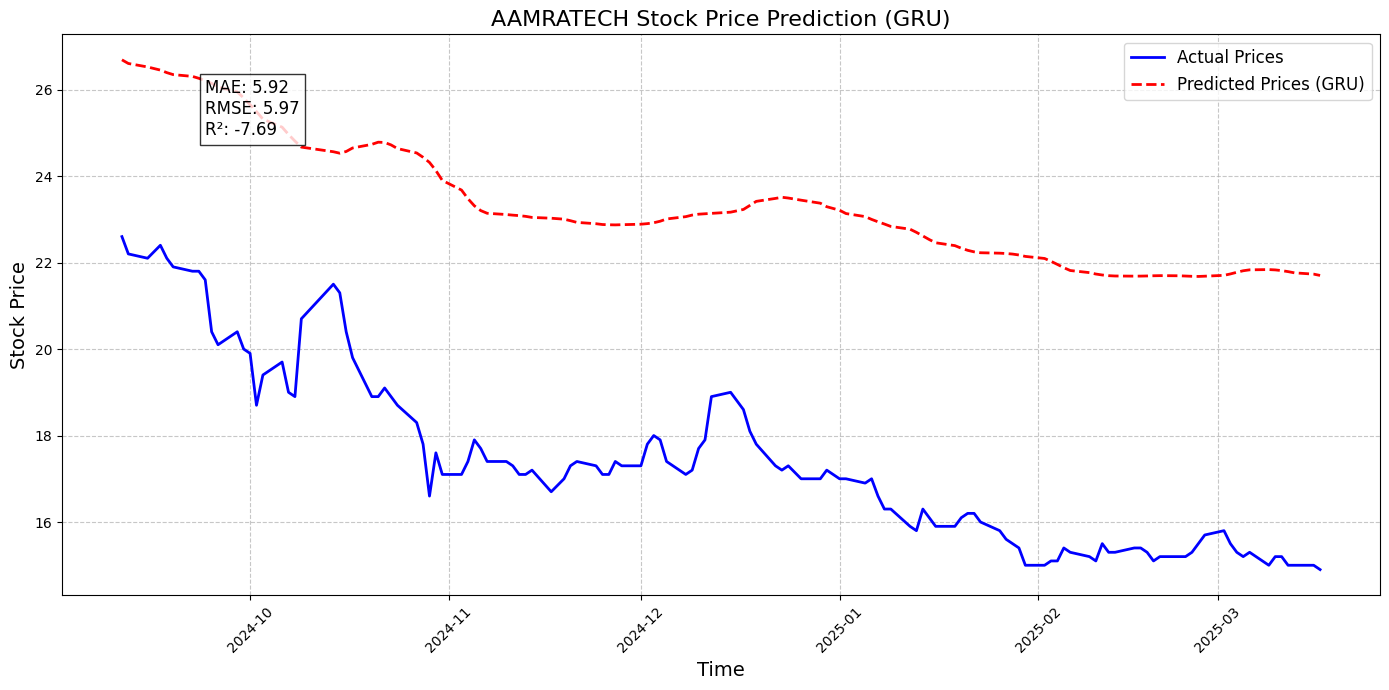


Metrics for GRU:
MAE: 5.9165
RMSE: 5.9745
R2: -7.6915

Training ARIMA model...

Performing Augmented Dickey-Fuller Test:
1. ADF: -1.0621028585255614
2. P-value: 0.7299459138904554
3. Num of Lags: 12
4. Num of Observations: 525
5. Critical Values:
	1%: -3.4428672600488066
	5%: -2.8670609714890403
	10%: -2.5697104770975057


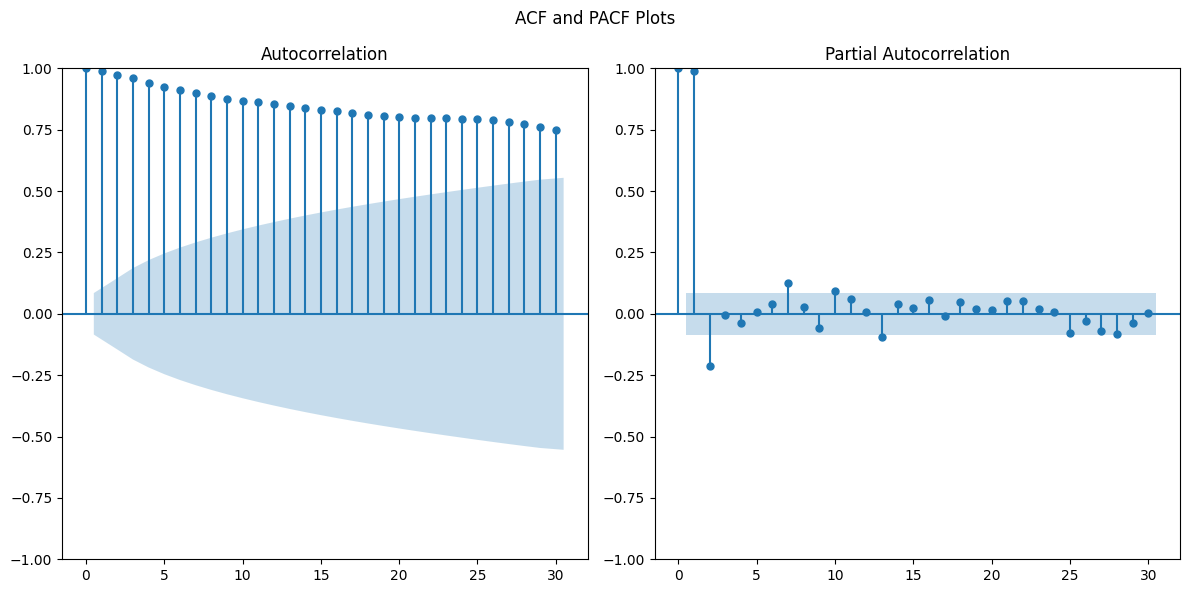


Running auto_arima for parameter selection:
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5309.060, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4589.336, Time=2.28 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1287.811, Time=3.33 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1288.325, Time=2.17 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1288.787, Time=4.90 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=3930.915, Time=7.68 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.78 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1289.929, Time=3.41 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1283.901, Time=4.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2871.335, Time=2.41 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1283.753, Time=5.42 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1281.784, Time=3.92 sec
 AR

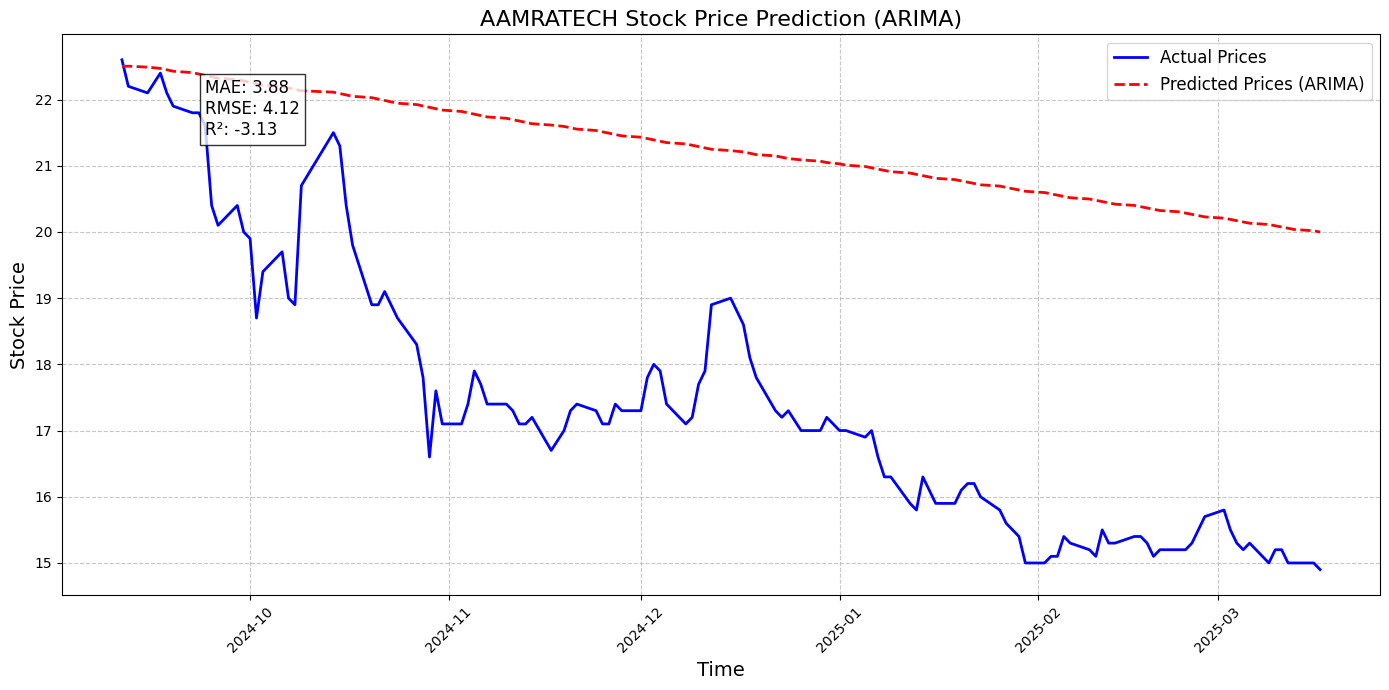


Metrics for ARIMA:
MAE: 3.8782
RMSE: 4.1205
R2: -3.1342

Training HMM model...

HMM Information Criteria:
AIC: 4066.87, BIC: 4341.18, HQC: 4174.18, CAIC: 4405.18


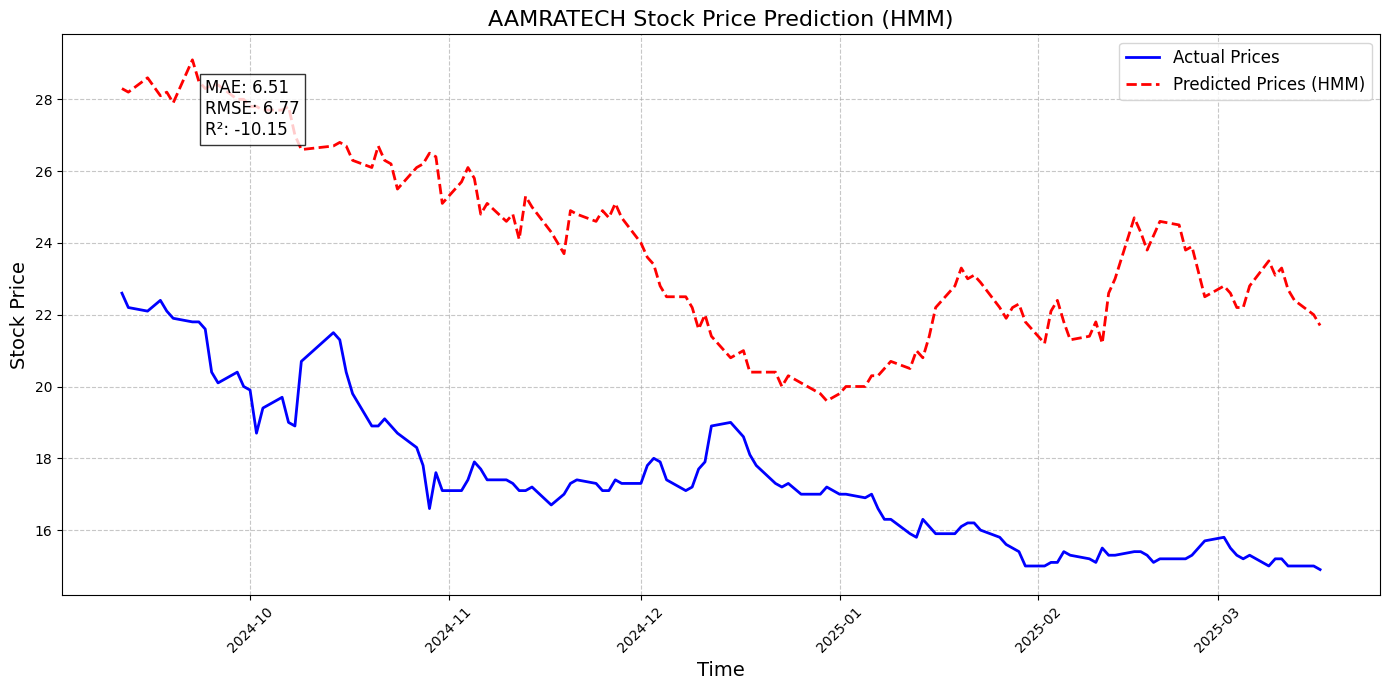


Metrics for HMM:
MAE: 6.5126
RMSE: 6.7665
R2: -10.1484

Training XGBoost model...

Error processing XGBoost for AAMRATECH: 
All the 162 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\SHEPHERD\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\SHEPHERD\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "C:\Users\SHEPHERD\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py", line 988, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "

In [2]:
# -*- coding: utf-8 -*-
"""Complete Stock Price Prediction with All Models - Fixed Version"""

# --- Install Required Libraries ---
!pip install -q numpy==1.23.5 pandas==1.5.3 matplotlib==3.7.1 scikit-learn==1.2.2 
!pip install -q statsmodels==0.14.0 pmdarima==2.0.3 xgboost==1.7.5 
!pip install -q tensorflow==2.12.0 keras==2.12.0
!pip install -q hmmlearn

# --- Import Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from xgboost import XGBRegressor
from sklearn.svm import SVR
from hmmlearn import hmm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
import warnings
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import plot_importance
warnings.filterwarnings("ignore")

# --- Helper Functions ---
def lr_schedule(epoch, lr):
    """Learning rate schedule with decay"""
    if epoch < 10:
        return lr
    else:
        return lr * math.exp(-0.1)

def ad_test(dataset):
    """Augmented Dickey-Fuller test for stationarity"""
    dftest = adfuller(dataset, autolag='AIC')
    print('1. ADF:', dftest[0])
    print('2. P-value:', dftest[1])
    print('3. Num of Lags:', dftest[2])
    print('4. Num of Observations:', dftest[3])
    print('5. Critical Values:')
    for key, val in dftest[4].items():
        print(f'\t{key}: {val}')
    return dftest[1]

def calculate_hmm_metrics(model, scaled_data):
    """Calculate information criteria for HMM"""
    n_samples = len(scaled_data)
    n_parameters = model.n_components * model.n_components + 2 * model.n_components * model.n_features - 1
    logL = model.score(scaled_data)

    aic = -2 * logL + 2 * n_parameters
    bic = -2 * logL + n_parameters * np.log(n_samples)
    hqc = -2 * logL + 2 * n_parameters * np.log(np.log(n_samples))
    caic = -2 * logL + n_parameters * (np.log(n_samples) + 1)

    return aic, bic, hqc, caic

def relative_strength_idx(df, n=14):
    """Calculate Relative Strength Index"""
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

def calculate_macd(df):
    """Calculate MACD indicator"""
    EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
    EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
    df['MACD'] = pd.Series(EMA_12 - EMA_26)
    df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())
    return df

# --- Data Loading and Preparation ---
def load_data(filepath):
    """Load and preprocess the stock data"""
    df = pd.read_csv(filepath, parse_dates=['Date'], dayfirst=True)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])
    df = df.sort_values(['Company', 'Date'])
    
    numeric_cols = ['Open', 'Close', 'High', 'Low', 'Volume']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    df = df.dropna(subset=numeric_cols)
    
    return df

def add_technical_indicators(df):
    """Add technical indicators to dataframe"""
    # Create OHLC average first
    df['ohlc_avg'] = df[['Open', 'High', 'Low', 'Close']].mean(axis=1)
    
    # Moving Averages
    df['EMA_9'] = df['Close'].ewm(9).mean().shift()
    df['SMA_5'] = df['Close'].rolling(5).mean().shift()
    df['SMA_10'] = df['Close'].rolling(10).mean().shift()
    df['SMA_15'] = df['Close'].rolling(15).mean().shift()
    df['SMA_30'] = df['Close'].rolling(30).mean().shift()
    
    # RSI
    df['RSI'] = relative_strength_idx(df).fillna(0)
    
    # MACD
    df = calculate_macd(df)
    
    # Shift close price for next day prediction
    df['Close_Shifted'] = df['Close'].shift(-1)
    
    # Drop invalid rows
    df = df.iloc[33:]  # Because of moving averages and MACD line
    df = df[:-1]       # Because of shifting close price
    
    return df

def prepare_sequence_data(company_data, look_back=30):
    """Prepare data for sequence models (LSTM, Bi-LSTM, GRU)"""
    # Add technical indicators
    company_data = add_technical_indicators(company_data)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(company_data[['ohlc_avg']])
    
    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i, 0])
        y.append(scaled_data[i, 0])
    
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    return X, y, scaler, company_data

def prepare_tabular_data(company_data, look_back=30):
    """Prepare data for non-sequence models (XGBoost, SVR)"""
    # Add technical indicators
    company_data = add_technical_indicators(company_data)
    
    # Drop unnecessary columns including the Company name
    drop_cols = ['Date', 'Volume', 'Open', 'Low', 'High', 'Close', 'Company']
    features = company_data.drop(drop_cols, axis=1, errors='ignore')
    
    # Ensure all remaining columns are numeric
    for col in features.columns:
        if features[col].dtype == 'object':
            features[col] = pd.to_numeric(features[col], errors='coerce')
    
    features = features.dropna(axis=1, how='all')
    target = company_data['Close_Shifted']
    
    # Split into train, validation and test sets
    test_size = 0.15
    valid_size = 0.15
    
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=test_size, shuffle=False)
    
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train, test_size=valid_size/(1-test_size), shuffle=False)
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test, company_data

def prepare_hmm_data(company_data):
    """Prepare data for HMM model"""
    # Extract OHLC prices
    data = company_data[['Open', 'High', 'Low', 'Close']].values
    
    # Remove any rows with inf or NaN values
    data = data[np.isfinite(data).all(axis=1)]
    
    # Calculate returns for OHLC
    returns = np.diff(np.log(data), axis=0)
    
    # Remove any rows with inf or NaN values in returns
    returns = returns[np.isfinite(returns).all(axis=1)]
    
    # Standardize the returns
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(returns)
    
    # Ensure the data is 2D
    if scaled_data.ndim == 1:
        scaled_data = scaled_data.reshape(-1, 1)
    
    return scaled_data, scaler

# --- Model Definitions ---
def train_arima(train_data):
    """Enhanced ARIMA implementation"""
    if isinstance(train_data, pd.DataFrame):
        series = train_data['ohlc_avg']
    else:
        series = train_data
    
    # Check stationarity
    print("\nPerforming Augmented Dickey-Fuller Test:")
    p_value = ad_test(series)
    
    # Plot ACF and PACF
    plt.figure(figsize=(12, 6))
    plot_acf(series, lags=30, ax=plt.subplot(121), title='Autocorrelation')
    plot_pacf(series, lags=30, ax=plt.subplot(122), title='Partial Autocorrelation')
    plt.suptitle(f'ACF and PACF Plots')
    plt.tight_layout()
    plt.show()
    
    # Auto ARIMA for parameter selection
    print("\nRunning auto_arima for parameter selection:")
    model_autoARIMA = auto_arima(series, start_p=0, start_q=0,
                                test='adf',
                                max_p=3, max_q=3,
                                m=1,
                                d=None,
                                seasonal=False,
                                trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True)
    
    print("\nAuto ARIMA Summary:")
    print(model_autoARIMA.summary())
    
    # Get the best parameters from auto_arima
    order = model_autoARIMA.order
    print(f"\nBest ARIMA Order: {order}")
    
    # Fit SARIMAX model (enhanced ARIMA)
    model = SARIMAX(series, order=order)
    model_fit = model.fit(disp=False)
    
    return model_fit

def train_lstm(X_train, y_train, epochs=100, batch_size=32):
    """LSTM implementation"""
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.3),
        LSTM(64, return_sequences=True),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.3),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              callbacks=[early_stopping], verbose=1)
    return model

def train_bilstm(X_train, y_train, epochs=100, batch_size=32):
    """Bidirectional LSTM implementation"""
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.3),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(64)),
        Dropout(0.3),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              callbacks=[early_stopping], verbose=1)
    return model

def train_gru(X_train, y_train, epochs=100, batch_size=150):
    """GRU implementation with learning rate scheduling"""
    model = Sequential([
        GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'),
        Dropout(0.2),
        GRU(units=50, return_sequences=True, activation='tanh'),
        Dropout(0.2),
        GRU(units=50, return_sequences=True, activation='tanh'),
        Dropout(0.2),
        GRU(units=50, activation='tanh'),
        Dropout(0.2),
        Dense(units=1)
    ])
    
    optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=False)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    callbacks = [
        EarlyStopping(monitor='loss', patience=15, restore_best_weights=True),
        LearningRateScheduler(lr_schedule)
    ]
    
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              callbacks=callbacks, verbose=1)
    return model

def train_hmm(company_data, n_states=5):
    """Hidden Markov Model implementation"""
    scaled_data, scaler = prepare_hmm_data(company_data)
    
    # Initialize and train the HMM model
    model = hmm.GaussianHMM(
        n_components=n_states,
        covariance_type="full",
        n_iter=1000,
        random_state=42
    )
    model.fit(scaled_data)
    
    if not model.monitor_.converged:
        print("HMM model did not converge")
        return None
    
    # Calculate information criteria
    aic, bic, hqc, caic = calculate_hmm_metrics(model, scaled_data)
    print(f"\nHMM Information Criteria:")
    print(f"AIC: {aic:.2f}, BIC: {bic:.2f}, HQC: {hqc:.2f}, CAIC: {caic:.2f}")
    
    return model

def train_xgboost(X_train, y_train, X_valid=None, y_valid=None):
    """Enhanced XGBoost implementation"""
    # If validation data is provided, use it for early stopping
    eval_set = [(X_train, y_train)]
    if X_valid is not None and y_valid is not None:
        eval_set.append((X_valid, y_valid))
    
    # Ensure all data is numeric
    X_train = X_train.select_dtypes(include=['number'])
    if X_valid is not None:
        X_valid = X_valid.select_dtypes(include=['number'])
    
    # Simplified hyperparameter grid
    parameters = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 6],
        'random_state': [42]
    }
    
    model = XGBRegressor(objective='reg:squarederror')
    clf = GridSearchCV(model, parameters, cv=3, n_jobs=-1, error_score='raise')
    
    try:
        clf.fit(X_train, y_train, eval_set=eval_set, verbose=False)
        
        print(f'Best parameters: {clf.best_params_}')
        print(f'Best validation score: {clf.best_score_}')
        
        # Train final model with best parameters
        best_model = XGBRegressor(**clf.best_params_, objective='reg:squarederror')
        best_model.fit(X_train, y_train, eval_set=eval_set, verbose=False)
        
        # Plot feature importance
        plt.figure(figsize=(10, 6))
        plot_importance(best_model)
        plt.show()
        
        return best_model
    except Exception as e:
        print(f"Error in XGBoost training: {str(e)}")
        return None

def train_svr(X_train, y_train):
    """SVR implementation"""
    # Ensure all data is numeric
    X_train = X_train.select_dtypes(include=['number'])
    
    # Scale data for SVR
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
    model.fit(X_train_scaled, y_train)
    return model, scaler

# --- Prediction Functions ---
def predict_with_hmm(model, company_data, test_dates, feature='Close'):
    """Make predictions using HMM model"""
    try:
        # Prepare the data
        data = company_data[['Open', 'High', 'Low', 'Close']].values
        data = data[np.isfinite(data).all(axis=1)]
        
        # Initialize variables
        D = 96  # Training window size
        d = len(test_dates)  # Prediction window size
        T = len(data) - d  # Starting index
        hmm_predictions = []
        
        # Sliding window approach
        for i in range(d):
            train_data = data[T-D+i:T+i]
            
            # Calculate likelihood of current window
            current_likelihood = model.score(train_data)
            
            # Find most similar historical window
            min_diff = float('inf')
            best_idx = T-D+i
            
            for t in range(T-D):
                window = data[t:t+D]
                window_likelihood = model.score(window)
                diff = abs(window_likelihood - current_likelihood)
                
                if diff < min_diff:
                    min_diff = diff
                    best_idx = t
            
            # Predict next value based on historical pattern
            if feature == 'Open':
                pred = data[T+i-1, 0] + (data[best_idx+1, 0] - data[best_idx, 0])
            elif feature == 'High':
                pred = data[T+i-1, 1] + (data[best_idx+1, 1] - data[best_idx, 1])
            elif feature == 'Low':
                pred = data[T+i-1, 2] + (data[best_idx+1, 2] - data[best_idx, 2])
            else:  # Close
                pred = data[T+i-1, 3] + (data[best_idx+1, 3] - data[best_idx, 3])
            
            hmm_predictions.append(pred)
        
        return np.array(hmm_predictions)
    except Exception as e:
        print(f"Error in HMM prediction: {str(e)}")
        return None

# --- Visualization Functions ---
def plot_training_test_split(company, train_dates, train_prices, test_dates, test_prices):
    """Plot training vs test set split"""
    plt.figure(figsize=(16, 6))
    plt.plot(train_dates, train_prices, label='Training set', color='blue')
    plt.plot(test_dates, test_prices, label='Test set', color='orange')
    plt.title(f'{company} Stock Prices - Training vs Test Sets', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Stock Price', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Format x-axis
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_predictions(company, model_name, dates, actual, predicted, metrics):
    """Plot actual vs predicted prices for any model"""
    plt.figure(figsize=(14, 7))
    plt.plot(dates, actual, label='Actual Prices', color='blue', linewidth=2)
    plt.plot(dates, predicted, label=f'Predicted Prices ({model_name})', 
            color='red', linestyle='--', linewidth=2)
    plt.title(f'{company} Stock Price Prediction ({model_name})', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Stock Price', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Format x-axis
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    
    # Add metrics to plot
    plt.figtext(0.15, 0.8, 
               f"MAE: {metrics['MAE']:.2f}\nRMSE: {metrics['RMSE']:.2f}\nR²: {metrics['R2']:.2f}", 
               bbox=dict(facecolor='white', alpha=0.8),
               fontsize=12)
    
    plt.tight_layout()
    plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    # Load data
    file_path = "combined_stock_data_test.csv"
    print("\nLoading data...")
    stock_data = load_data(file_path)
    
    # Process data and train models
    print("\nStarting predictions...")
    companies = stock_data['Company'].unique()
    all_results = []
    
    for company in companies:
        print(f"\n{'='*50}\nProcessing {company}...\n{'='*50}")
        company_data = stock_data[stock_data['Company'] == company].copy()
        
        if len(company_data) < 100:  # Minimum data requirement
            print(f"Skipping {company} - insufficient data ({len(company_data)} records)")
            continue
            
        # Prepare data for all models
        X_seq, y_seq, seq_scaler, company_data = prepare_sequence_data(company_data)
        X_tab_train, X_tab_valid, X_tab_test, y_tab_train, y_tab_valid, y_tab_test, _ = prepare_tabular_data(company_data)
        
        # Train-test split for sequence models
        split = int(0.8 * len(X_seq))
        X_seq_train, X_seq_test = X_seq[:split], X_seq[split:]
        y_seq_train, y_seq_test = y_seq[:split], y_seq[split:]
        
        # Get dates for plotting
        test_dates = company_data['Date'].iloc[split+30:]
        actual_prices = company_data['Close'].iloc[split+30:].values
        
        # Initialize results storage for this company
        company_results = {
            'Company': company,
            'Models': {}
        }
        
        # Define all models to train
        models_to_train = {
            'LSTM': lambda: train_lstm(X_seq_train, y_seq_train),
            'Bi-LSTM': lambda: train_bilstm(X_seq_train, y_seq_train),
            'GRU': lambda: train_gru(X_seq_train, y_seq_train),
            'ARIMA': lambda: train_arima(company_data.iloc[:split+30]),
            'HMM': lambda: train_hmm(company_data.iloc[:split+30]),
            'XGBoost': lambda: train_xgboost(X_tab_train, y_tab_train, X_tab_valid, y_tab_valid),
            'SVR': lambda: train_svr(X_tab_train, y_tab_train)
        }
        
        # Train and evaluate each model
        for model_name, train_func in models_to_train.items():
            try:
                print(f"\nTraining {model_name} model...")
                
                # Special handling for SVR which returns both model and scaler
                if model_name == 'SVR':
                    model, svr_scaler = train_func()
                    if model is None:
                        continue
                    # Scale test data for prediction
                    X_tab_test_svr = X_tab_test.select_dtypes(include=['number'])
                    X_tab_test_scaled = svr_scaler.transform(X_tab_test_svr)
                    predicted_prices = model.predict(X_tab_test_scaled)
                else:
                    model = train_func()
                    if model is None:
                        continue
                
                # Make predictions
                if model_name in ['LSTM', 'Bi-LSTM', 'GRU']:
                    predicted = model.predict(X_seq_test)
                    predicted_prices = seq_scaler.inverse_transform(predicted).flatten()
                elif model_name == 'ARIMA':
                    forecast = model.get_prediction(start=split+30, end=len(company_data)-1)
                    predicted_prices = forecast.predicted_mean.values
                elif model_name == 'HMM':
                    predicted_prices = predict_with_hmm(model, company_data.iloc[:split+30], test_dates)
                    if predicted_prices is None:
                        continue
                elif model_name == 'XGBoost':
                    X_tab_test_xgb = X_tab_test.select_dtypes(include=['number'])
                    predicted_prices = model.predict(X_tab_test_xgb)
                
                # Calculate metrics
                metrics = {
                    'MAE': mean_absolute_error(actual_prices, predicted_prices),
                    'RMSE': np.sqrt(mean_squared_error(actual_prices, predicted_prices)),
                    'R2': r2_score(actual_prices, predicted_prices)
                }
                
                # Store results
                company_results['Models'][model_name] = metrics
                
                # Plot predictions
                plot_predictions(company, model_name, test_dates, 
                               actual_prices, predicted_prices, metrics)
                
                print(f"\nMetrics for {model_name}:")
                for metric, value in metrics.items():
                    print(f"{metric}: {value:.4f}")
                    
            except Exception as e:
                print(f"\nError processing {model_name} for {company}: {str(e)}")
                company_results['Models'][model_name] = None
        
        # Add company results to all results
        all_results.append(company_results)
    
    # Save results to CSV
    results_list = []
    for result in all_results:
        for model_name, metrics in result['Models'].items():
            if metrics is not None:
                results_list.append({
                    'Company': result['Company'],
                    'Model': model_name,
                    **metrics
                })
    
    results_df = pd.DataFrame(results_list)
    results_df.to_csv('stock_prediction_results_all_models.csv', index=False)
    print("\nPrediction results saved to 'stock_prediction_results_all_models.csv'")